In [370]:
# ** CMSC 320 UMD**
# *Project 2*
## **Author : Franklin Nkokam Ngongang**
### Due date : March 26, 2021
### Email : fnkokamn@terpmail.umd.edu
### UID : 117548327

In [400]:
import sqlite3
import pandas 
from matplotlib import pyplot as plt
import os

In [401]:
sqlite_file = 'lahman2014.sqlite'
backup_database_file = 'blabladb.sqlite'
conn = sqlite3.connect(sqlite_file)

Pre-required data.
This part was added last. Due to running several queries. we found out that we will need access to a list of team ids for this project. We will therefore load the team ids into a list, and reuse that list everyt time.

In [402]:
select_team_details_query = " SELECT DISTINCT T.name , T.teamId from Teams as T ORDER BY T.name"
team_details_result = pandas.read_sql(select_team_details_query, conn)

In [403]:
team_details_result.columns

Index(['name', 'teamID'], dtype='object')

In [404]:
team_names = [] # saving the team names in a list
team_ids = []
for index, row in team_details_result.iterrows():
    team_id = str(row['teamID']) # the team ID should be in string format
    team_name = str(row['name']) # The name should also be in a string format
    if not(bool(str(team_id))) == False:
        team_ids.append(team_id)
        team_names.append(team_name)

### ** Part 1 : Wrangling **

We need to compute the total payroll and winning percentage for each team.
The total payroll will be a sum of salaries in the salaries table, grouping by the teamId or grouping by yearID, depending if we want to view per team or per year.
The winning percentage is as defined the number of wins divided by number of games played(not games played at home), all multiplied by 100. Now we already have the list of team ids saved in a list. We can find that total payroll and winning percentage for each team by looping through that list of eam ids

In [405]:
working_query = "SELECT Teams.name as `TEAM NAME`, Salaries.teamID as `TEAM ID`, " + \
        "printf('%5.2f %',((SUM(Teams.W)*1.0)/(SUM(Teams.G)*1.0))*100.0) AS `WINNING PERCENTAGE`, " + \
        "printf('$%,d',SUM(Salaries.salary)) AS `TOTAL PAYROLL` " + \
        "FROM Salaries " + \
        "LEFT JOIN Teams ON Salaries.teamID = Teams.teamID " + \
        "GROUP BY `TEAM ID` " + \
        "ORDER BY `TEAM NAME`,`TEAM ID` "
query_result = pandas.read_sql(working_query, conn)
#query_result

In [406]:
query_result

,TEAM NAME,TEAM ID,WINNING PERCENTAGE,TOTAL PAYROLL
0,None,NYM,0.00 %,"$54,806,990"
1,None,SFG,0.00 %,"$143,510,167"
2,Anaheim Angels,ANA,51.23 %,"$3,744,735,784"
3,Arizona Diamondbacks,ARI,49.20 %,"$20,569,578,876"
4,Atlanta Braves,ATL,51.76 %,"$92,264,392,416"
5,Baltimore Orioles,BAL,51.23 %,"$99,442,202,318"
6,Boston Red Sox,BOS,51.43 %,"$277,327,906,590"
7,California Angels,CAL,48.24 %,"$8,703,325,760"
8,Chicago White Sox,CHA,50.18 %,"$193,784,626,302"
9,Chicago White Stockings,CHN,50.70 %,"$258,516,830,785"


#### Explanation of the working_query 

The first line selects the tteam id found in the Salaries table.
The next line calculates the percentage wins. Here we multiply the sums by 1.0 to make sqlite convert it to floating points number, else the division operator will return zero for every sum of wins over sum of total games played, since the division operator returns zero if an numerator is divided by an denominator when the numerator is less than the denominator.
The next line calculates the total salary paid to players for that particular team for a specific year. It uses the printf function to format the data to 5 spots(including the dot character) : two decimal places, and two places before the decimal like the C printf function would do. It's just a semi replica of the c printf function.
The next line tells sqlite from what tables to pull the data from, both from Salaries and Teams table. 
The next line specifies the mathematical joining clause. In this instancd the left join clause.

#### Dealing with the empty values

Let's examine the query above, more precisely the left join clause : 
SELECT Teams.name as `TEAM NAME`, Salaries.teamID as `TEAM ID`,
printf('%5.2f %',((SUM(Teams.W)*1.0)/(SUM(Teams.G)*1.0))*100.0) 
AS `WINNING PERCENTAGE`,    
printf('$%,d',SUM(Salaries.salary)) AS `TOTAL PAYROLL`    
FROM Salaries    
LEFT JOIN Teams ON Salaries.teamID = teams.teamID    
GROUP BY `TEAM ID`    
ORDER BY `TEAM ID` 

The left join line tells sqlite to pull out results from the Salaries tables, and the teams table, for each row such that the team id for that row in the Salaries table is being foreign-keyed by a team id from the Teams table. So what this means is that the we want the results to be in such a way that we only see results when the team id is found in the Salaries table. Now in our case, every row in the Salaries table has a team id that comes from the Teams table. Now some teams might not have any rows in the salaries table. So doing a left join on the Salaries table instead will bring out some null values. But doing a left join on the Teams table will not bring out any nulls unless there are team ids in the Salaries table that have no teams in the Teams table, which does not make sense.

To find out where the empty sets come from, we decided to search for any team in the Salaries table that does not have a row in the Teams table. Thinking about that, it's not supposed to be possible. But in this case it is. Let's have a look at that. First let's select team ids in the salary table that are not present in the teams table

In [407]:
surprise_query = "SELECT DISTINCT teamID FROM Salaries " + \
                 "WHERE teamID NOT IN (" + \
                 "SELECT DISTINCT teamID FROM Teams"  + \
                 " ) "
surprise_result = pandas.read_sql(surprise_query, conn)
surprise_result

,teamID
0,NYM
1,SFG


So there are two teams rows in the Salaries table not found in the Teams table.
Let's find their total payroll

In [408]:
further_query = "SELECT teamID, " + \
        "printf('$%,d',SUM(salary)) AS `TOTAL PAYROLL` " + \
        "FROM Salaries " + \
        "WHERE (teamID = 'NYM' OR teamID ='SFG') " + \
        "GROUP BY teamID " + \
        "ORDER BY teamID "
further_result = pandas.read_sql(further_query, conn)
further_result

,teamID,TOTAL PAYROLL
0,NYM,"$54,806,990"
1,SFG,"$143,510,167"


This results matches the two None teamId starting rows we have in the beginning of this part. An alternative will be to left join on Teams table instead.

In [409]:
good_query = "SELECT Teams.name as `TEAM NAME`, Salaries.teamID as `TEAM ID`, " + \
        "printf('%5.2f%',((SUM(Teams.W)*1.0)/(SUM(Teams.G)*1.0))*100.0) AS `WINNING PERCENTAGE`, " + \
        "printf('$%,d',SUM(Salaries.salary)) AS `TOTAL PAYROLL` " + \
        "FROM Teams " + \
        "LEFT JOIN Salaries ON Salaries.teamID = Teams.teamID " + \
        "GROUP BY `TEAM ID` " + \
        "ORDER BY `TEAM NAME`,`TEAM ID` "

In [410]:
good_result = pandas.read_sql(good_query, conn)
good_result

,TEAM NAME,TEAM ID,WINNING PERCENTAGE,TOTAL PAYROLL
0,Anaheim Angels,ANA,51.23%,"$3,744,735,784"
1,Arizona Diamondbacks,ARI,49.20%,"$20,569,578,876"
2,Atlanta Braves,ATL,51.76%,"$92,264,392,416"
3,Baltimore Orioles,BAL,51.23%,"$99,442,202,318"
4,Boston Americans,BOS,51.43%,"$277,327,906,590"
5,Boston Red Stockings,None,48.06%,$0
6,California Angels,CAL,48.24%,"$8,703,325,760"
7,Chicago White Sox,CHA,50.18%,"$193,784,626,302"
8,Chicago White Stockings,CHN,50.70%,"$258,516,830,785"
9,Cincinnati Reds,CIN,50.14%,"$179,346,918,500"


With this query above, we get a result without None values.

## **Part 2 : Exploratory Data Analysis**
### *** Payroll Distribution *** 

### *** Distribution of payrolls conditioned on time between the years 1990 and 2014 ***

For this section, we want to see how the payrolls distribute over time between 1990 and 2014. For that we will use a similar query to the query above.

In [411]:
payroll_query =  \
        "SELECT Salaries.teamID as `TEAM ID`, " + \
        "Salaries.yearID AS `YEAR`, " + \
        "SUM(Salaries.salary) AS `TOTAL SALARY PAID` " + \
        "FROM Salaries " + \
        "WHERE Salaries.yearID >= '1990' AND " + \
        "Salaries.yearID <= '2014' " + \
        "GROUP BY `TEAM ID`, `YEAR` " + \
        "ORDER BY `TEAM ID`, `YEAR` " 
payroll_result = pandas.read_sql(payroll_query, conn)
payroll_result.head()

,TEAM ID,YEAR,TOTAL SALARY PAID
0,ANA,1997,31135472.0
1,ANA,1998,41281000.0
2,ANA,1999,55388166.0
3,ANA,2000,51464167.0
4,ANA,2001,47535167.0


In [412]:
payroll_result.tail()

,TEAM ID,YEAR,TOTAL SALARY PAID
725,WAS,2010,61400000.0
726,WAS,2011,63856928.0
727,WAS,2012,80855143.0
728,WAS,2013,113703270.0
729,WAS,2014,131983680.0


Above is what the results will look like. So we need to plot the results for all the years. We could do it as a query, then plot it. This will require manipulating the dataframe to pick the salaries paid per team for each year. That is tedious, when sql can do the job for us in case we have the team IDs in a list.
So a better way is to have the list of teamIds and names in a python list, then make an sql query selection based on each value for that list, then plot the result for each team, since each value in the list will correspond to a unique team. Luckily at the begnining of this document, we selected the list of team ids and team names and stored them in a list.

In [413]:
# saving the result of running the read_sql function in a list
result_frames_objects = [] 

for index in range(len(team_ids)):
    team_id = str(team_ids[index]) # the team ID should be in string format
    team_name = str(team_names[index]) # The name should also be in a string format
    the_query = "SELECT SUM(salary) as `Total_Payroll`, " + \
                "AVG(salary) AS `Average_Payroll`, " + \
                "yearID as `Year` " + \
                "FROM Salaries " + \
                "WHERE teamID = '" + team_id + "' "  + \
                "AND yearID >= '1990' AND yearID <= '2014' " + \
                "GROUP BY yearID ORDER BY yearID "
   
    result_frames_objects.append(pandas.read_sql(the_query, conn))
    

#### Explaing the query above

We are selecting the total payrolls ad average payrolls for each year. 
That salary sum will be identified in the dataframe as Total_Payroll.  The where clause identifies the team for which the selection should be made, and the yearId should be between 1990 and 2014,inclusive.
The result will be saved in a list. We will iterate over that list to plot it. 

In [414]:
len(result_frames_objects) # checking if the list is not empty

185

In [415]:
len(result_frames_objects) # checking if the list is not empty


185

Now let's have fun plotting the results we just got.
Plotting these results generate warnings because more than 20 figures are generated. The solution is to save the plots as images and just show the images after closing the opened figures

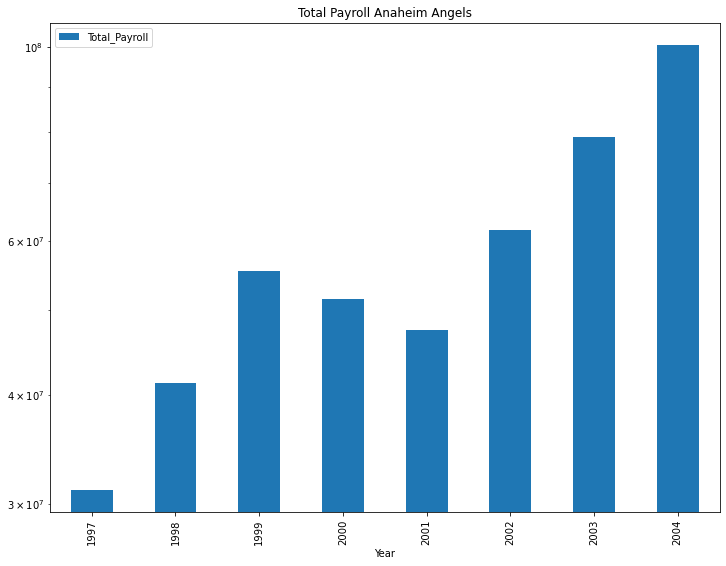

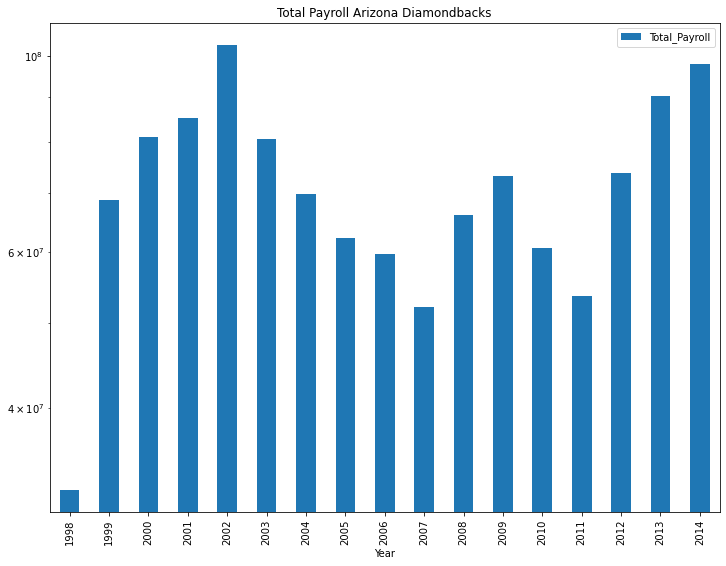

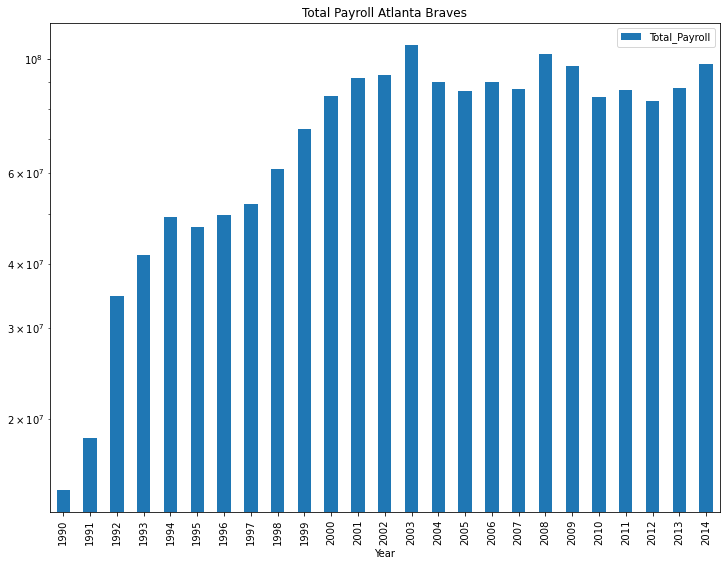

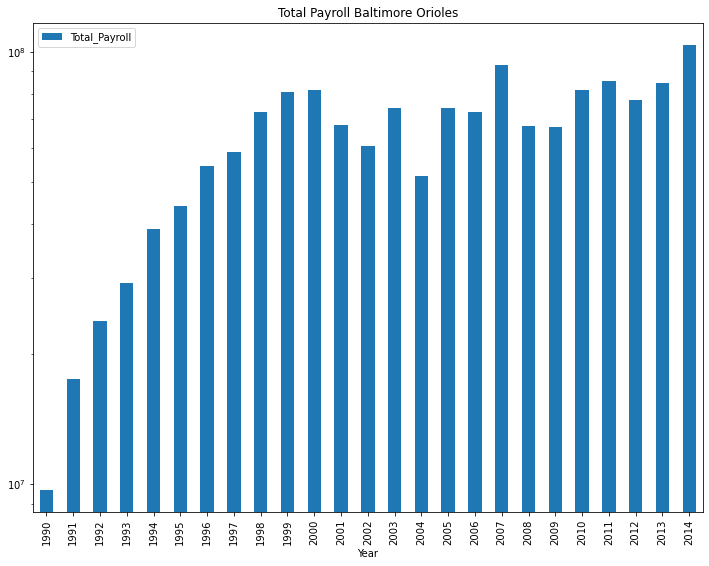

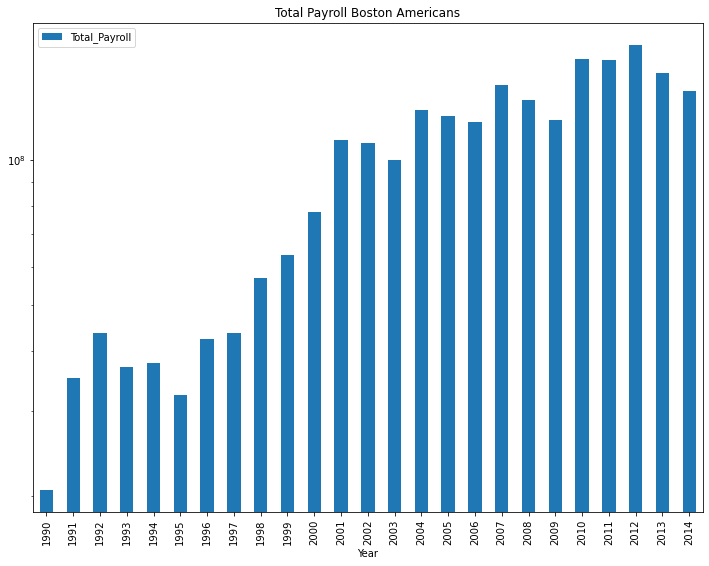

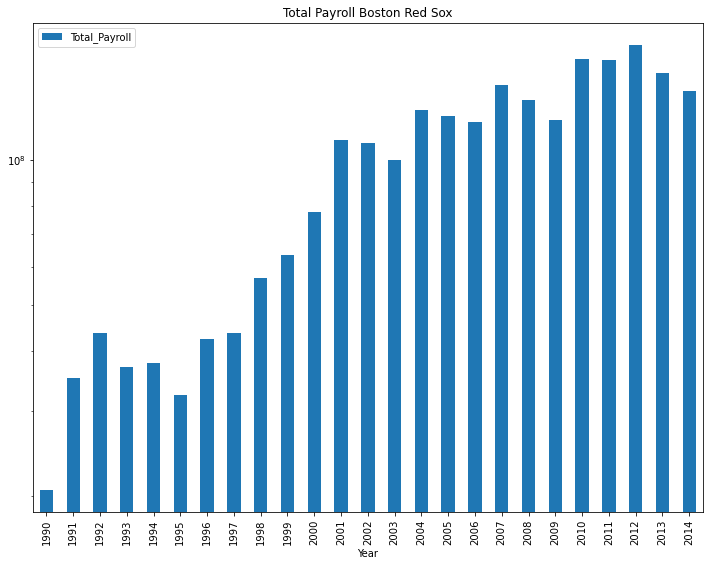

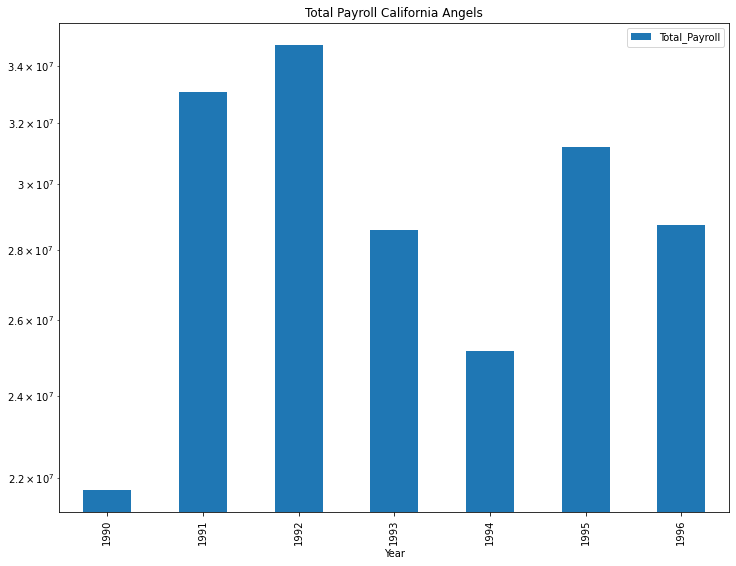

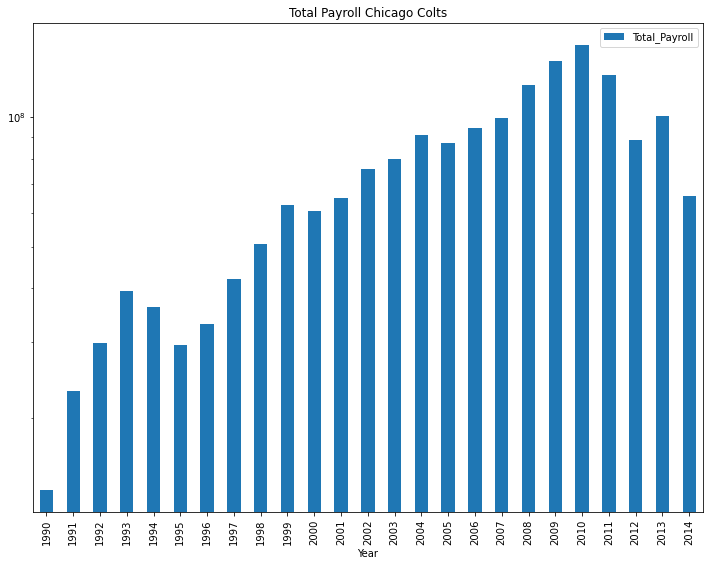

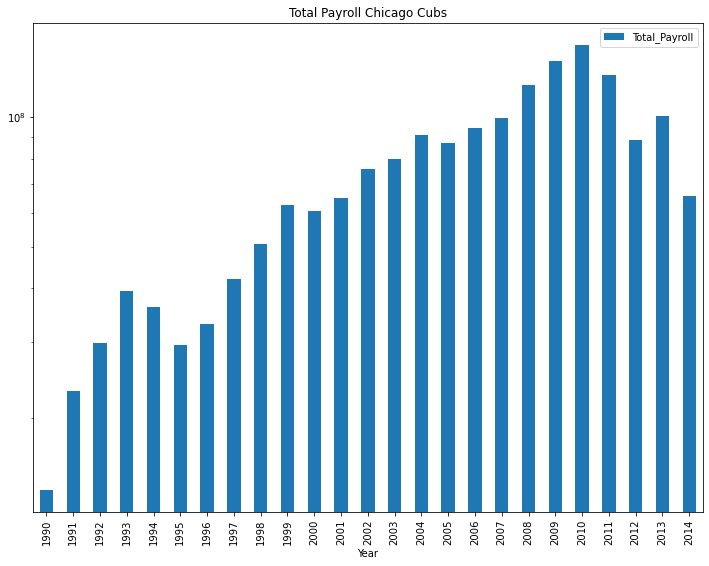

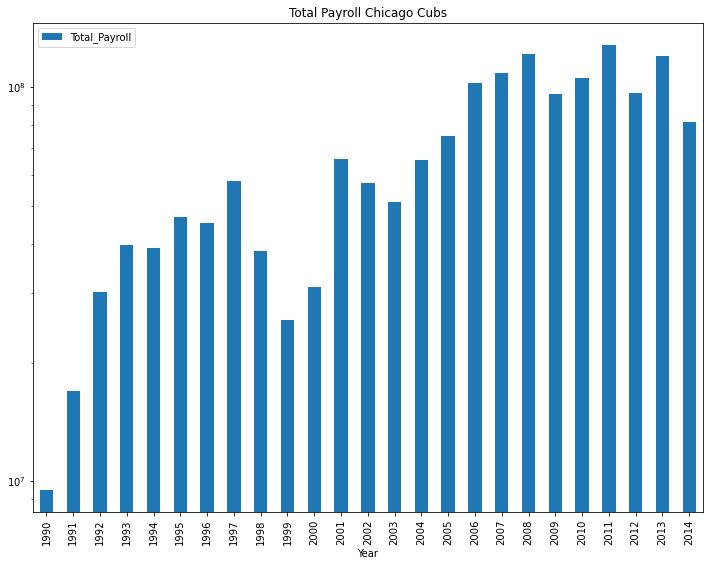

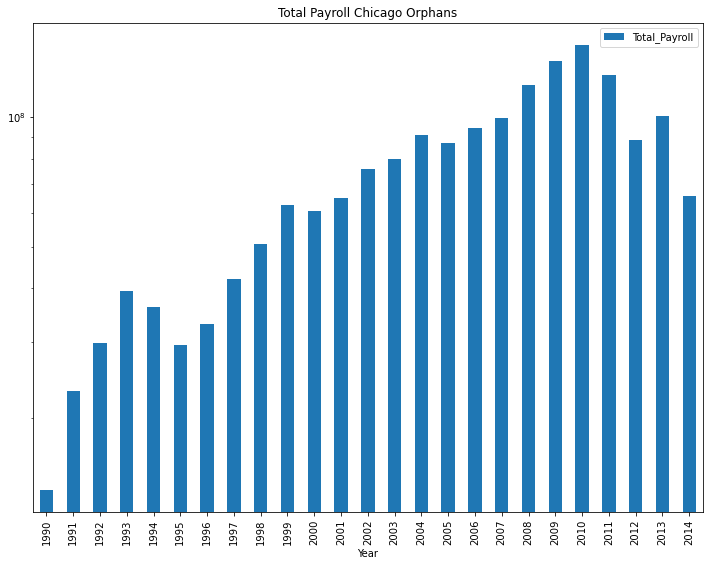

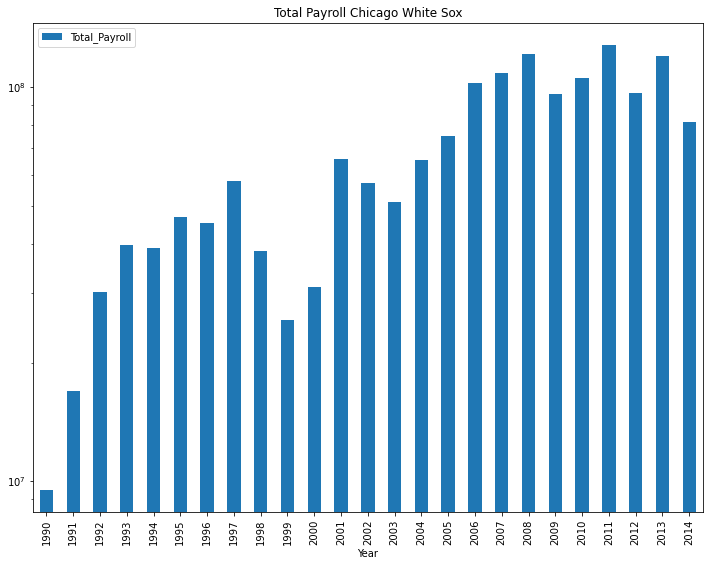

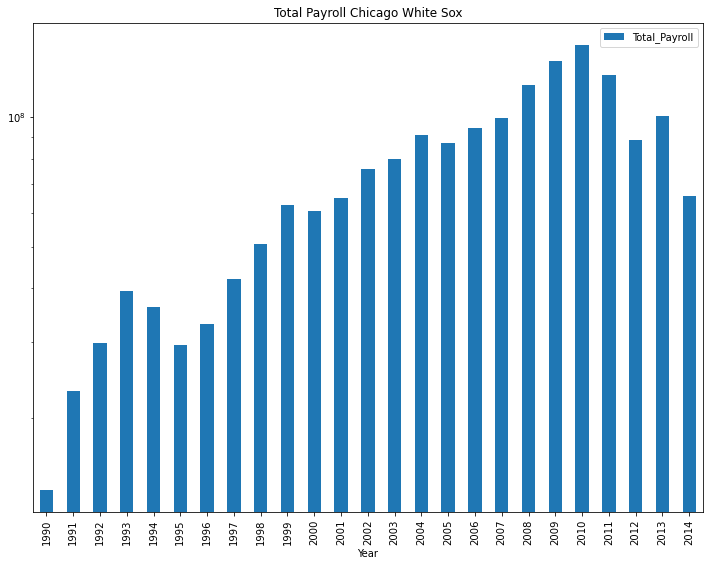

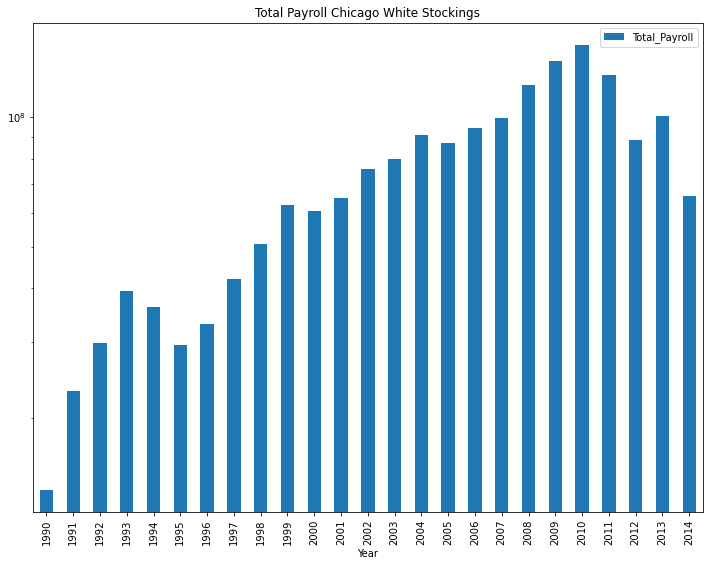

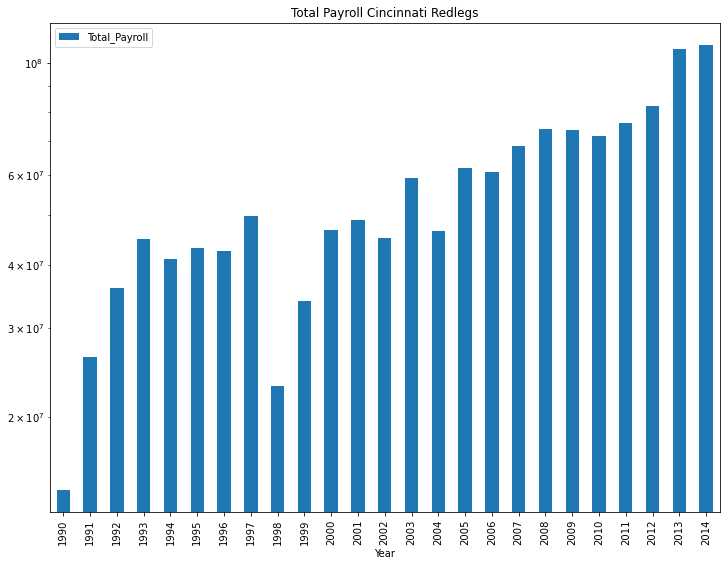

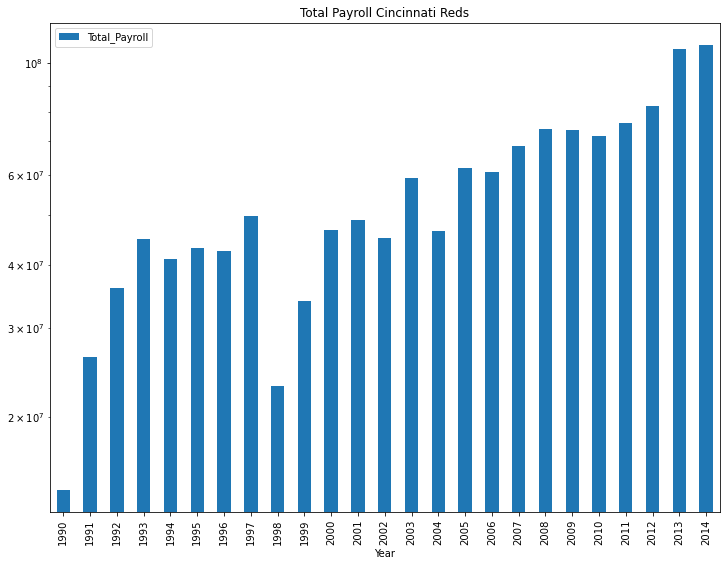

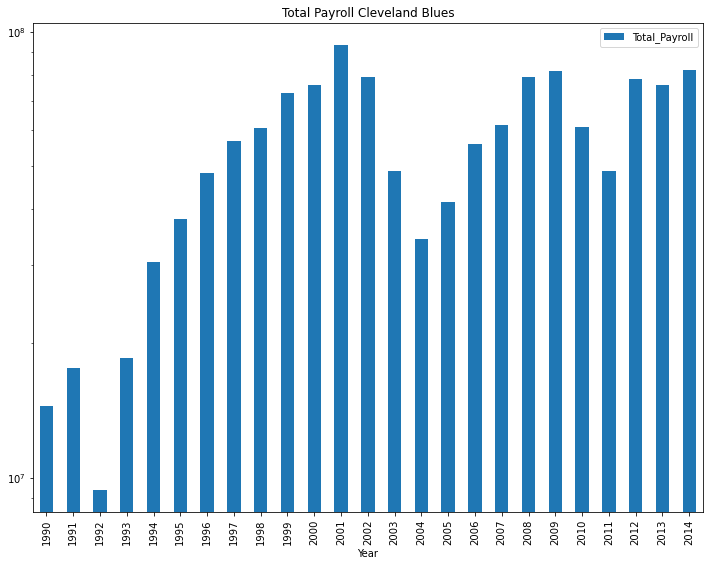

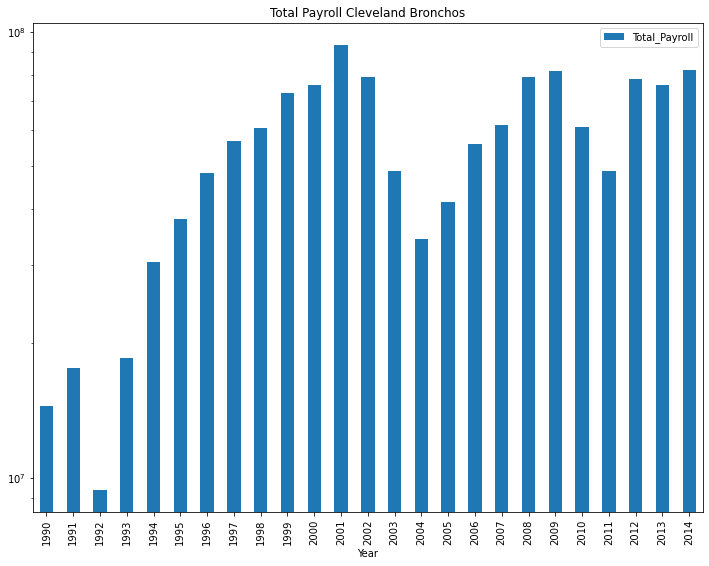

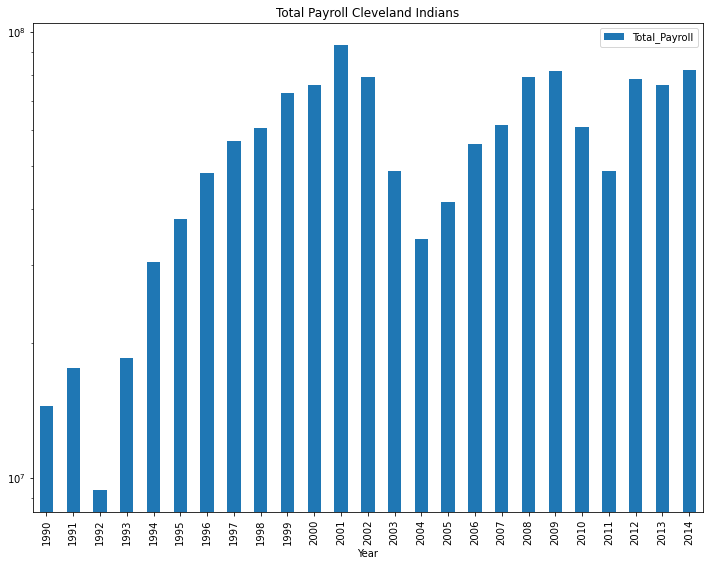

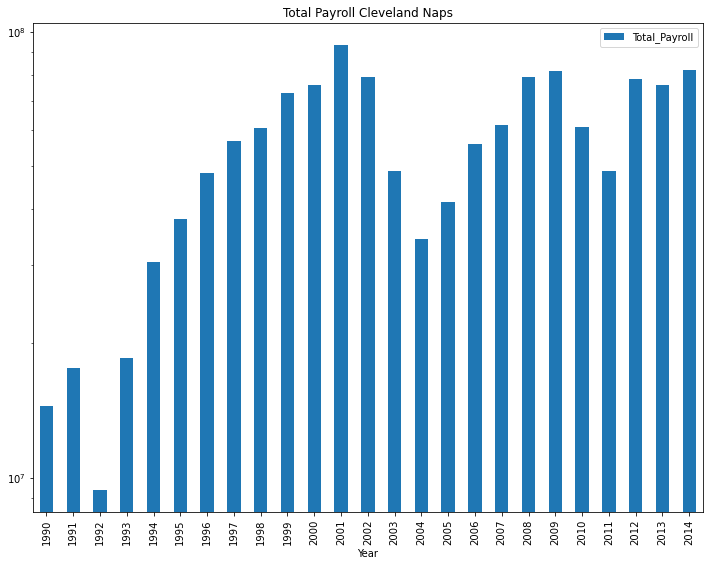

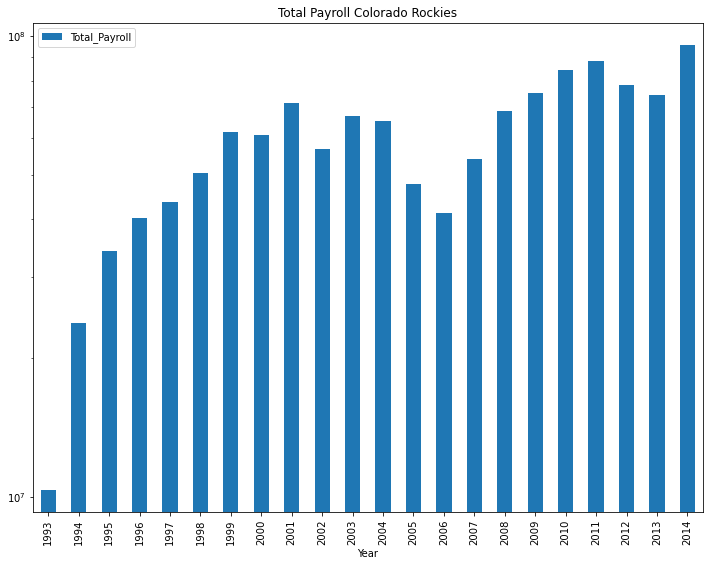

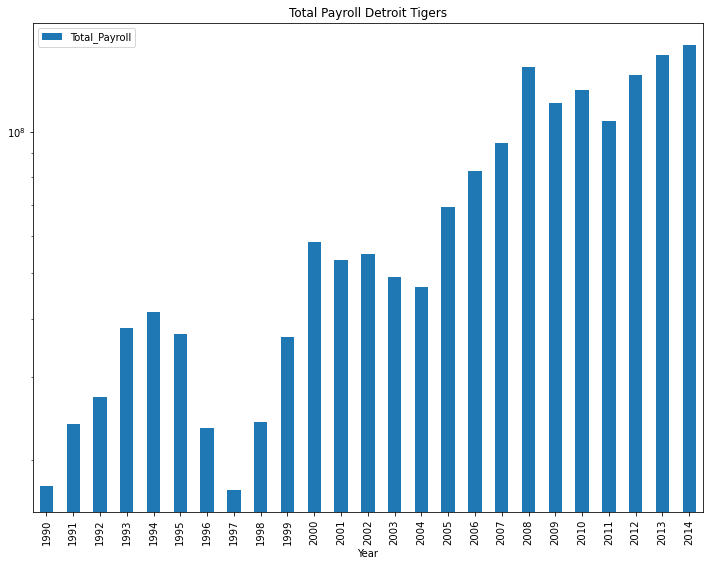

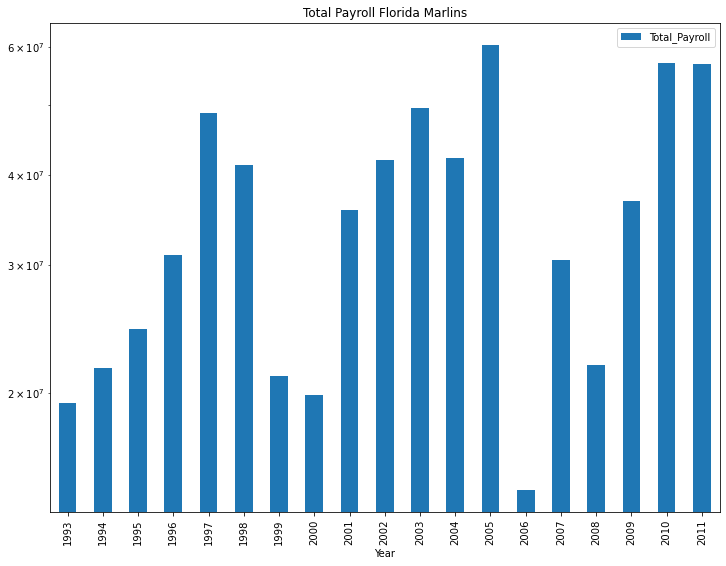

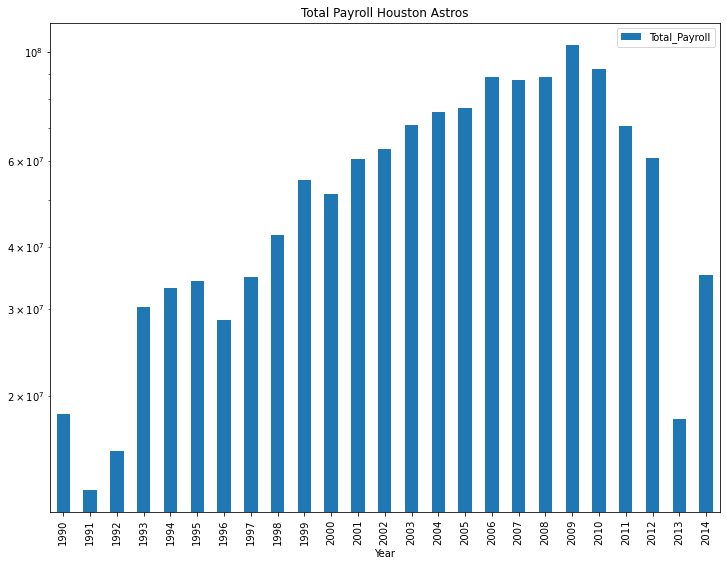

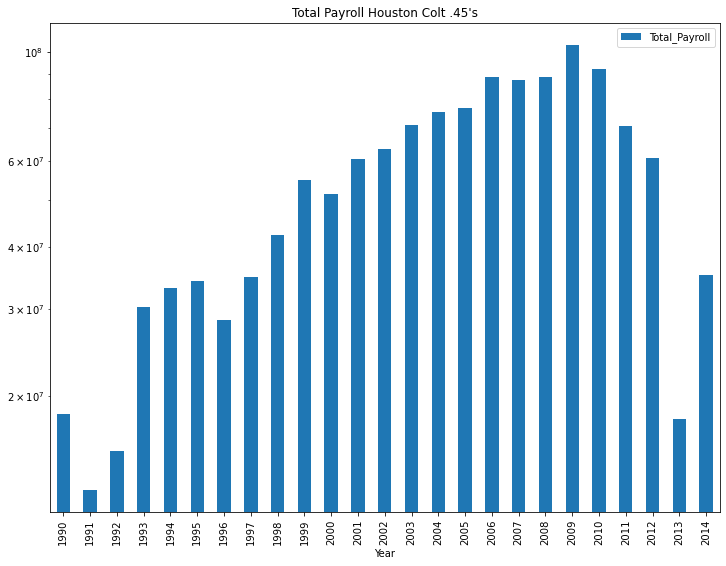

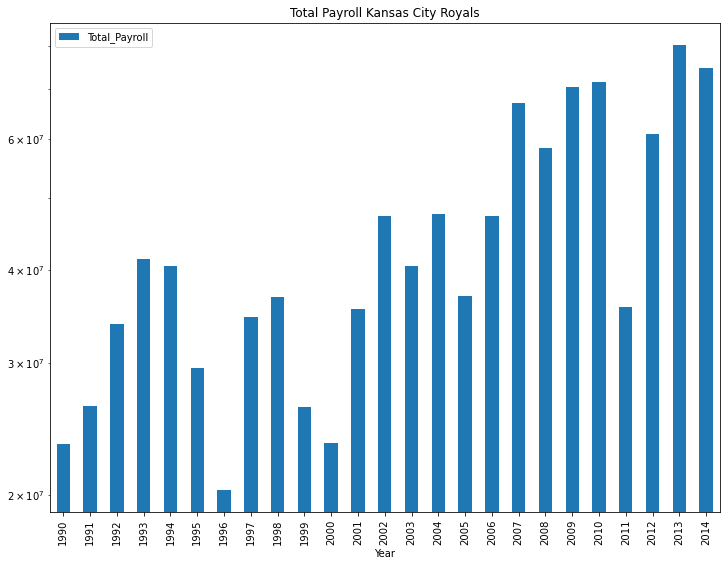

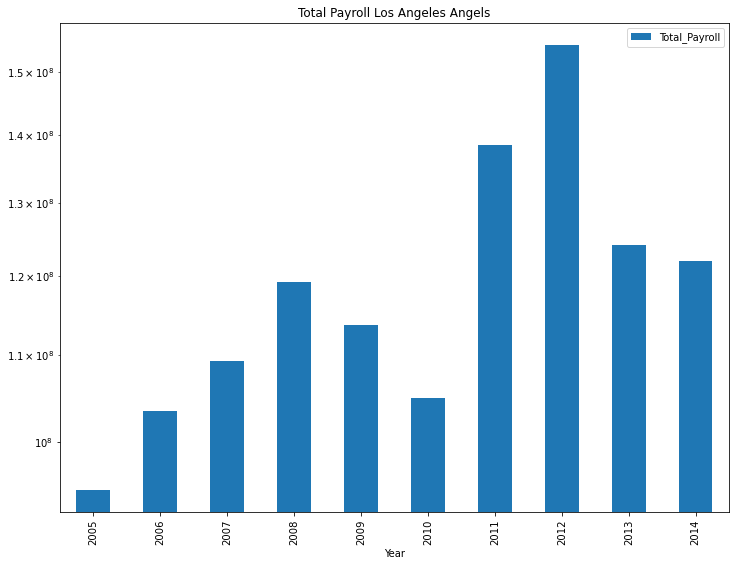

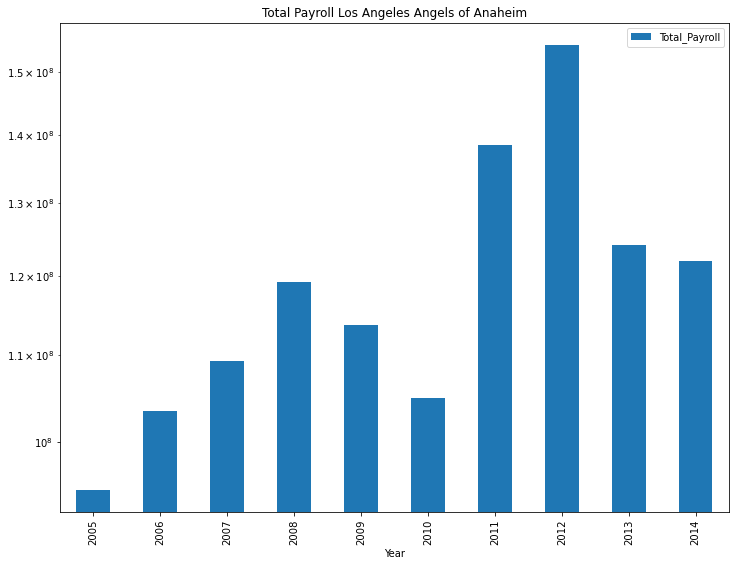

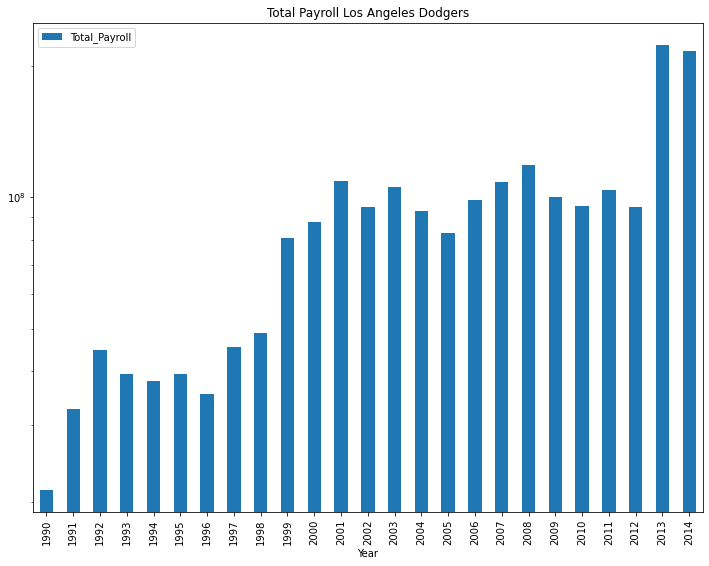

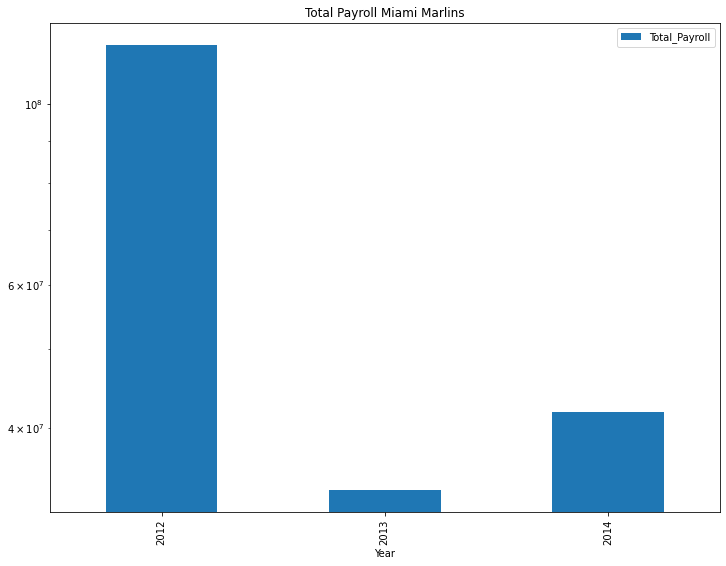

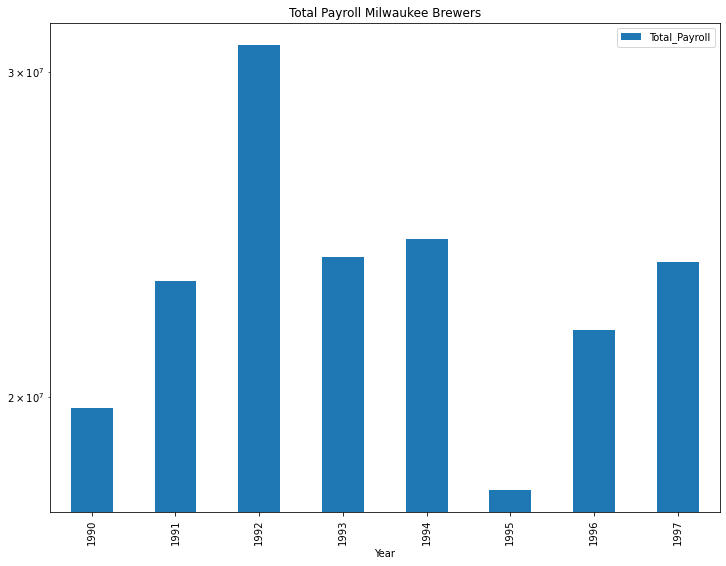

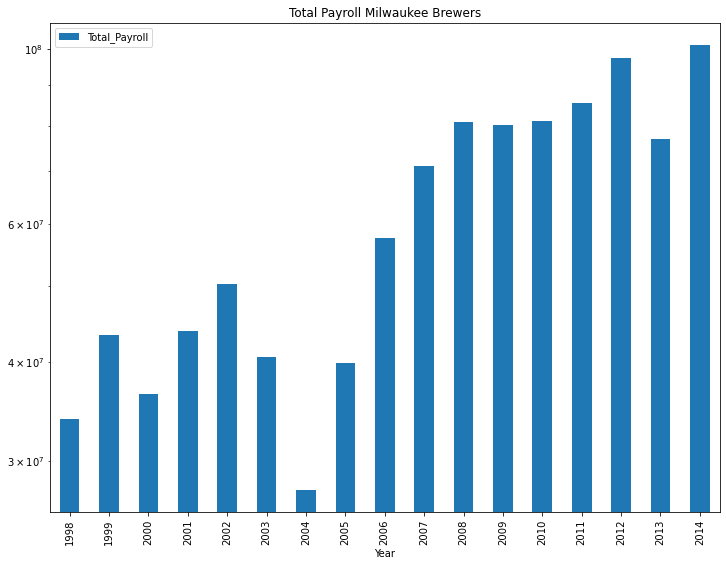

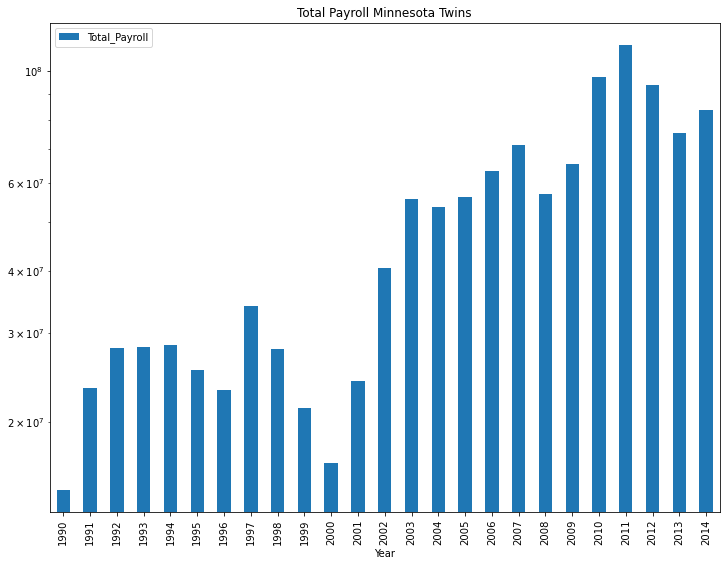

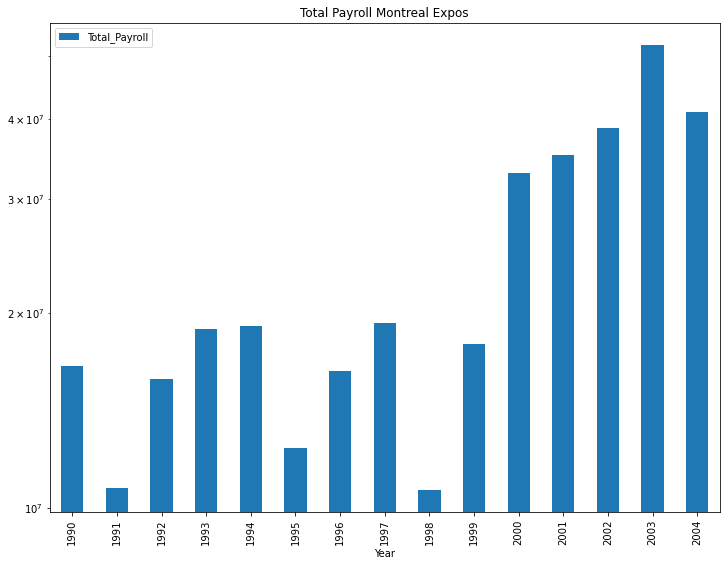

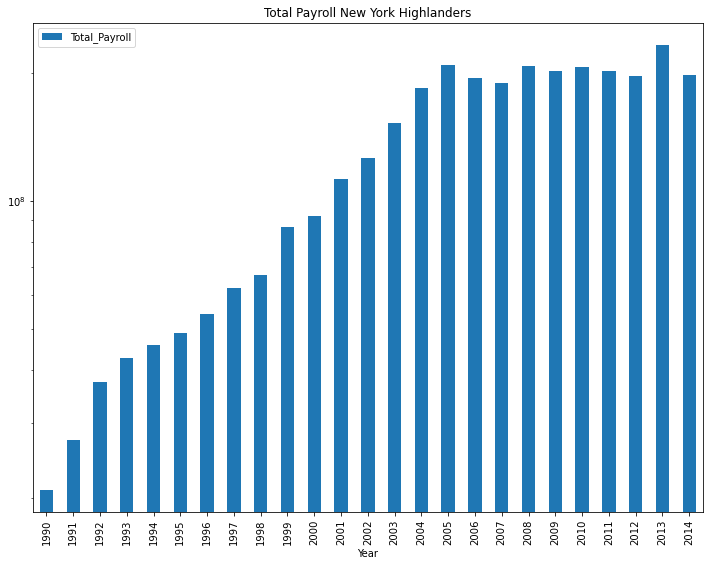

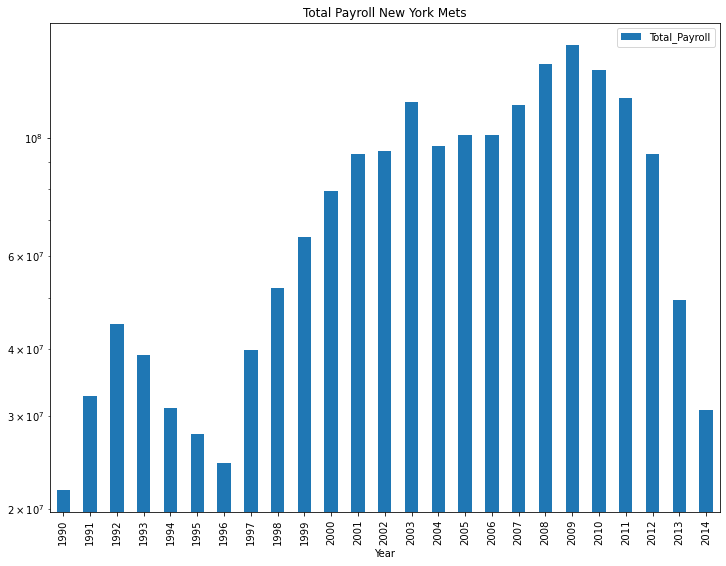

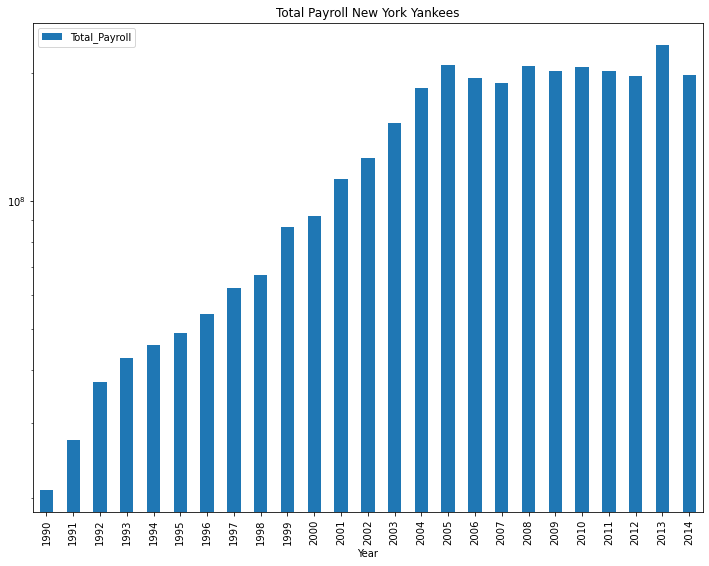

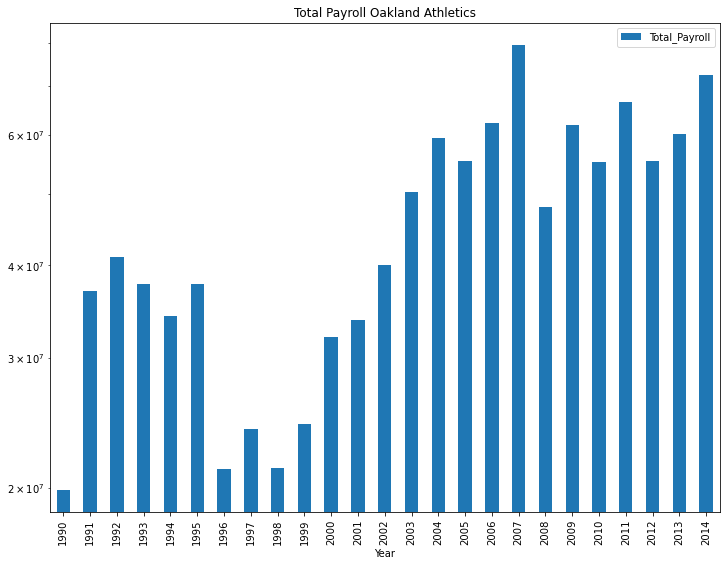

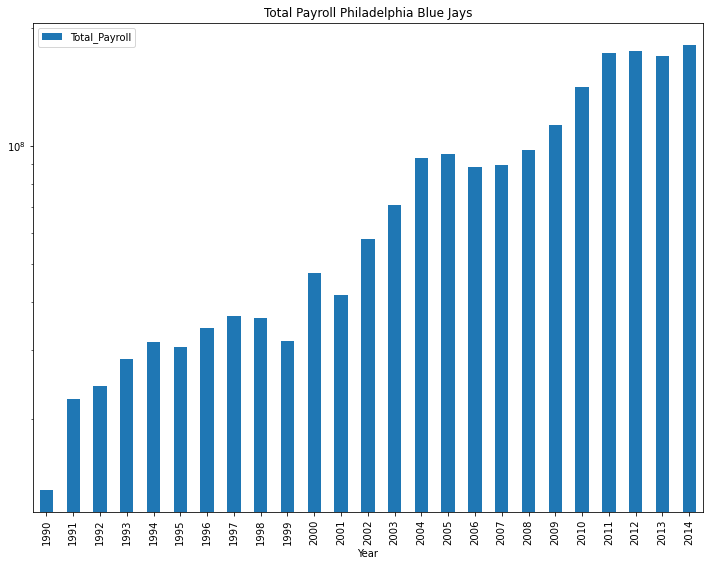

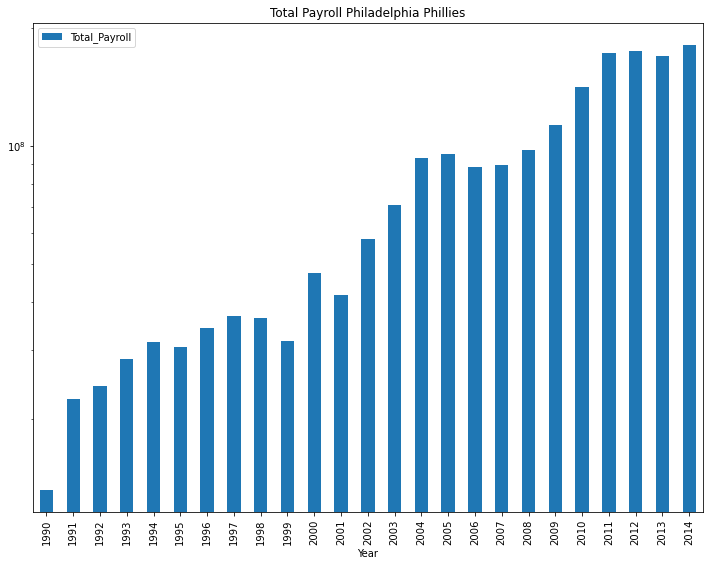

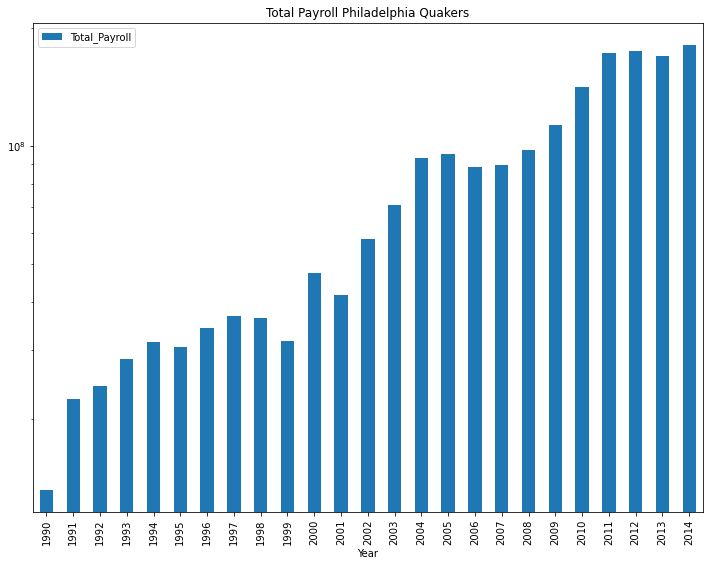

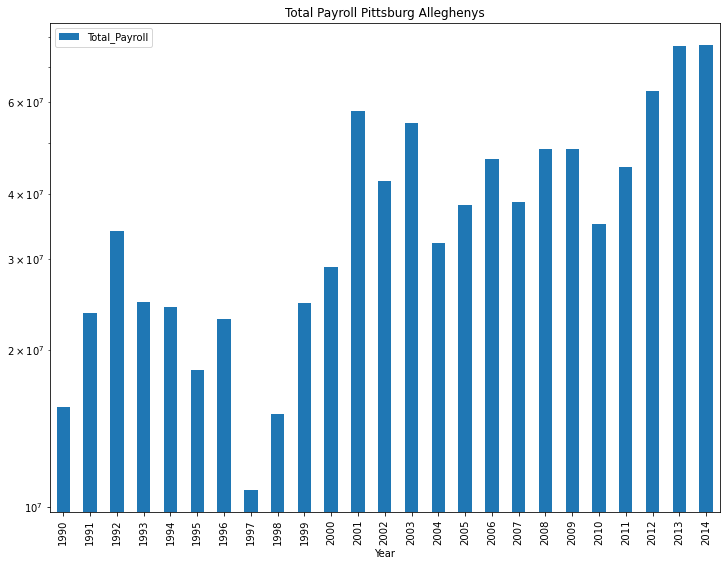

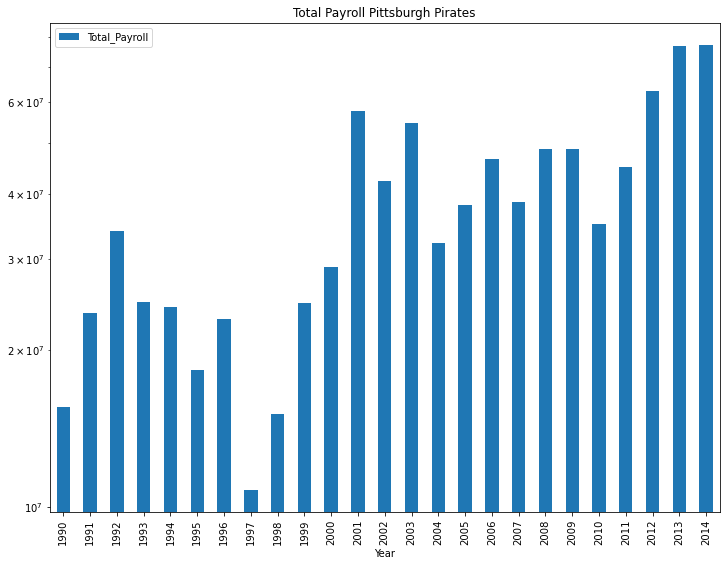

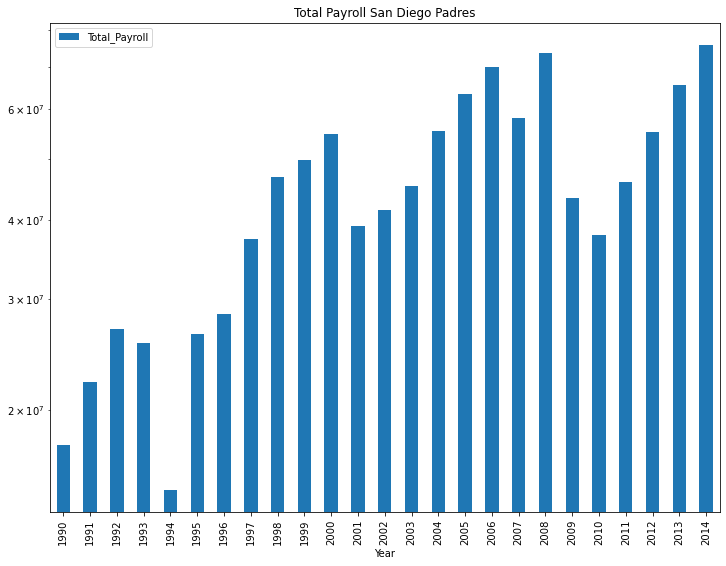

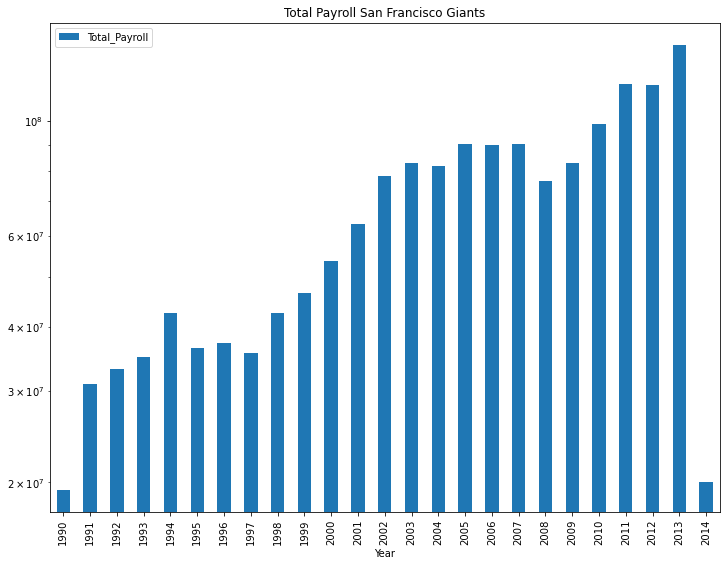

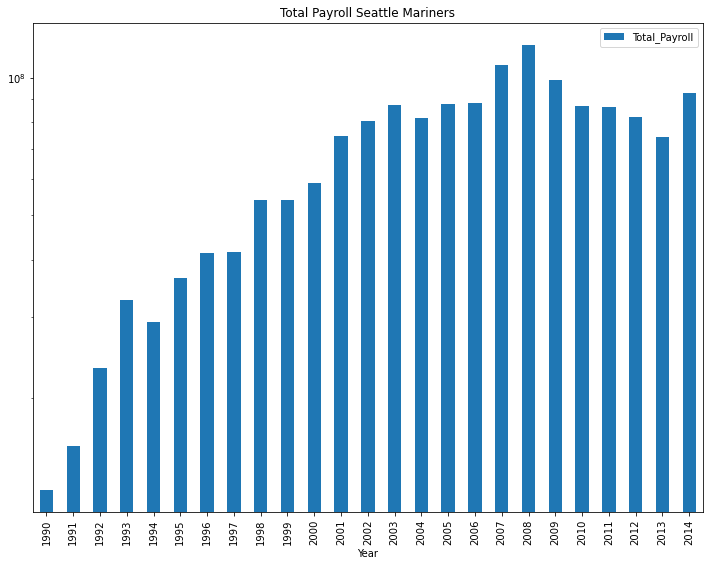

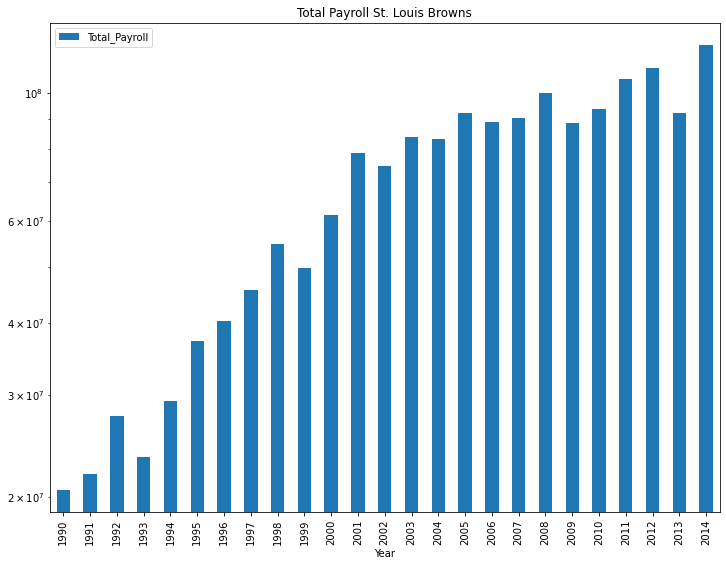

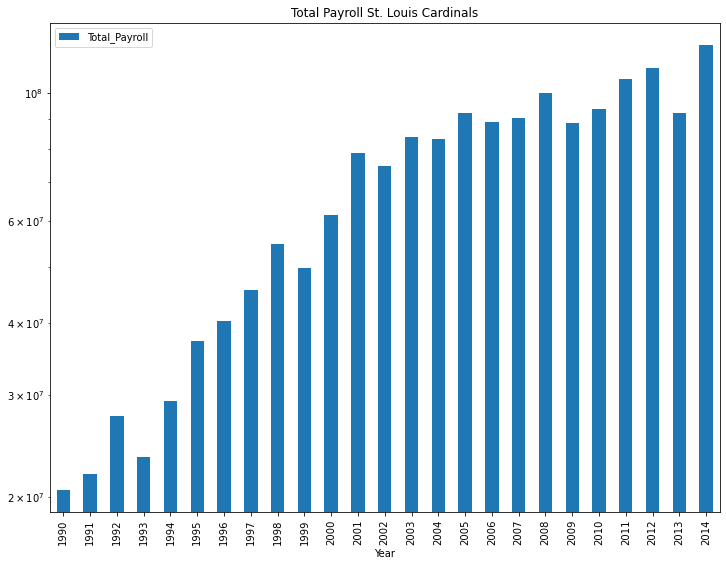

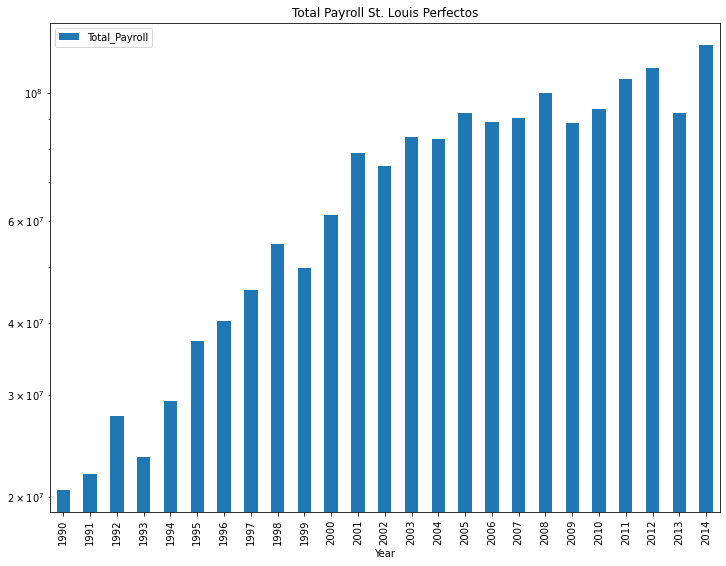

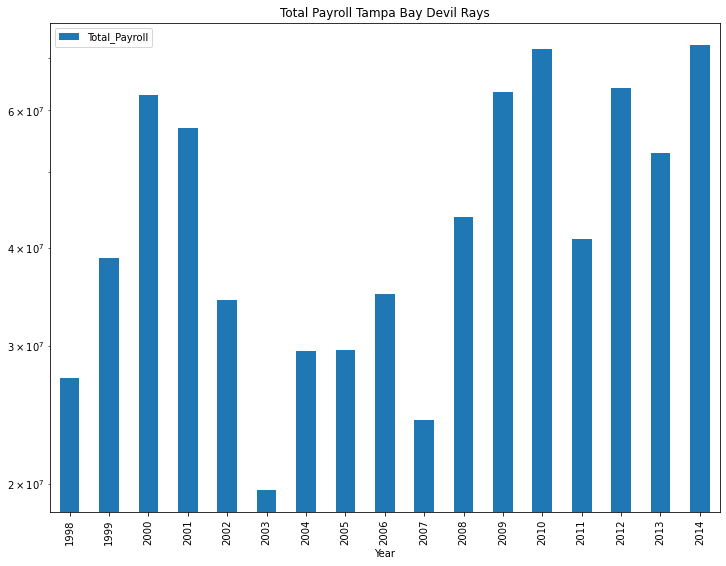

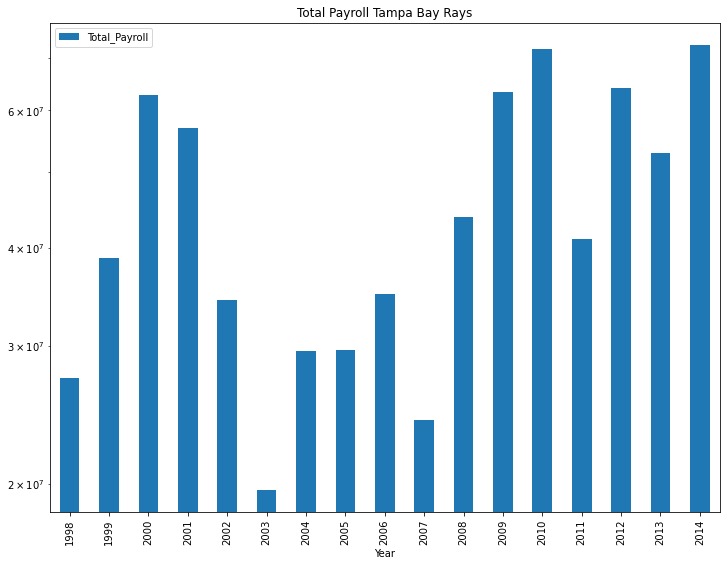

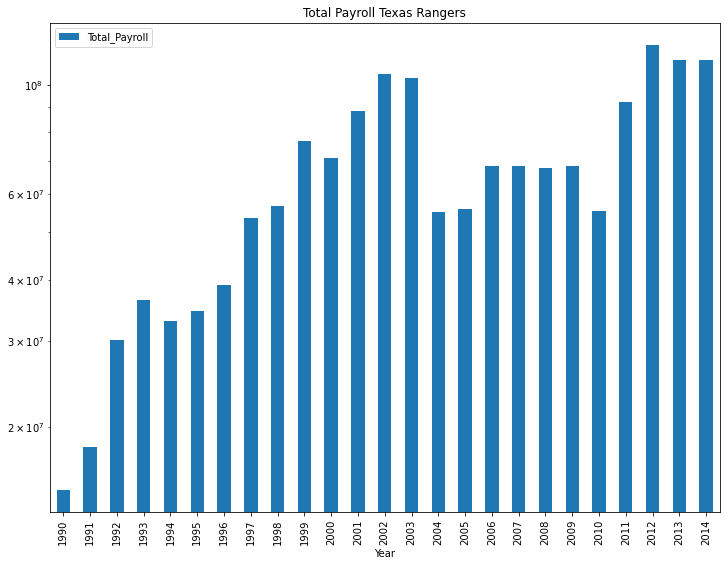

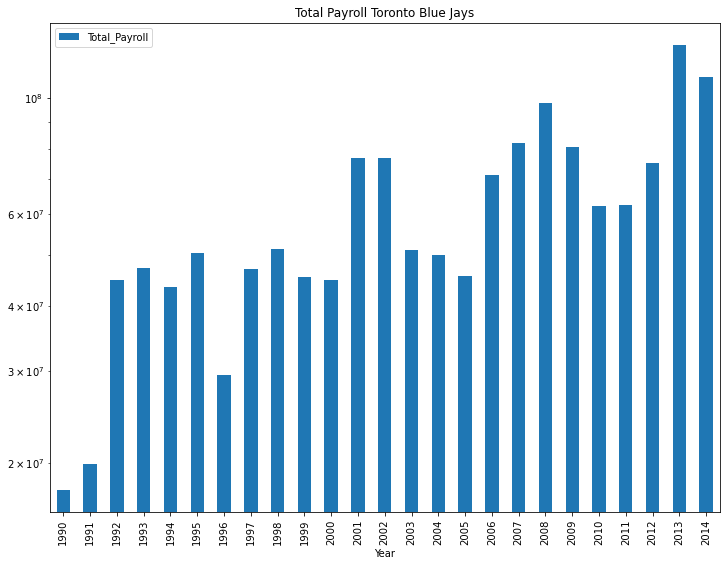

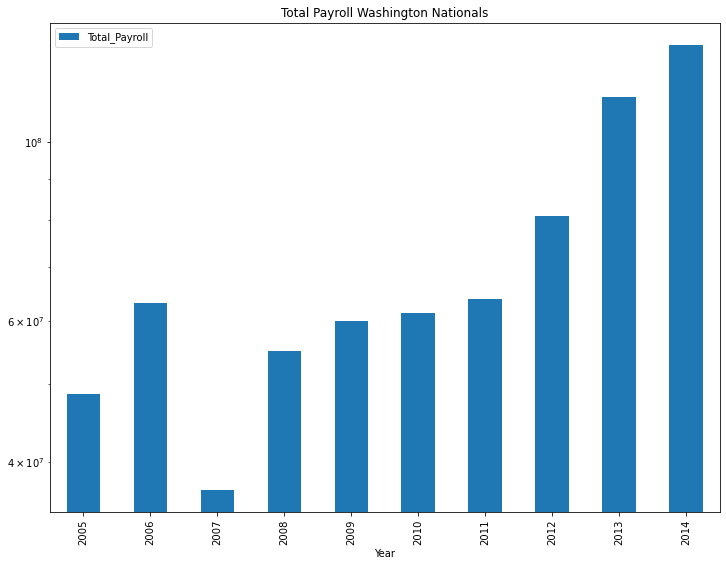

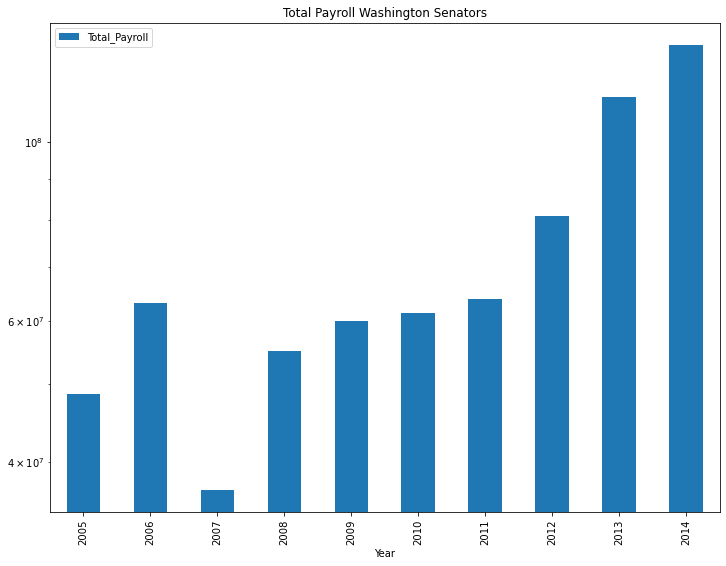

In [416]:
num_results = len(result_frames_objects)
#prevents warning after 20 figures shown
plt.rcParams.update({'figure.max_open_warning':0})
figsize = (12,9)
for i in range(num_results):
    dfr = result_frames_objects[i]
    team_name = team_names[i]
    team_id = team_ids[i]
    #we only plot if the data frame in 
    #question is not empty
    if not dfr.empty: 
        dfr.plot(x='Year', y='Total_Payroll', logy=True, \
                  title = 'Total Payroll ' + team_name, kind='bar',figsize=figsize)
       
        #fig = plt.figure((i+1))
        #ax = fig.add_subplot(111)
        #image_name = 'figs/graph_{}_{}.png'.format(team_id, i)
        
        #fig.savefig(image_name)
        #plt.close(fig)

## Observations about the plots : 
### Over time, the payroll has increased for most of the teams.
### The average and total payroll have increased steadily over time.

Here is a plot of the sums and the average over the years for each team. The bar plots below show an increasing trend. 

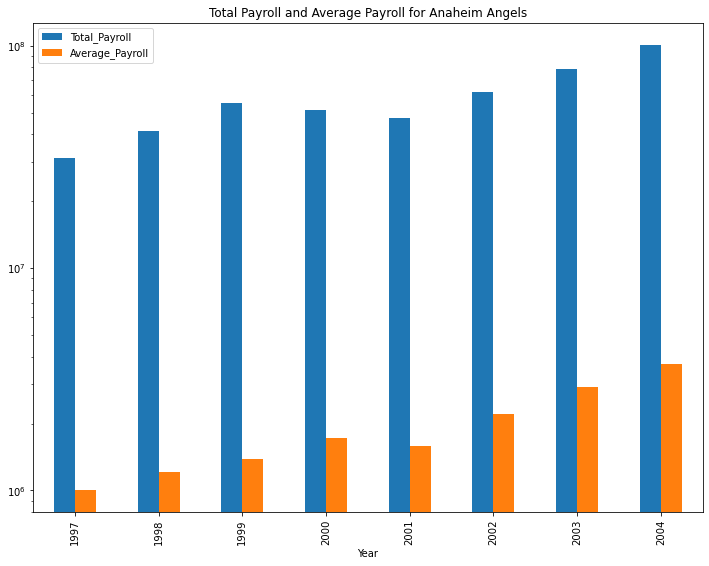

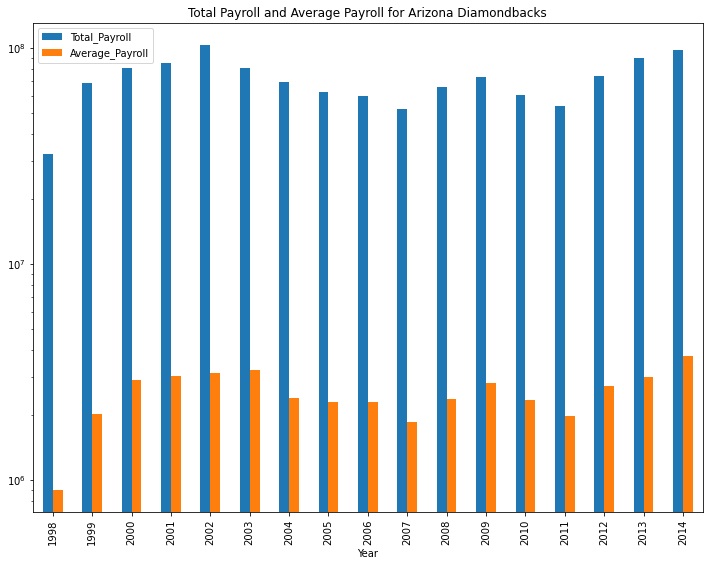

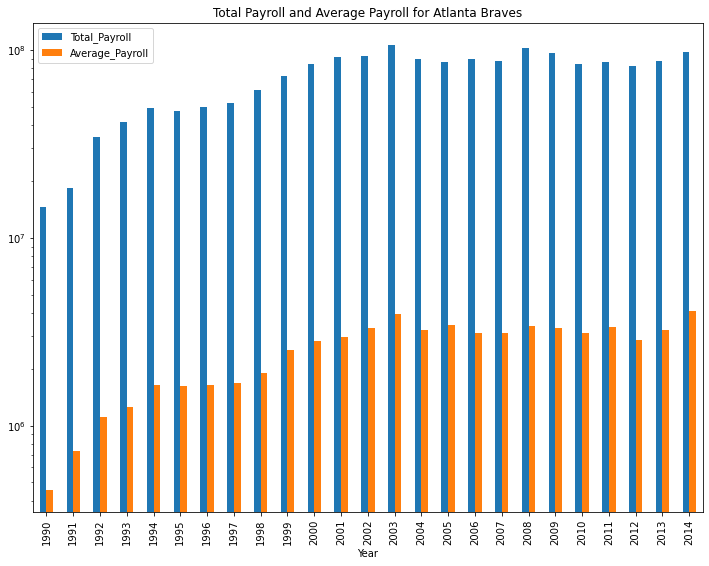

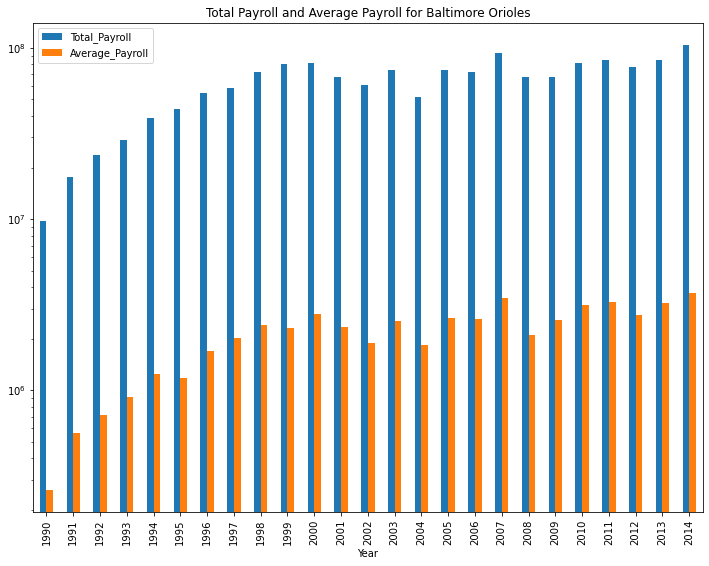

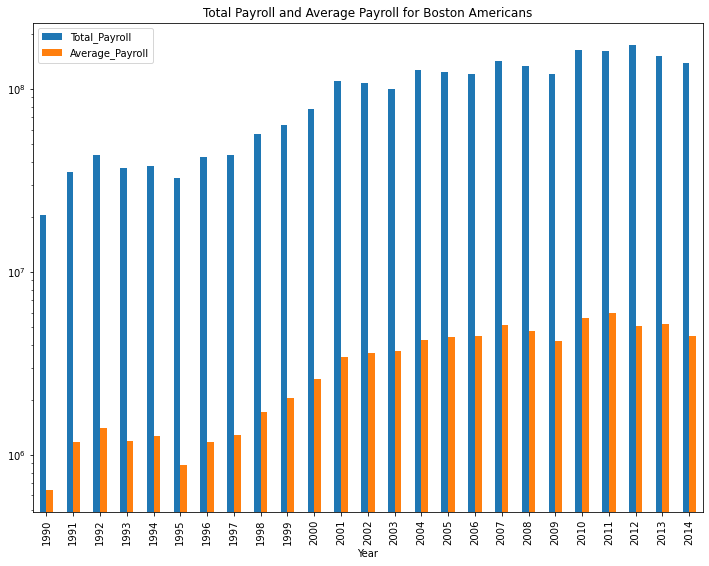

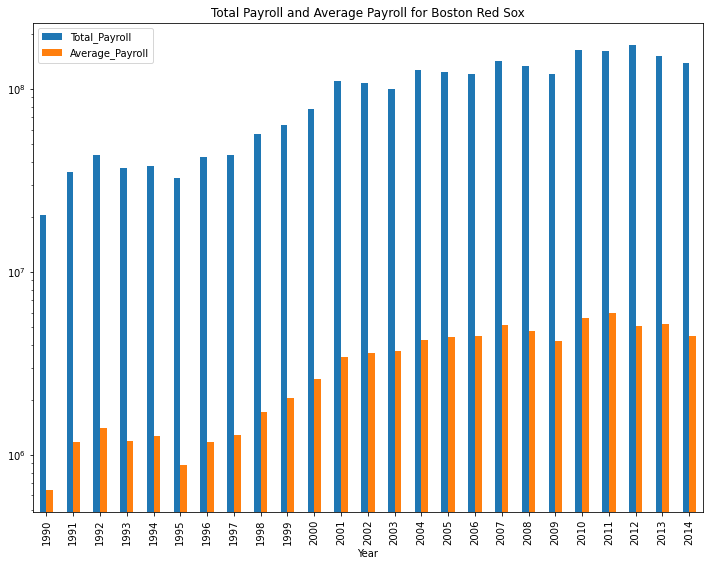

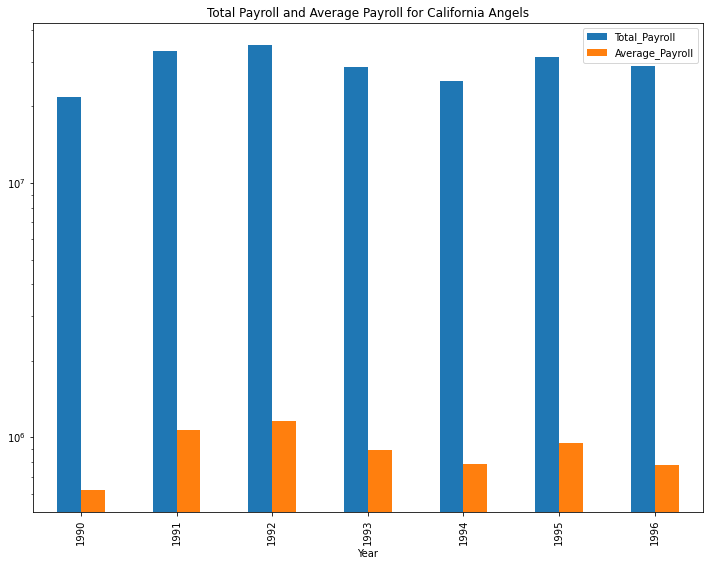

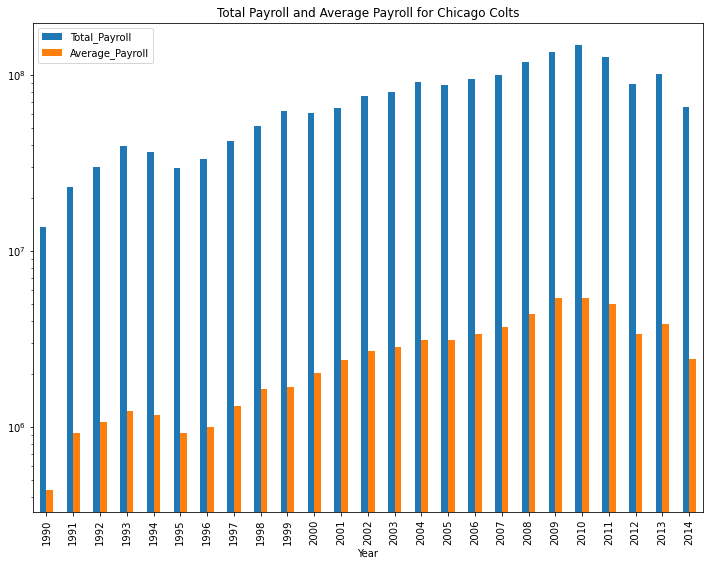

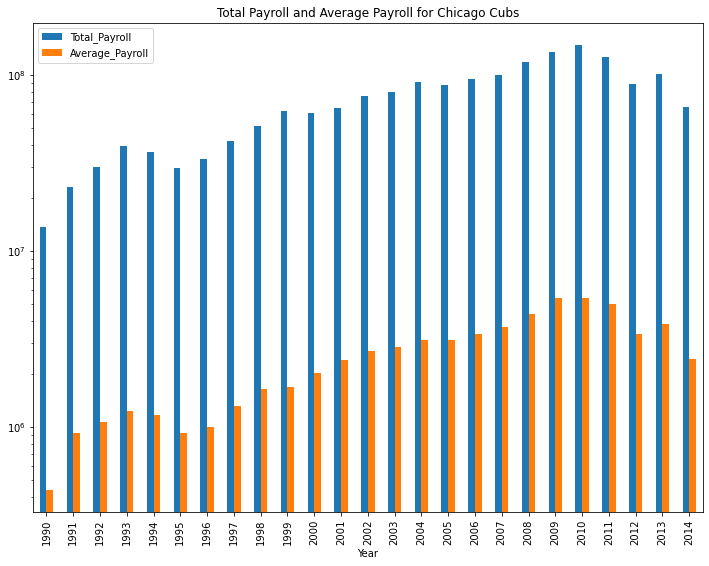

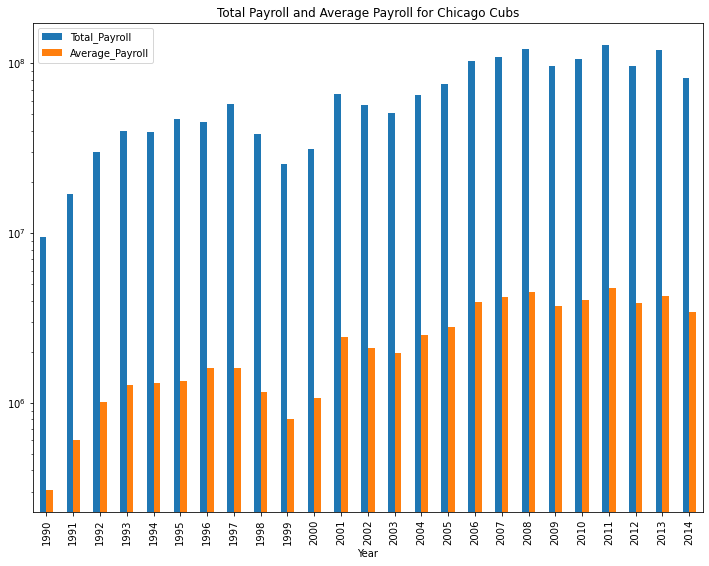

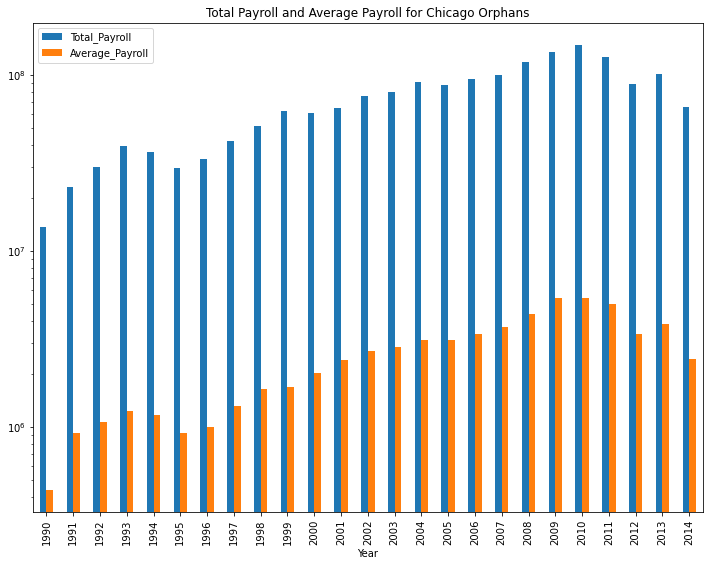

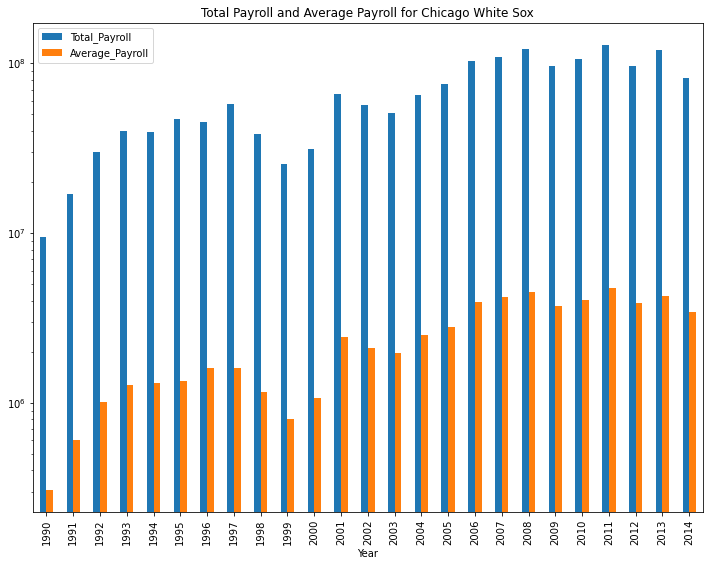

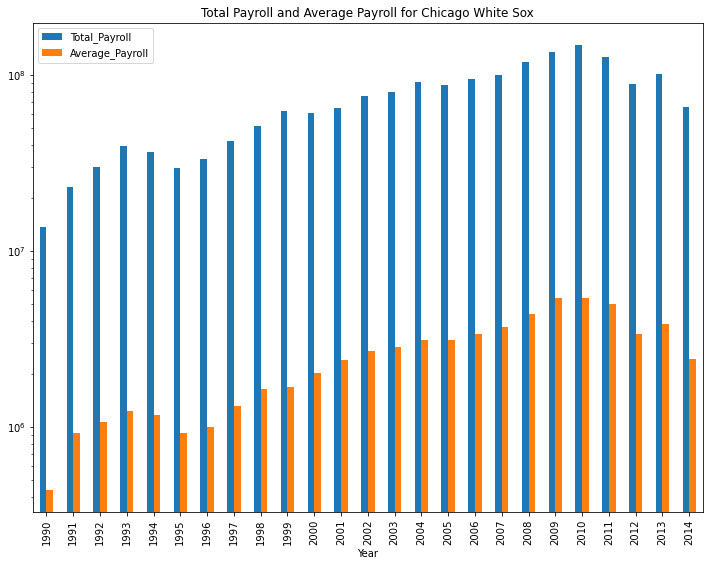

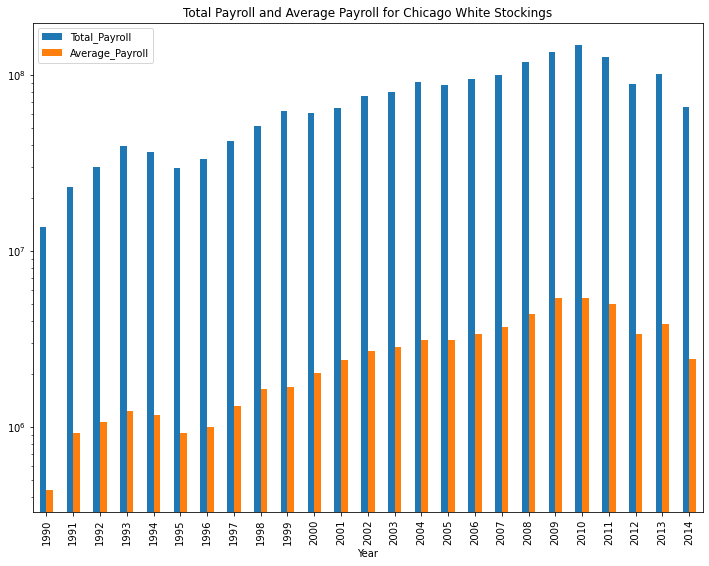

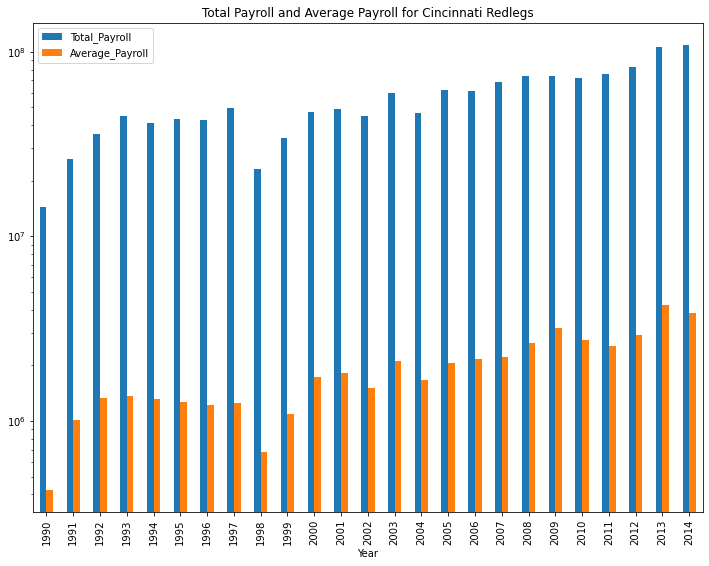

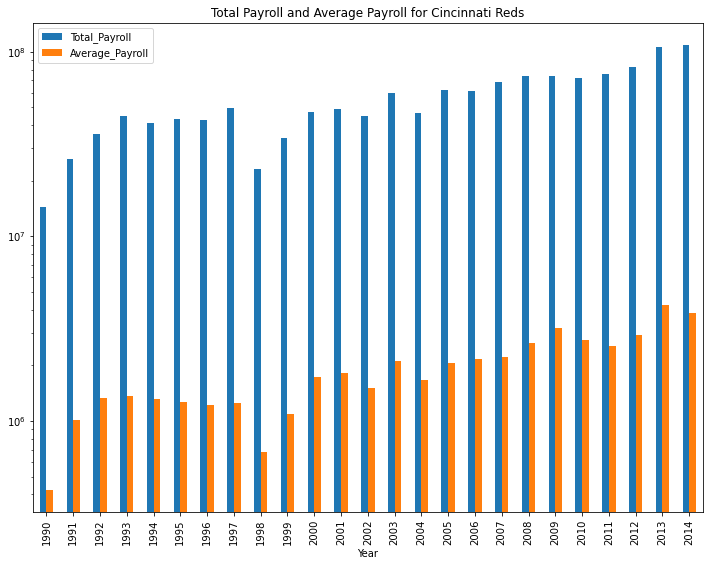

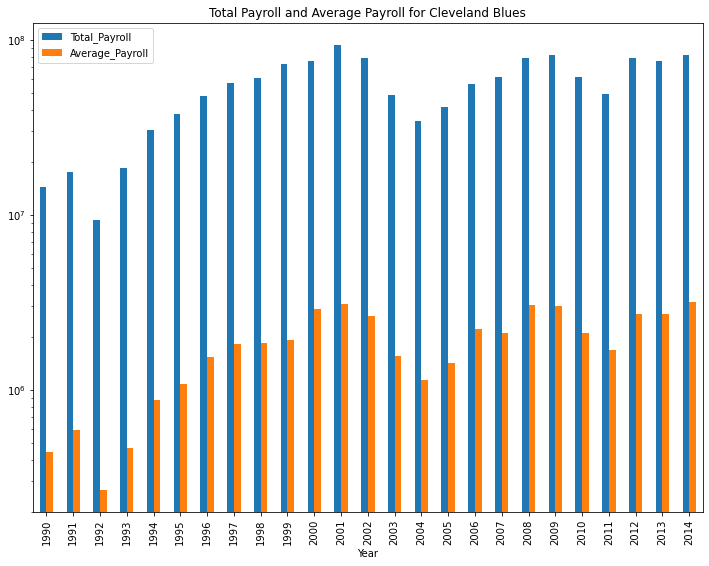

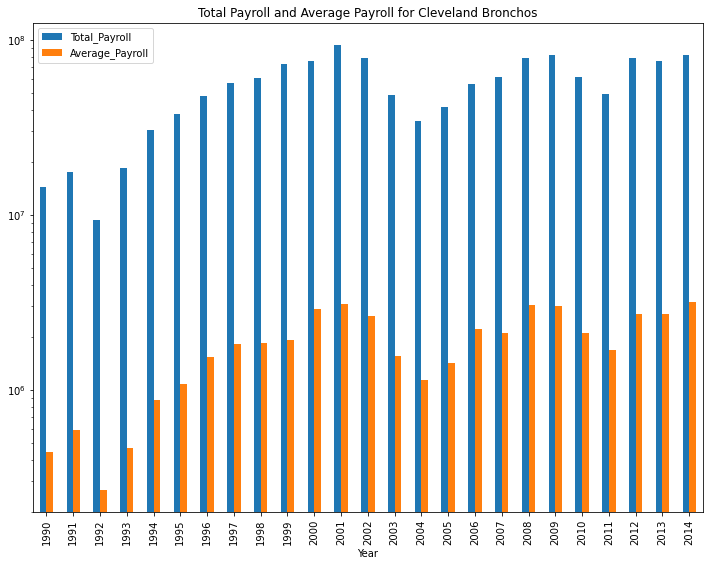

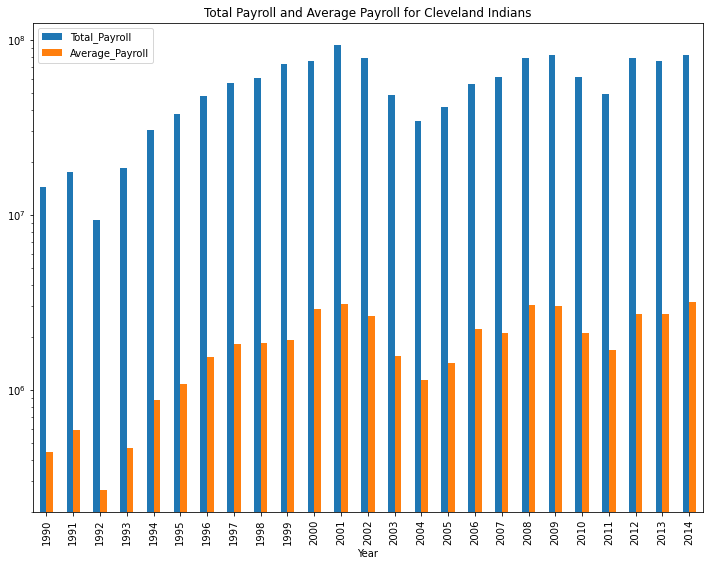

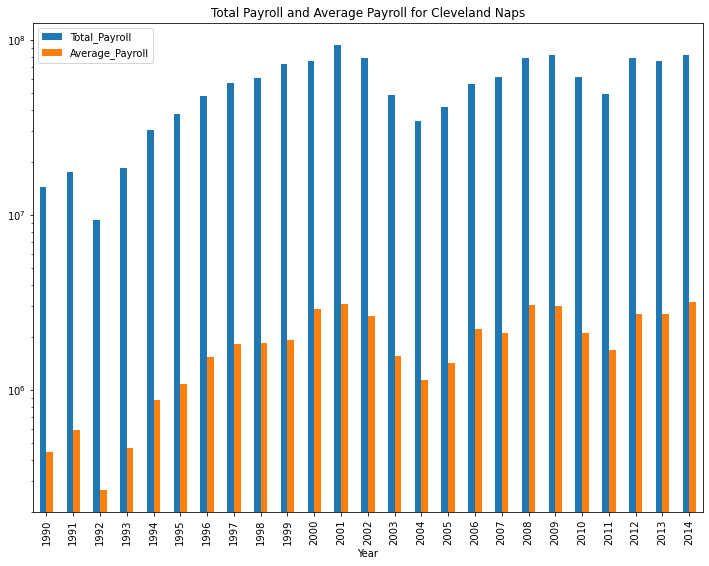

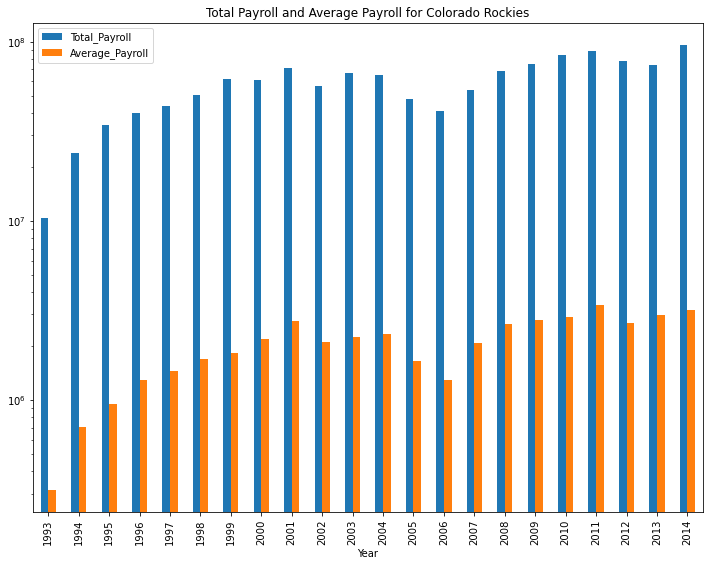

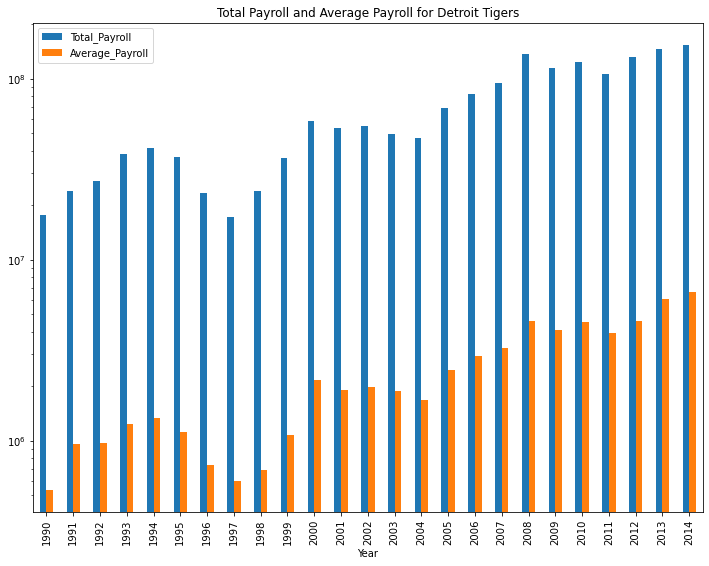

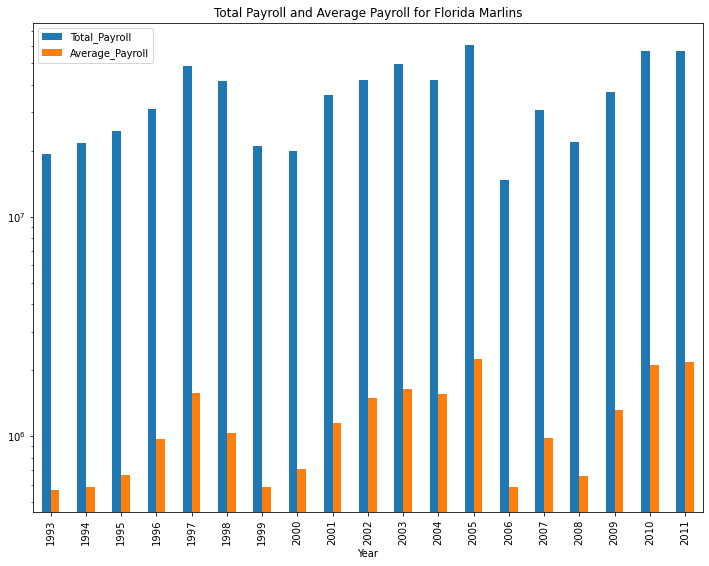

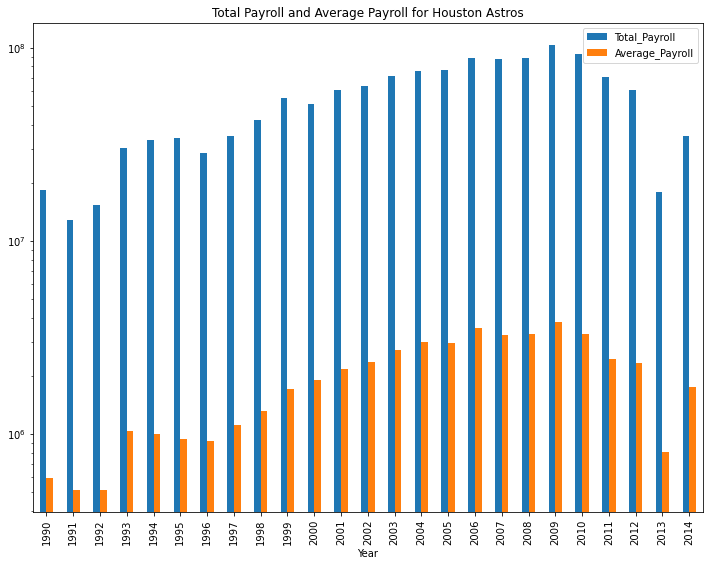

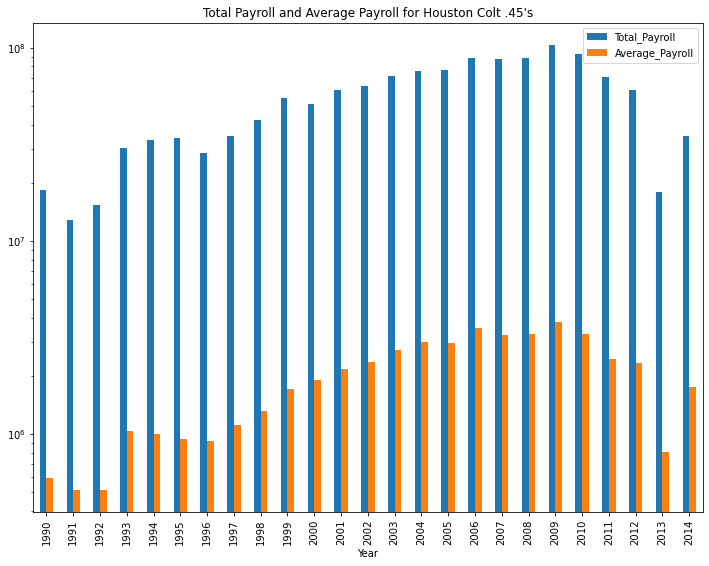

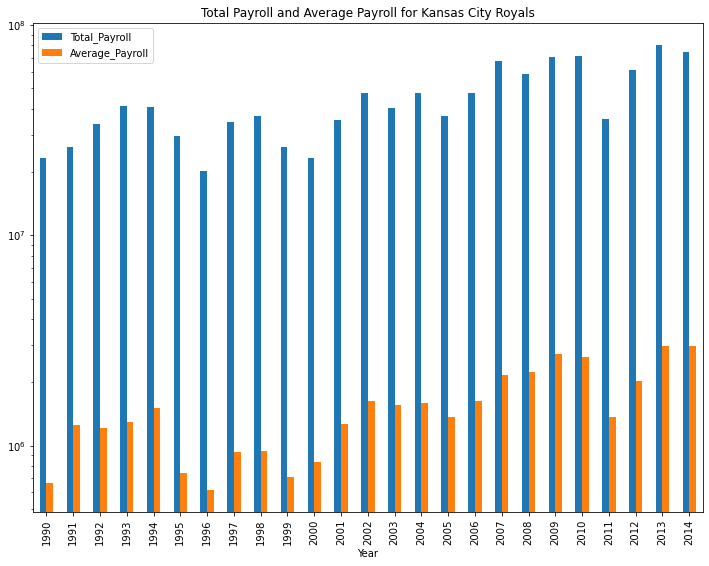

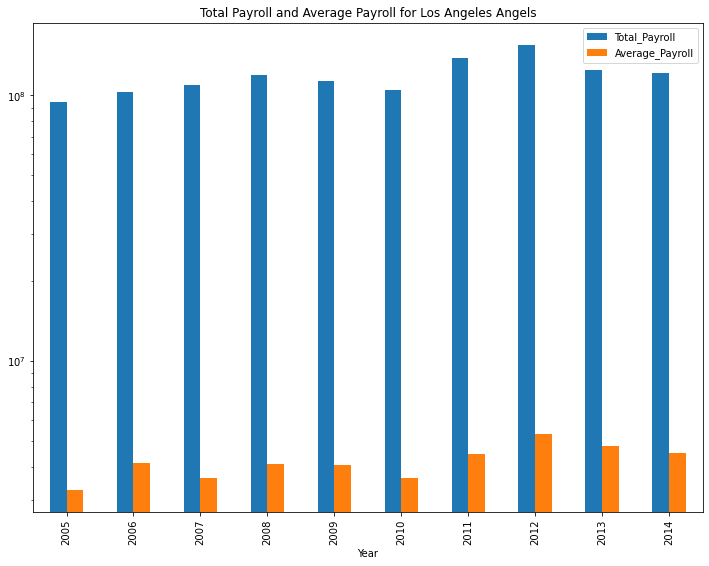

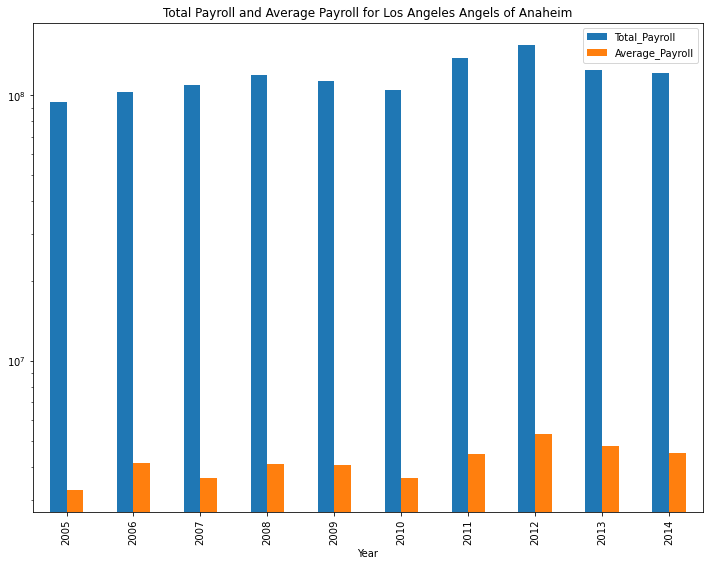

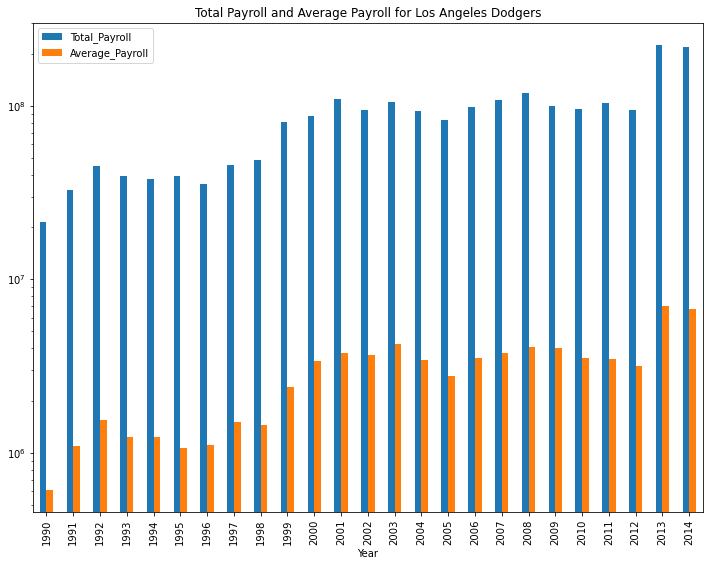

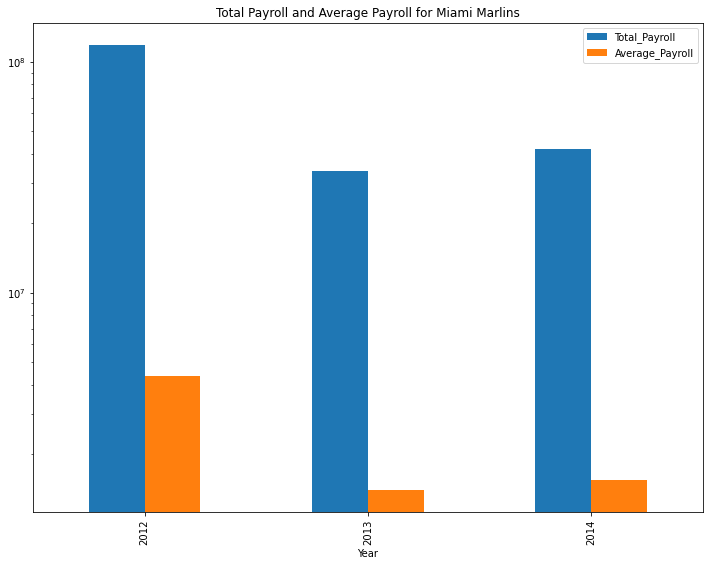

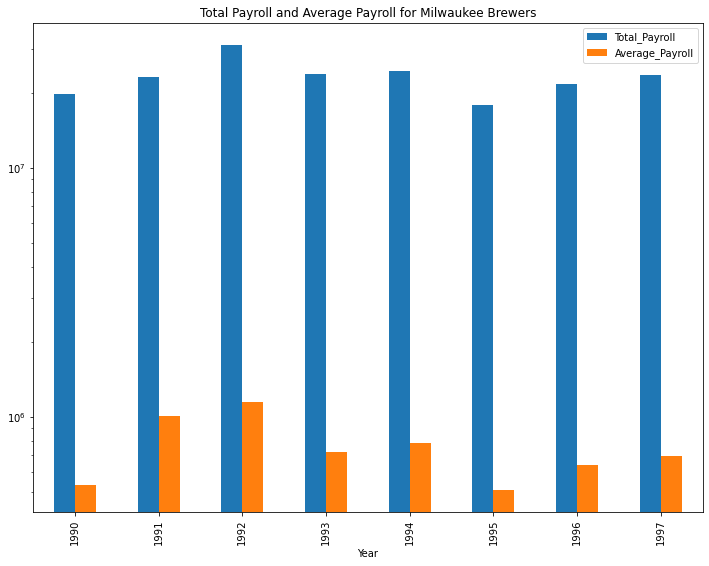

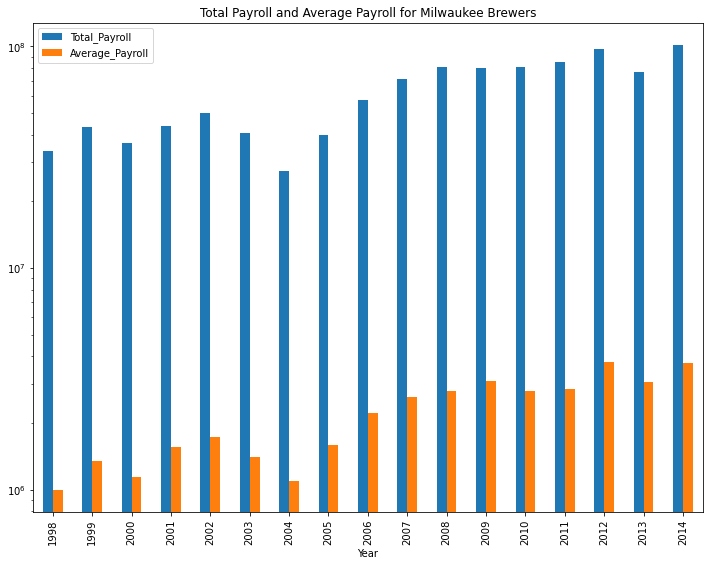

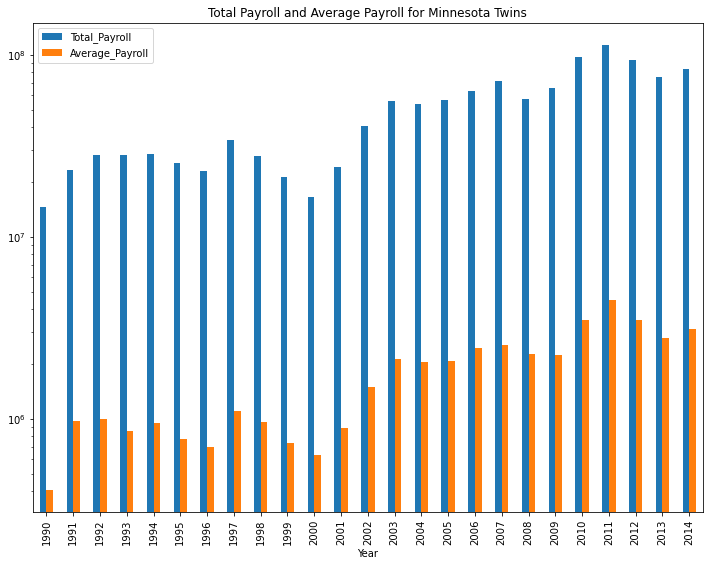

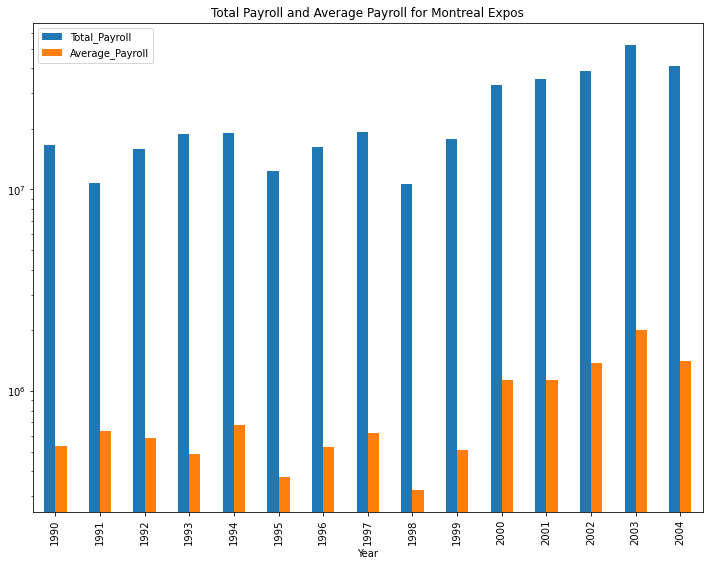

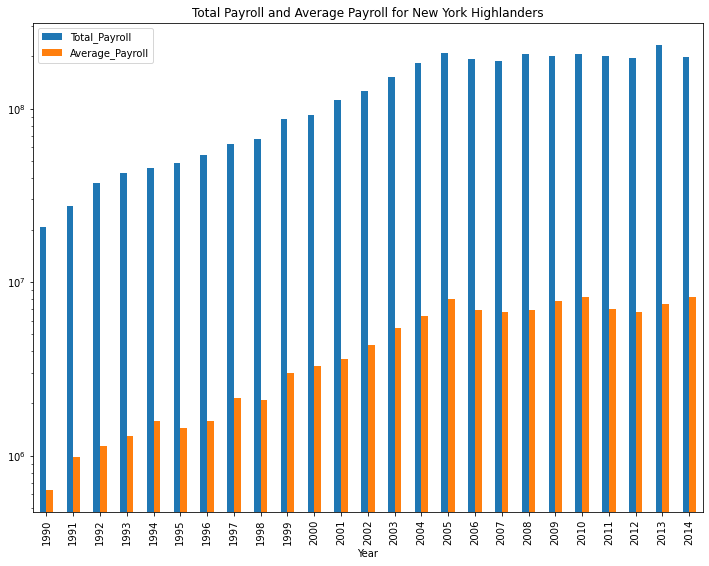

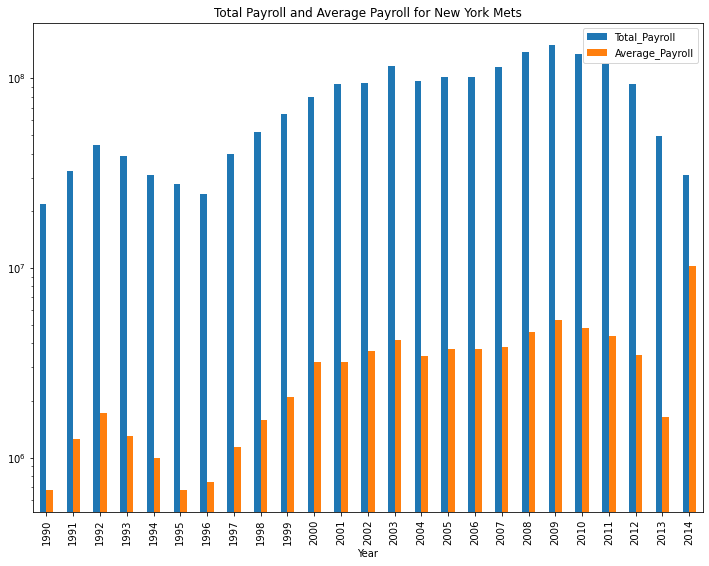

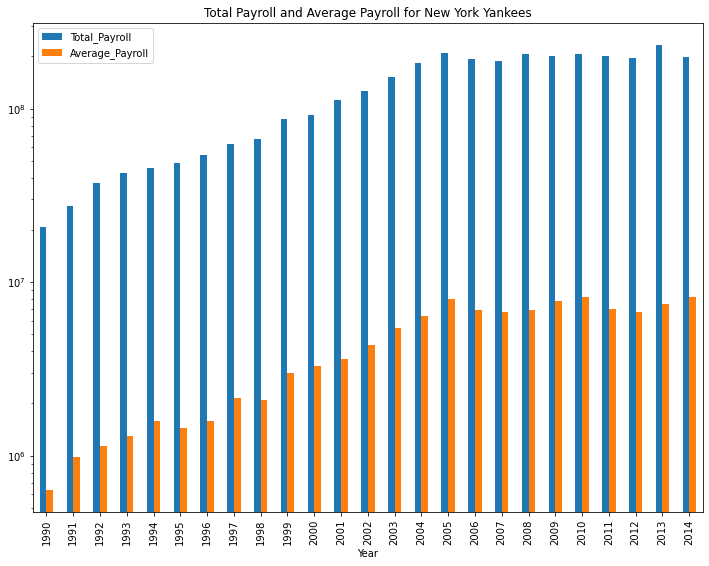

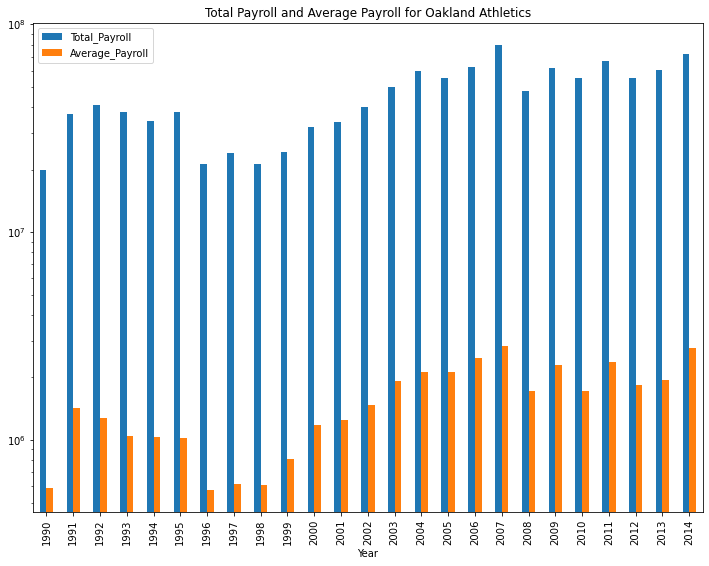

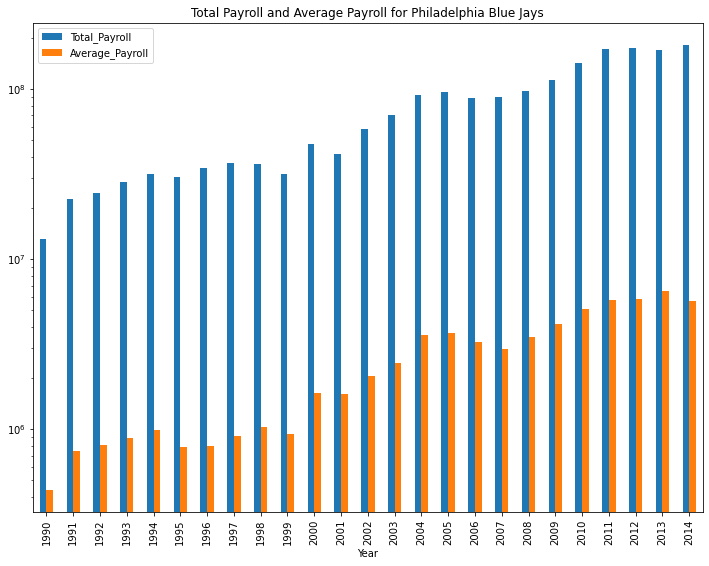

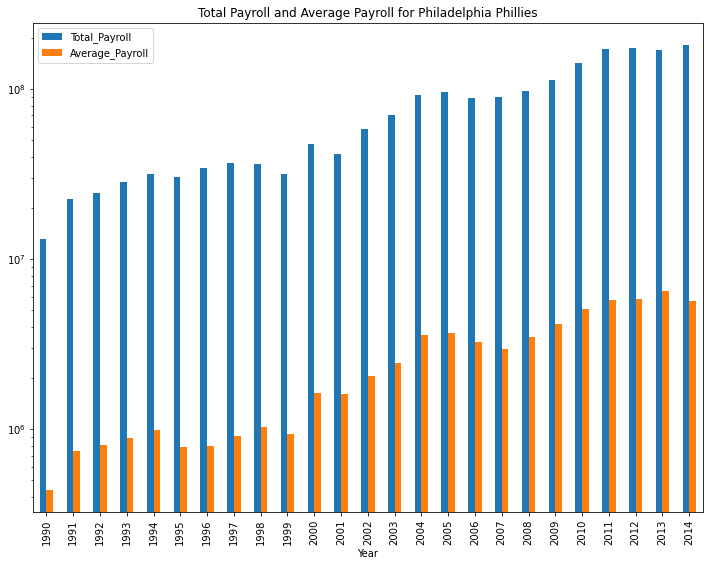

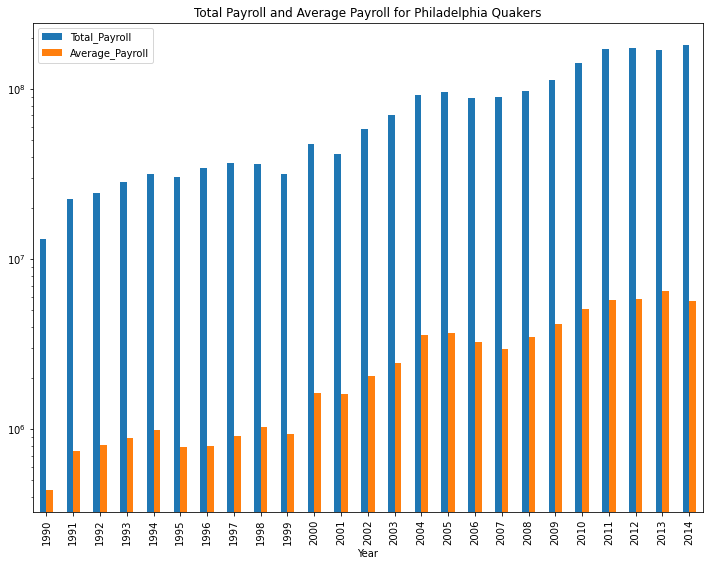

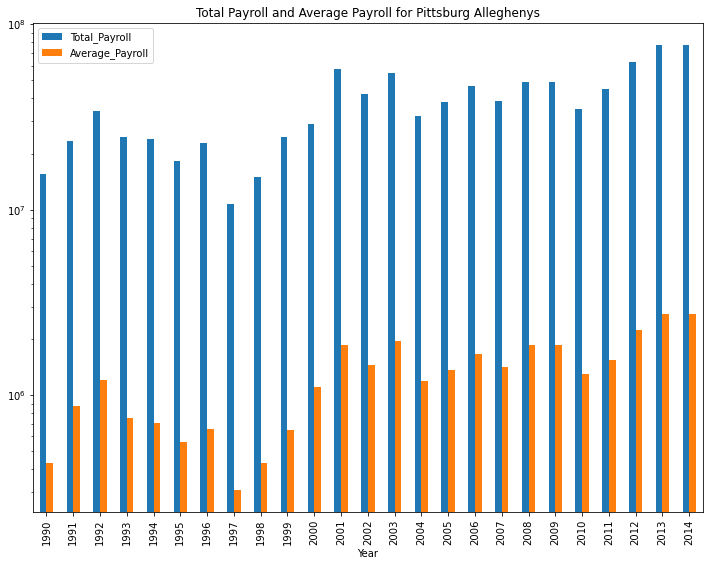

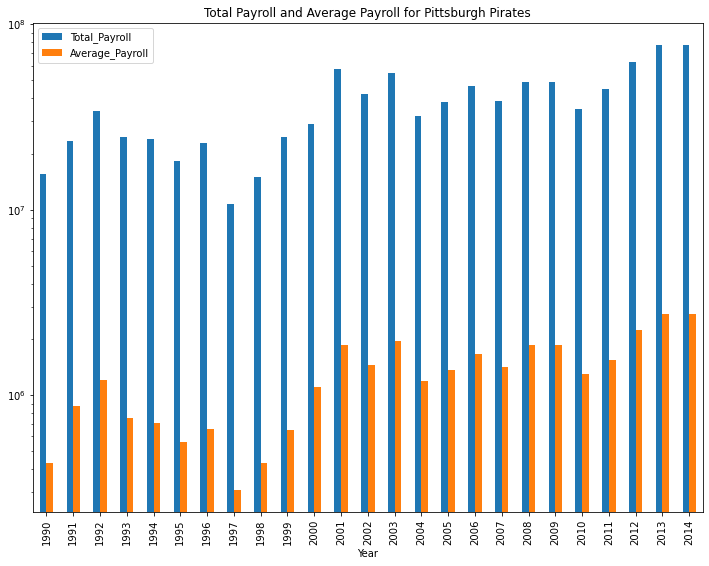

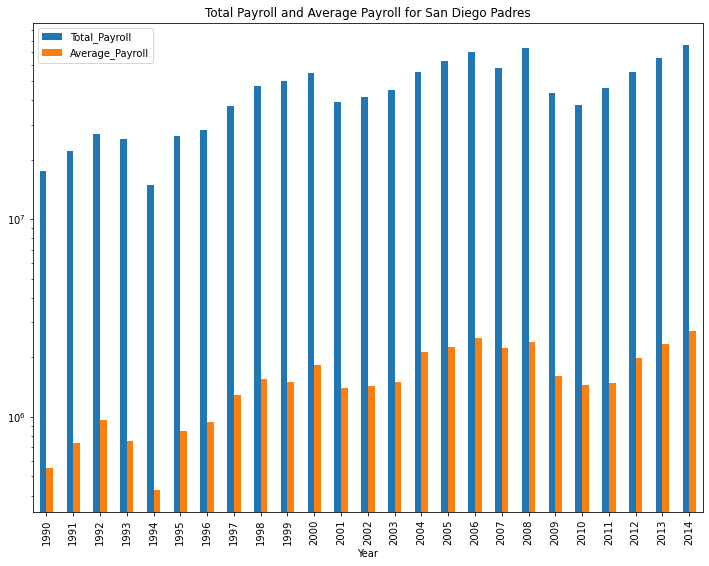

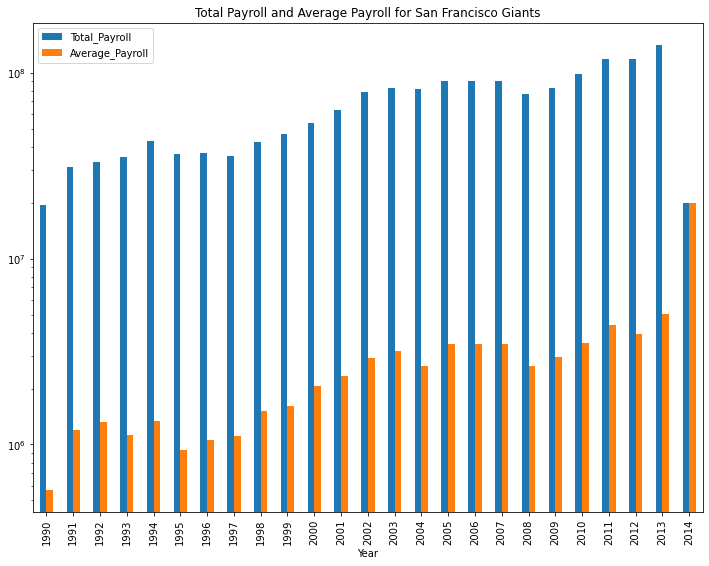

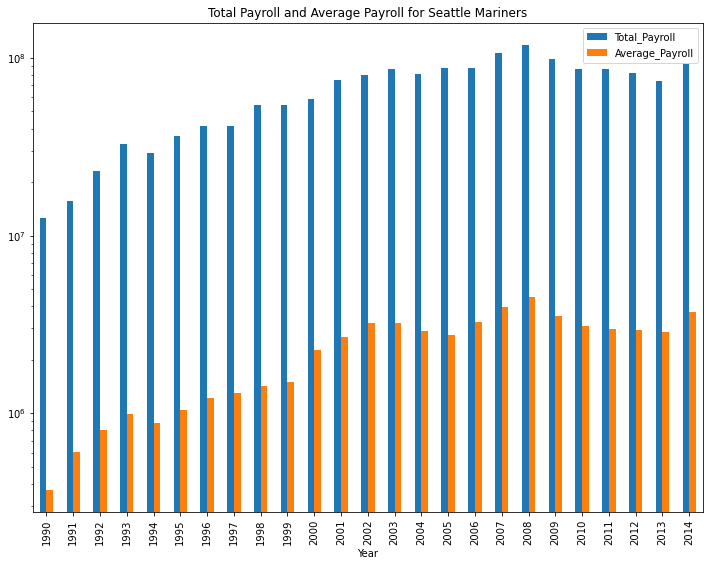

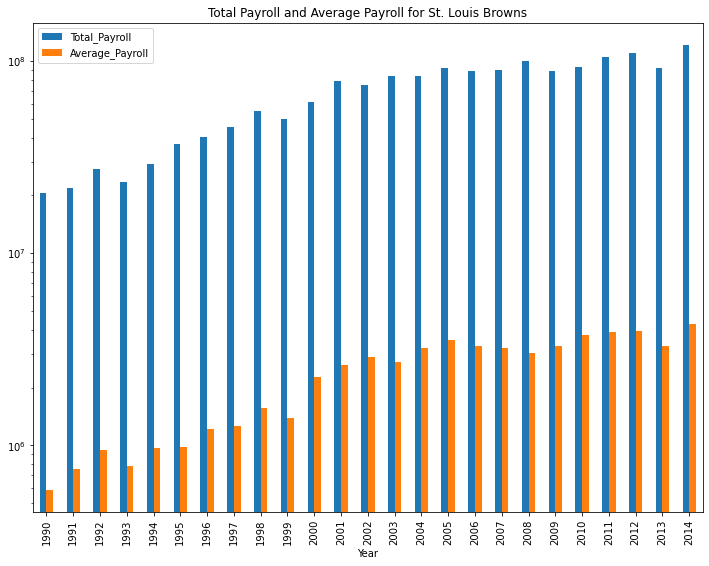

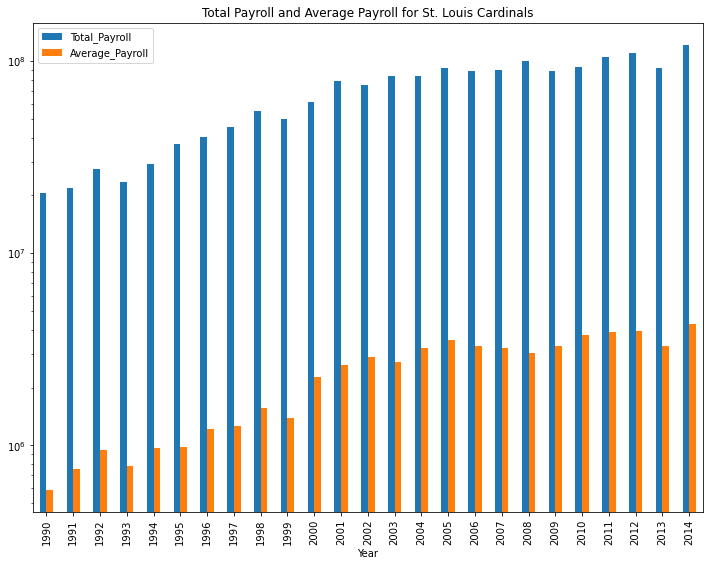

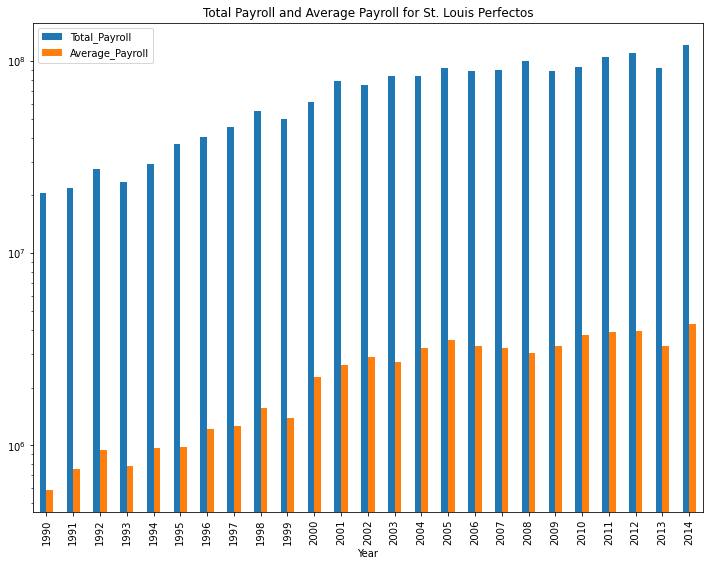

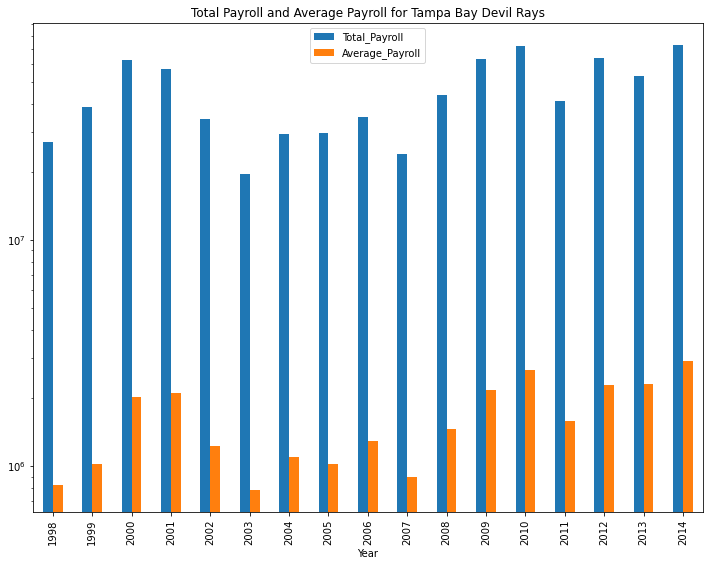

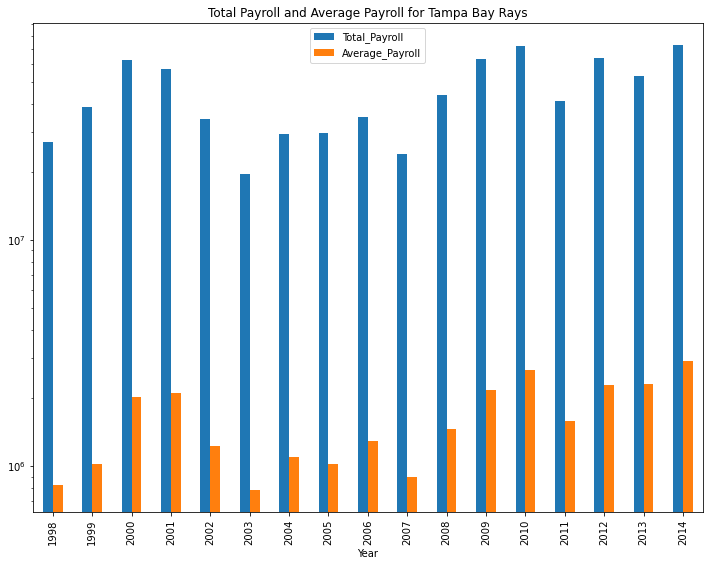

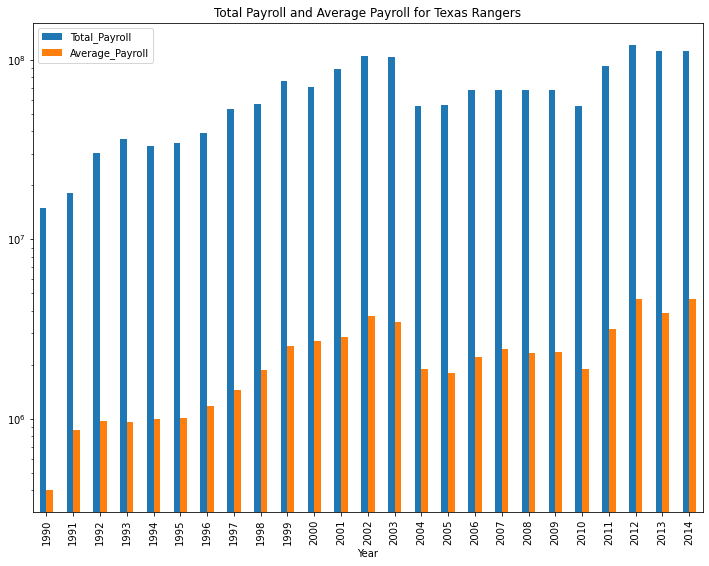

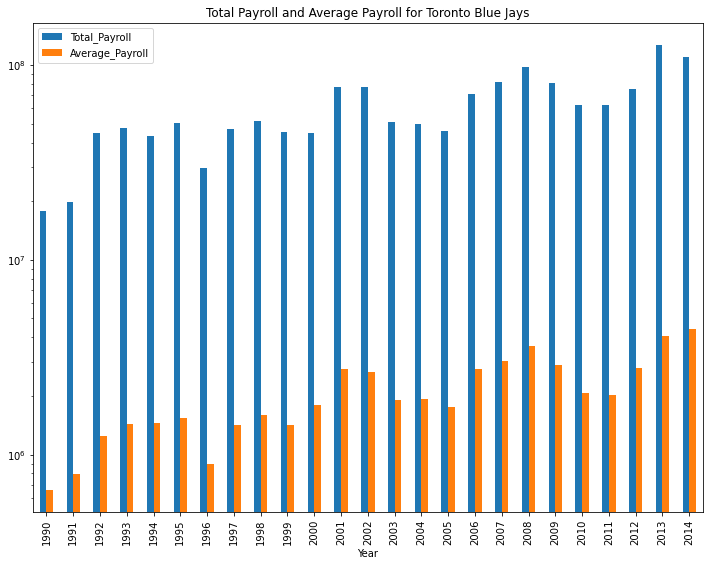

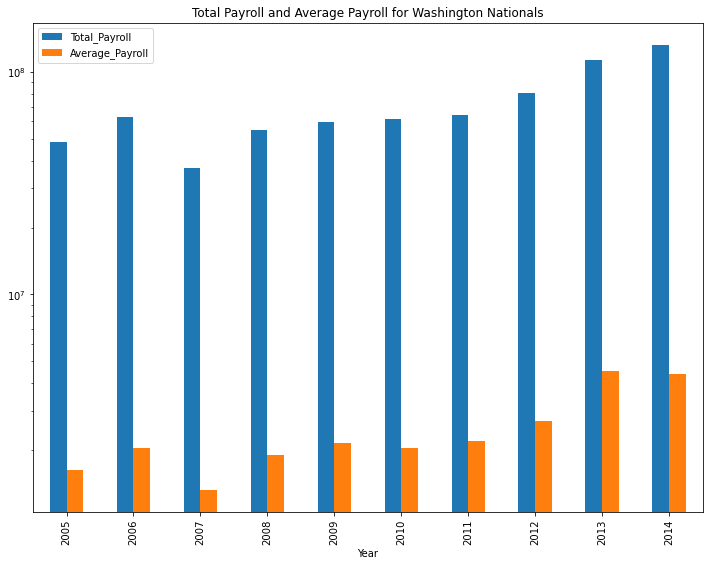

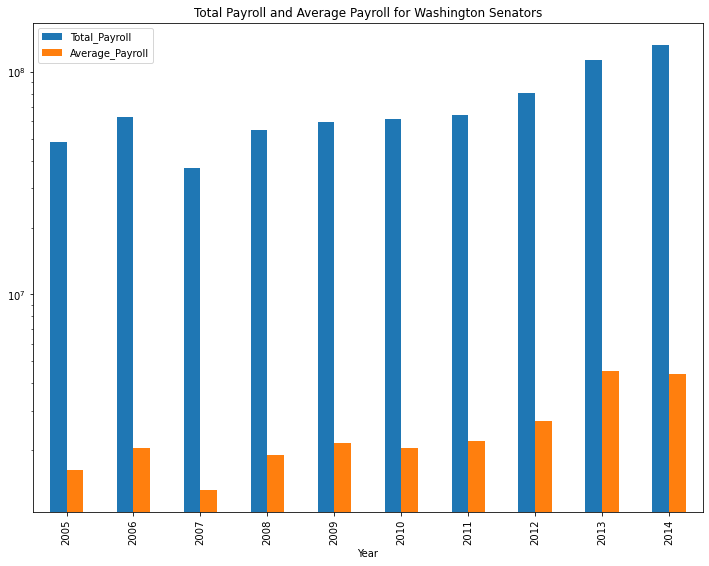

In [417]:

num_results = len(result_frames_objects)
#prevents warning after 20 figures shown
plt.rcParams.update({'figure.max_open_warning':0})
figsize = (12,9)
for i in range(num_results):
    dfr = result_frames_objects[i]
    team_name = team_names[i]
    team_id = team_ids[i]
    #we only plot if the data frame in 
    #question is not empty
    if not dfr.empty: 
        dfr.plot(x='Year', y=['Total_Payroll','Average_Payroll'], logy=True, \
                  title = 'Total Payroll and Average Payroll for ' + team_name, kind='bar',figsize=figsize)
       

The total payroll seems to be very high compared to the average payroll. However, the average here shows the averag salary paid to each player.

### ** Correlation between payroll and winning percentage **

We will first select the percentage winnings for each team for each year. Then we select the average and total payroll for each team over the years, and then join the results together.

In [418]:
winning_query = "SELECT teamID, yearID , " + \
        "(SUM(W)*1.0/(SUM(G)*1.0))*100.0 AS `PERCENTAGE WIN` " + \
        "FROM Teams " + \
        "GROUP BY teamID, yearID " + \
        "ORDER BY teamID, yearID "
winning_percentage_result = pandas.read_sql(winning_query, conn)
winning_percentage_result

,teamID,yearID,PERCENTAGE WIN
0,ALT,1884,24.000000
1,ANA,1997,51.851852
2,ANA,1998,52.469136
3,ANA,1999,43.209877
4,ANA,2000,50.617284
...,...,...,...
2770,WS8,1887,36.507937
2771,WS8,1888,35.294118
2772,WS8,1889,32.283465
2773,WS9,1891,31.654676


In [419]:
some_results = [] 
for index in range(len(team_ids)) :
    team_id = team_ids[index]
    some_query = " SELECT Salaries.yearID, " + \
        "((COUNT(Teams.W)*1.0)/(COUNT(Teams.W)*1.0 + COUNT(Teams.L)*1.0))*100.0 AS `MEAN WINNING PERCENTAGE`, " + \
        "printf('%,d',AVG(Salaries.salary)) AS `AVERAGE PAYROLL` " + \
        "FROM Salaries, Teams " + \
        "WHERE Salaries.teamID = '" + team_id + "' " + \
        "AND Teams.teamID = '" + team_id + "' " + \
        "AND Teams.teamID = Salaries.teamID " + \
        "GROUP BY Salaries.yearID " + \
        "ORDER BY Salaries.teamID, Salaries.yearID "
    v = pandas.read_sql(some_query, conn)
    some_results.append(v)
    
some_results

[Empty DataFrame
 Columns: [yearID, MEAN WINNING PERCENTAGE, AVERAGE PAYROLL]
 Index: [],
    yearID  MEAN WINNING PERCENTAGE AVERAGE PAYROLL
 0    1997                     50.0       1,004,370
 1    1998                     50.0       1,214,147
 2    1999                     50.0       1,384,704
 3    2000                     50.0       1,715,472
 4    2001                     50.0       1,584,505
 5    2002                     50.0       2,204,345
 6    2003                     50.0       2,927,098
 7    2004                     50.0       3,723,506,
     yearID  MEAN WINNING PERCENTAGE AVERAGE PAYROLL
 0     1998                     50.0         898,527
 1     1999                     50.0       2,020,705
 2     2000                     50.0       2,893,851
 3     2001                     50.0       3,038,678
 4     2002                     50.0       3,115,757
 5     2003                     50.0       3,226,280
 6     2004                     50.0       2,406,232
 7     2005      

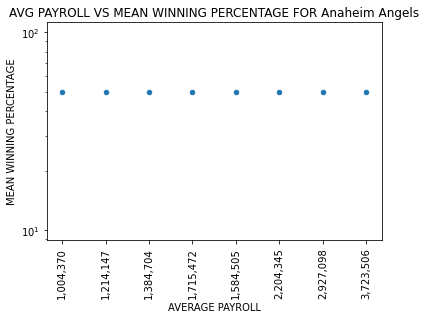

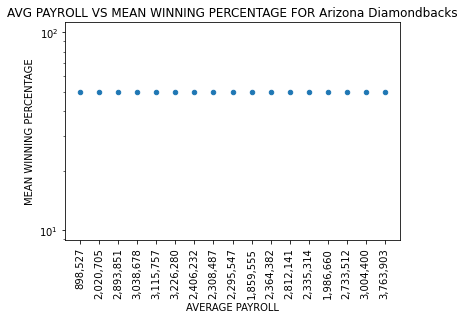

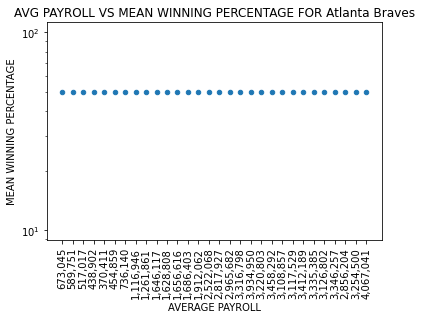

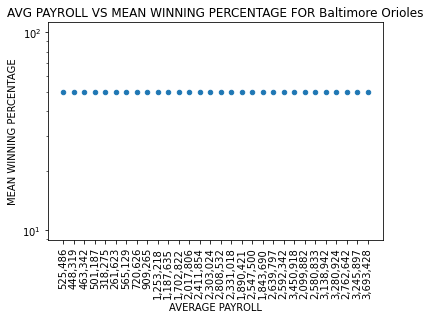

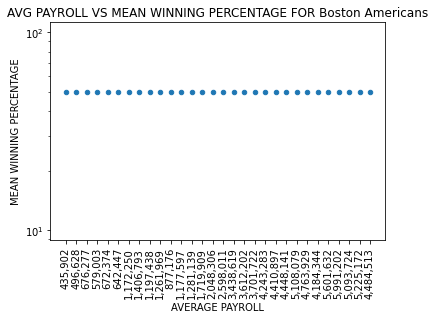

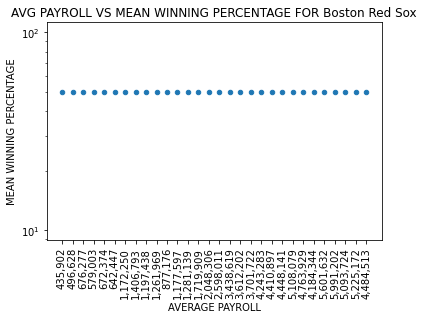

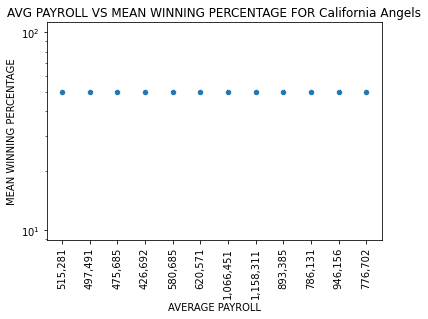

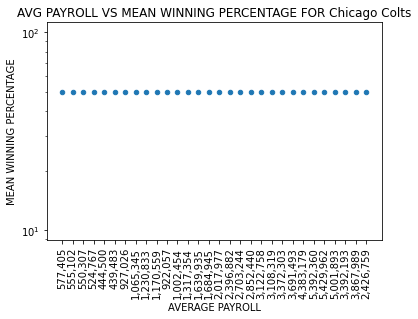

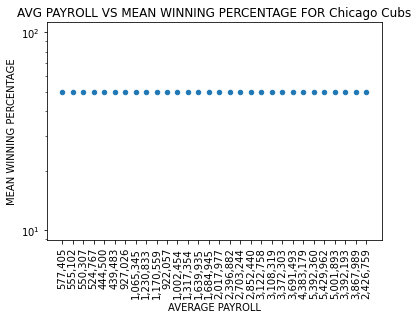

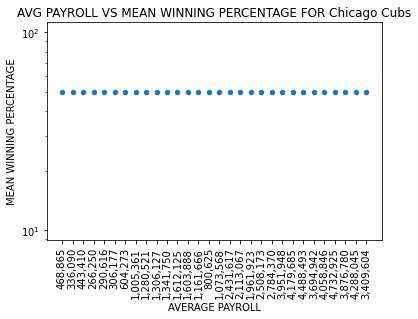

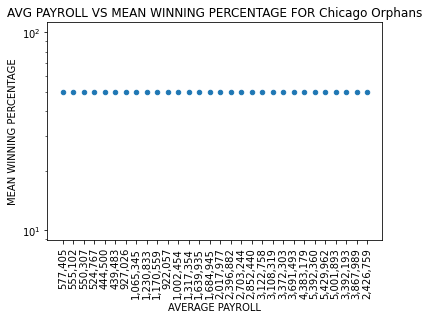

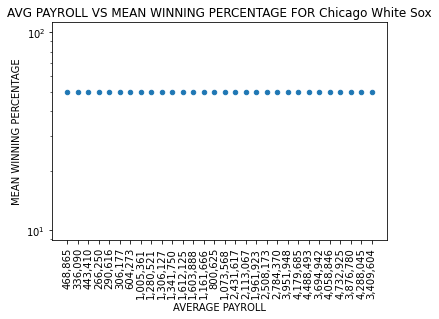

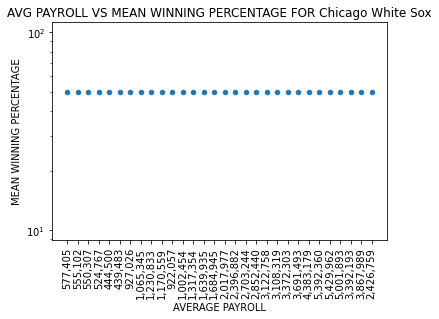

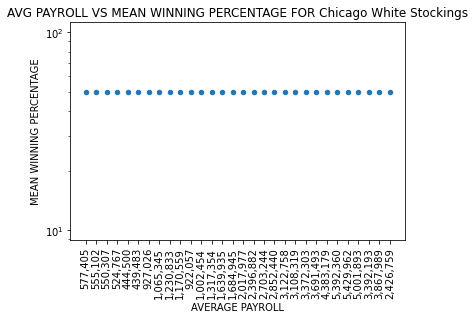

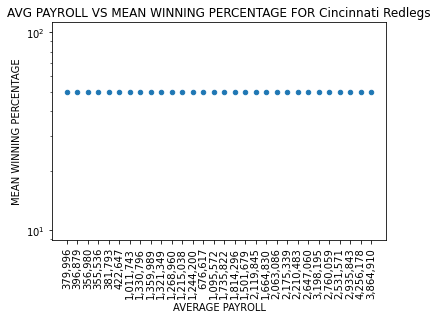

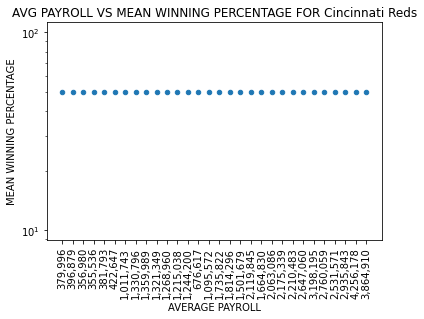

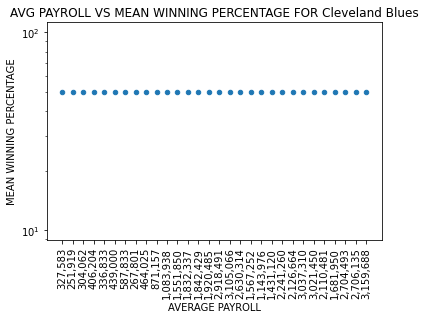

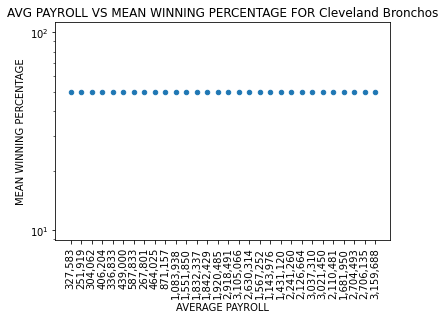

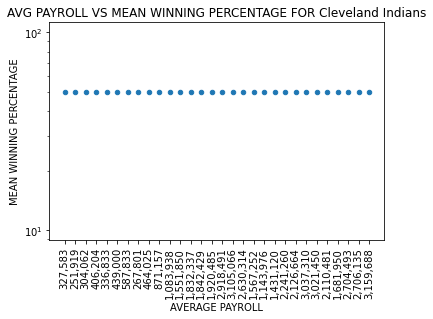

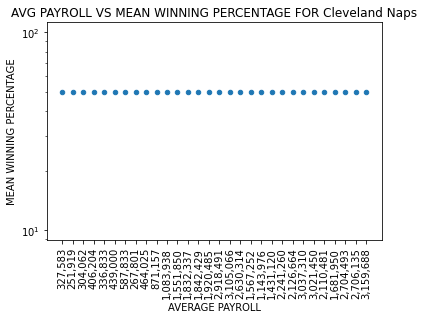

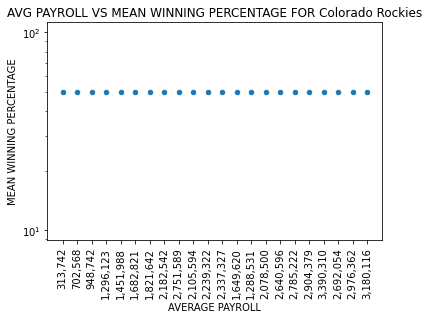

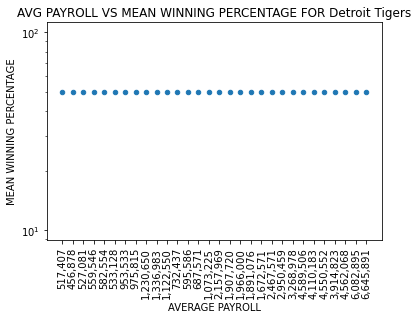

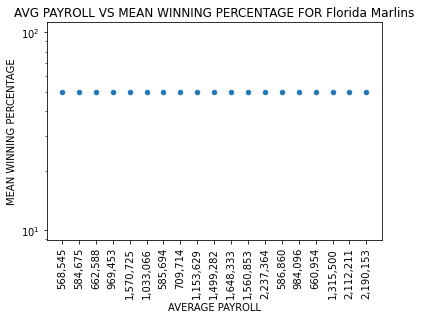

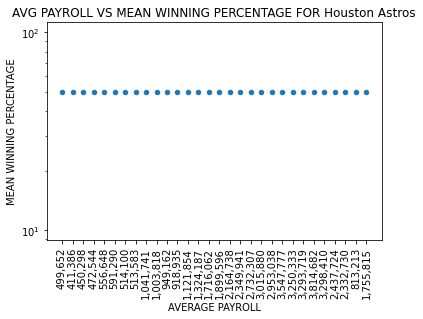

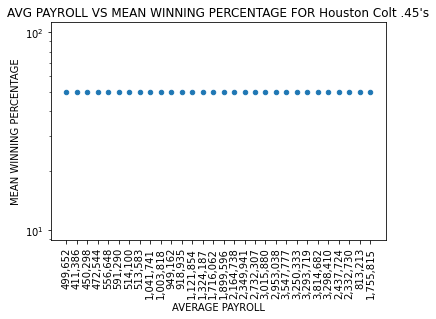

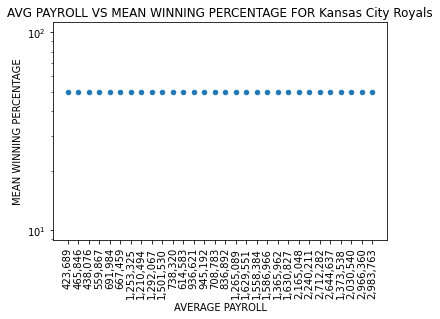

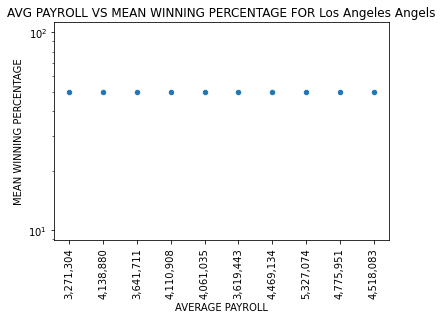

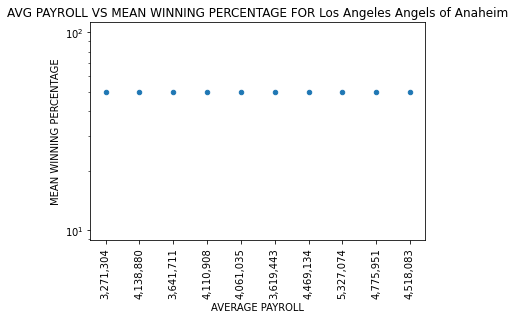

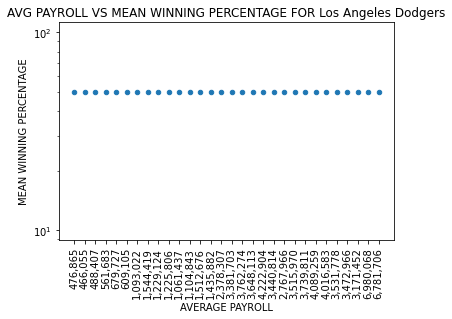

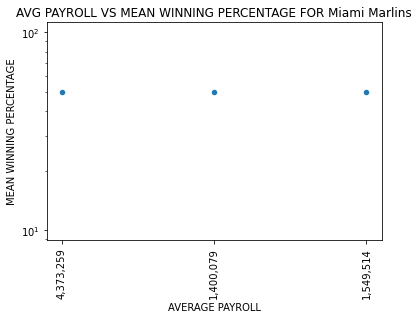

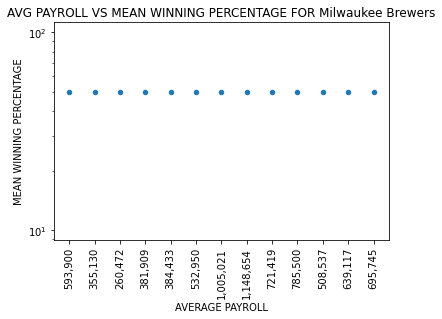

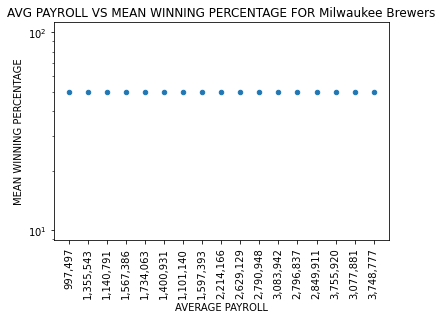

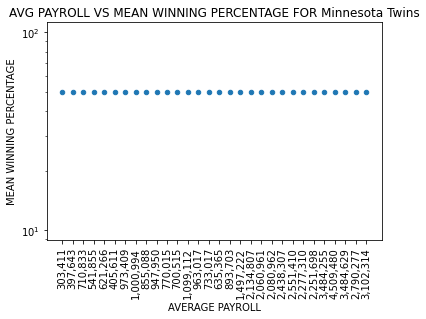

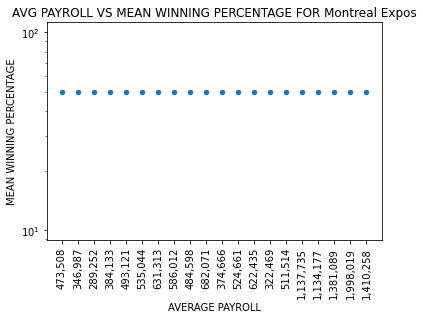

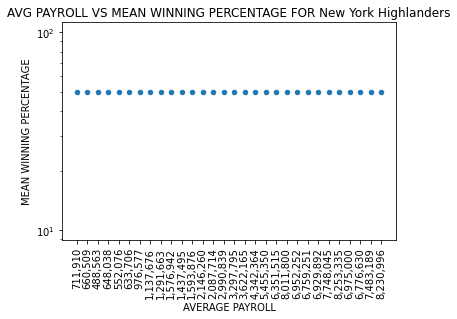

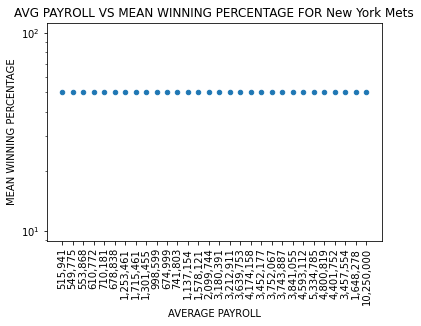

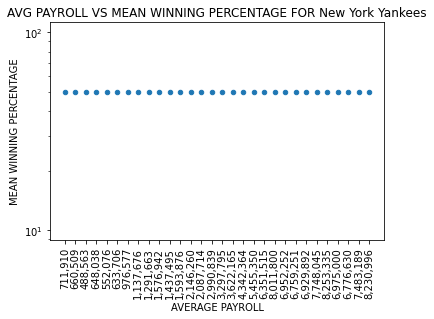

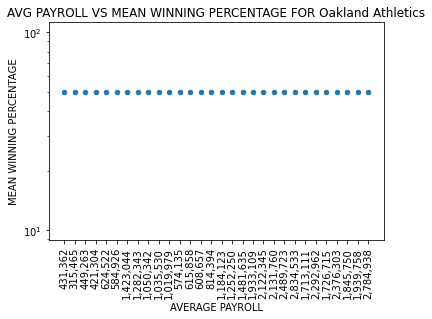

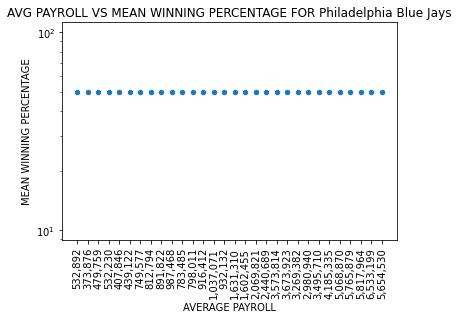

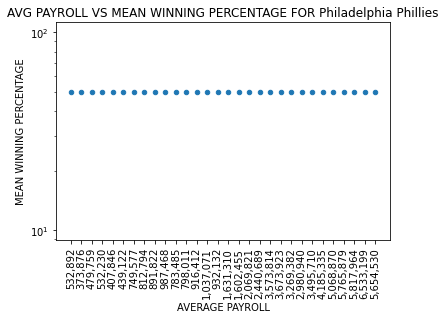

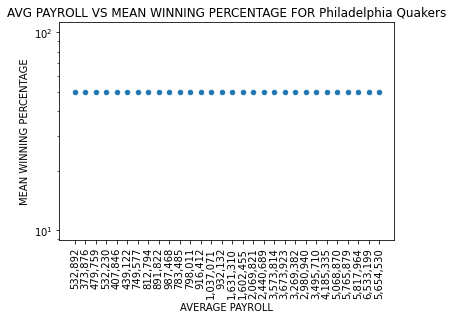

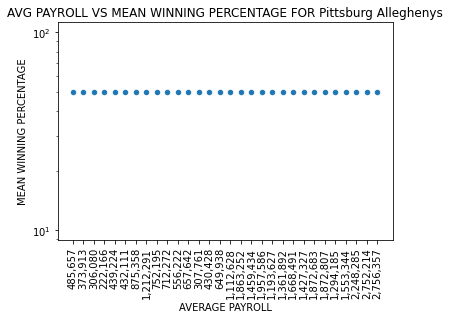

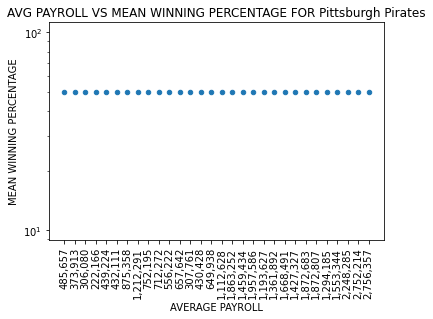

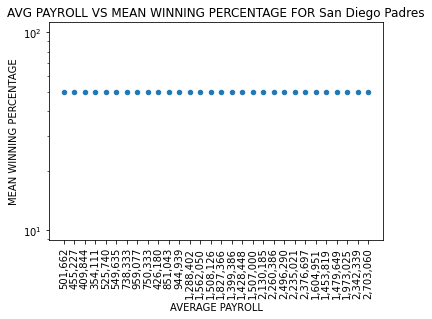

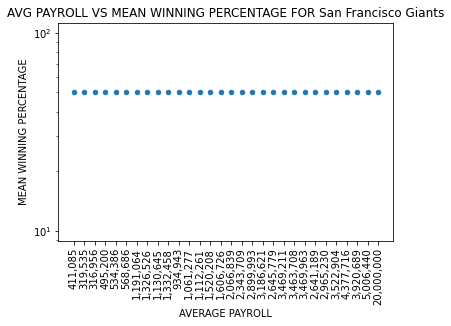

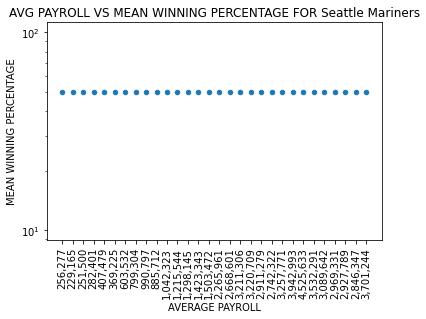

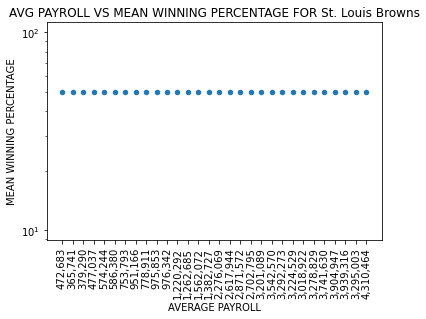

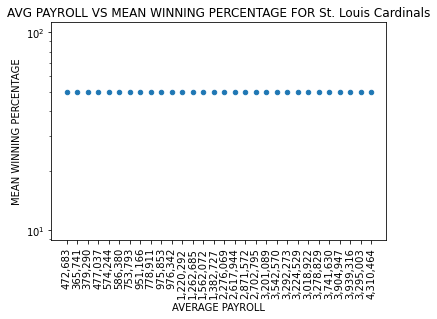

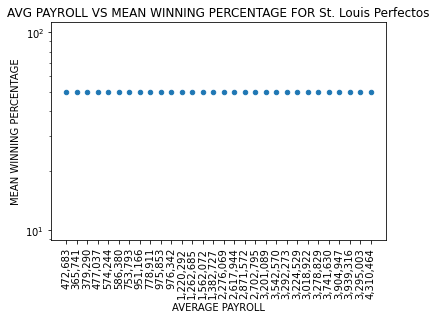

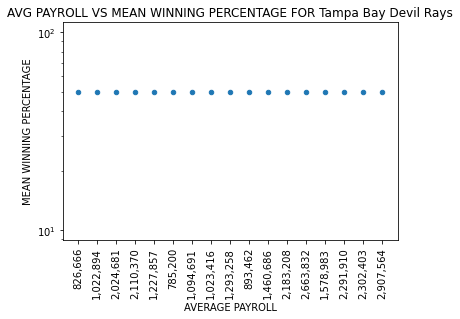

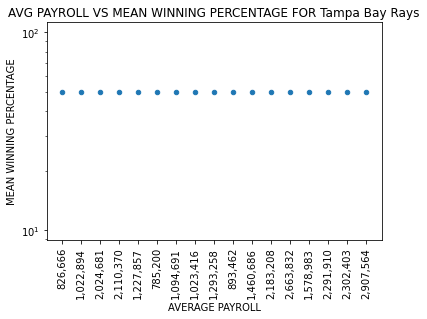

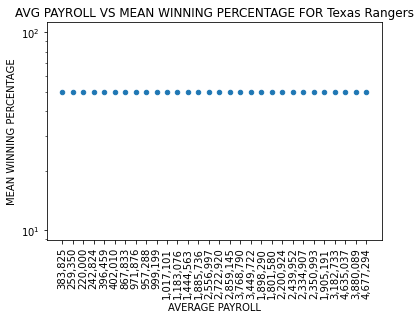

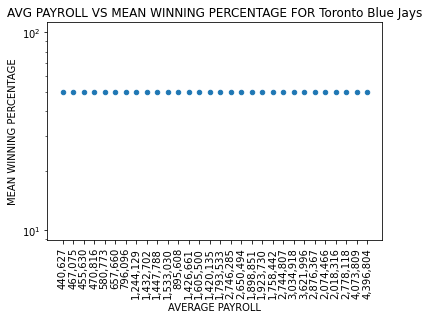

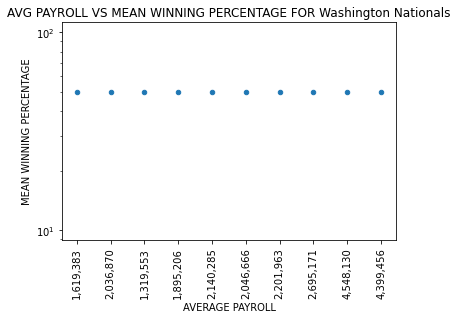

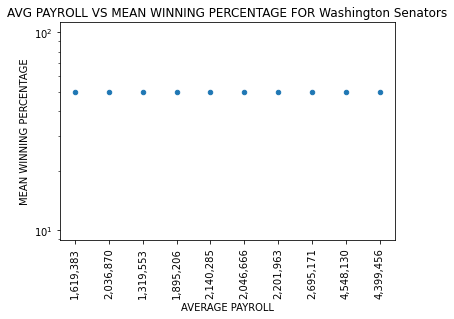

In [420]:
for index in range(len(some_results)):
    r = some_results[index]
    team_id = team_names[index]
    if r.empty == False:
        r.plot(x='AVERAGE PAYROLL', y='MEAN WINNING PERCENTAGE', rot=90, \
                logy=True, kind='scatter', title = 'AVG PAYROLL VS MEAN WINNING PERCENTAGE FOR ' + team_id)
        

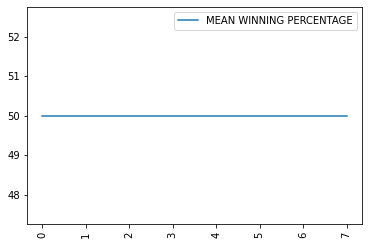

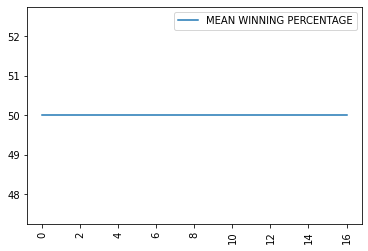

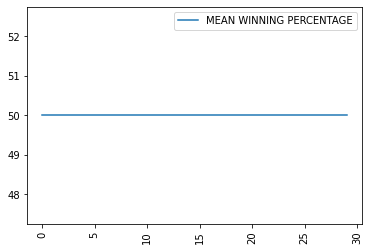

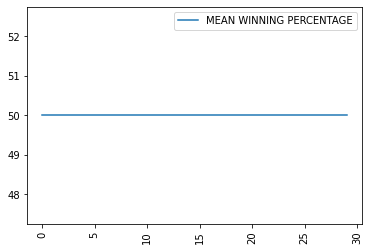

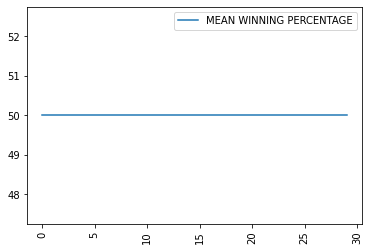

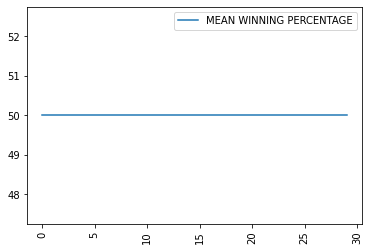

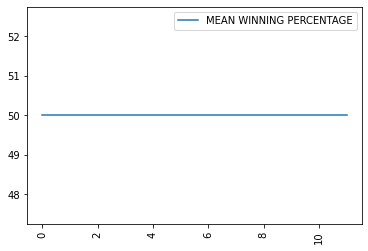

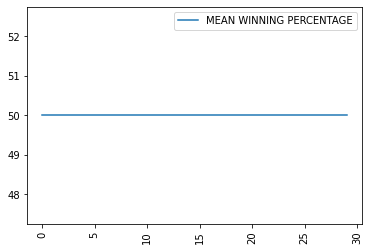

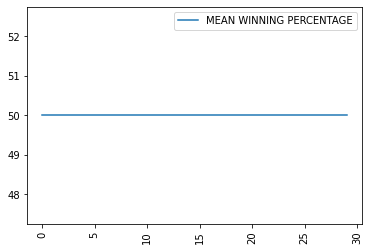

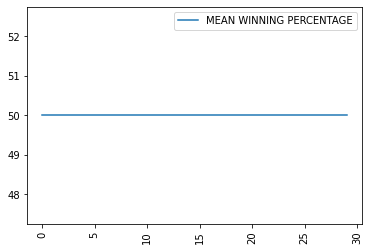

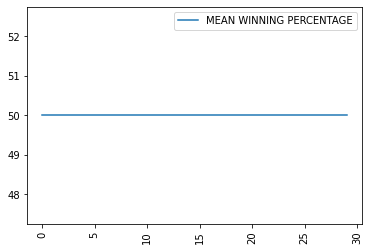

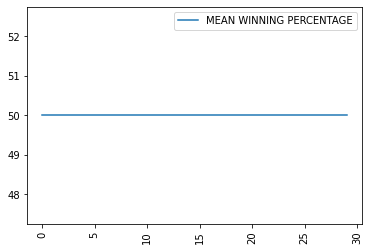

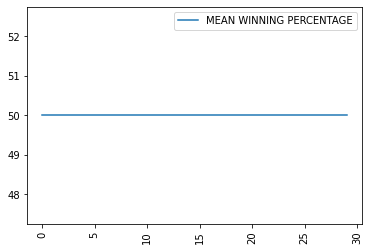

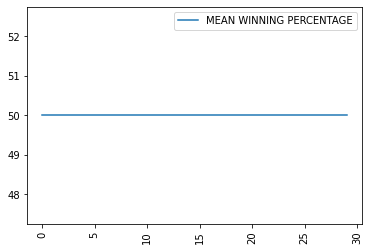

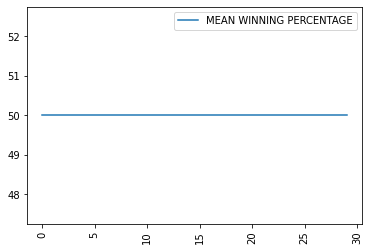

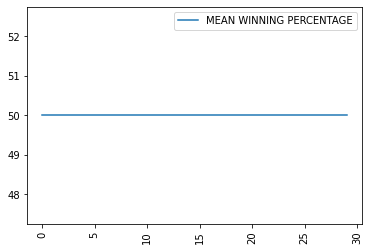

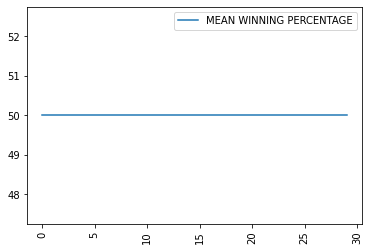

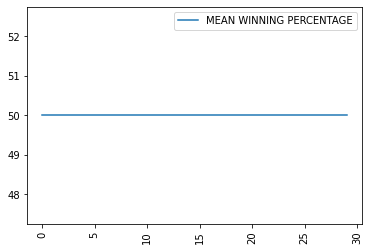

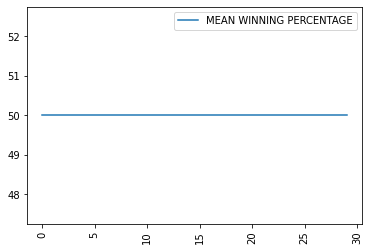

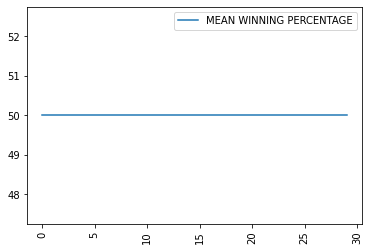

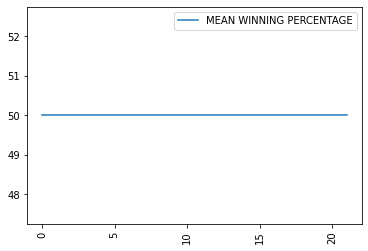

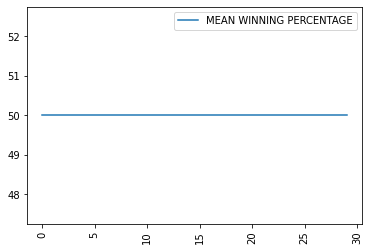

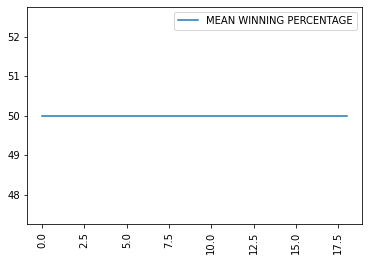

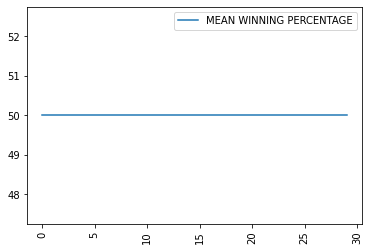

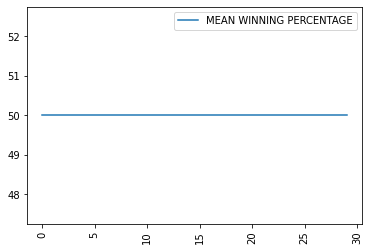

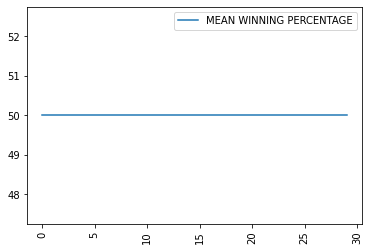

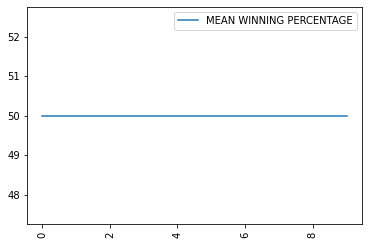

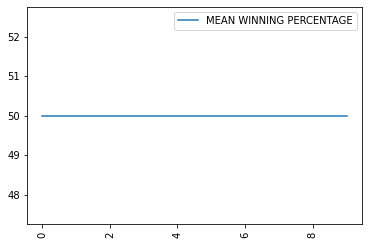

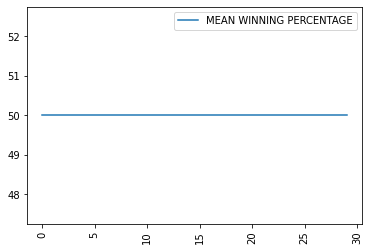

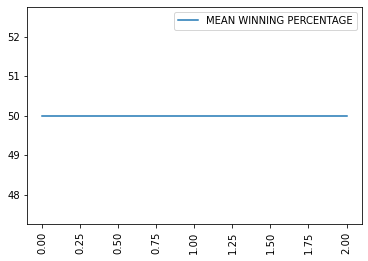

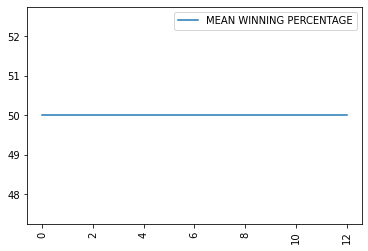

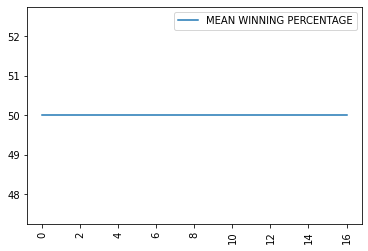

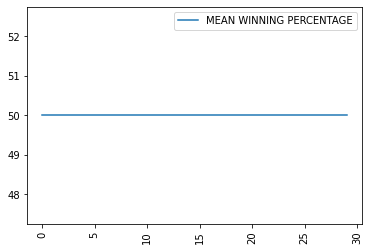

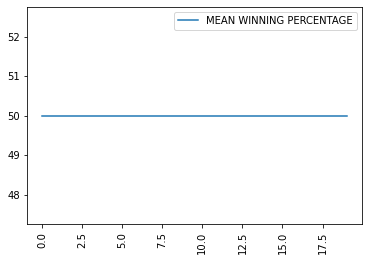

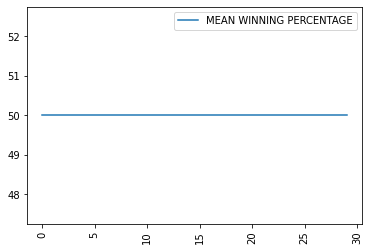

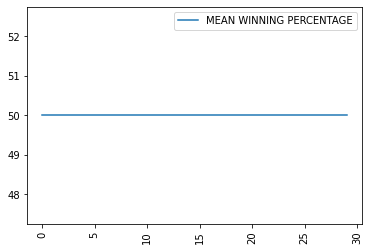

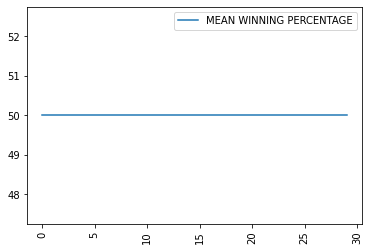

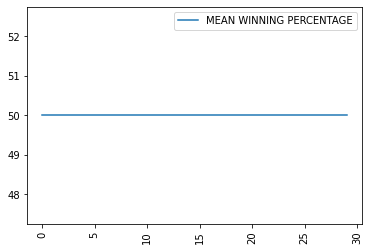

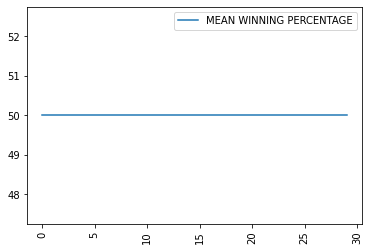

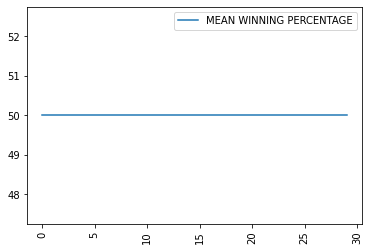

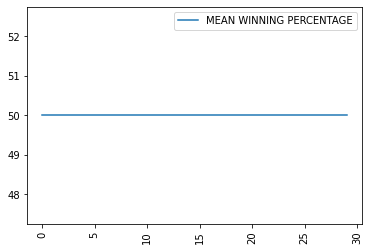

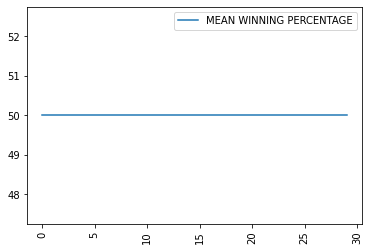

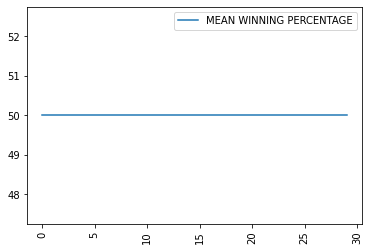

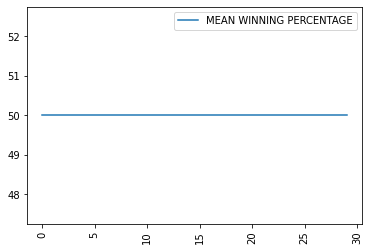

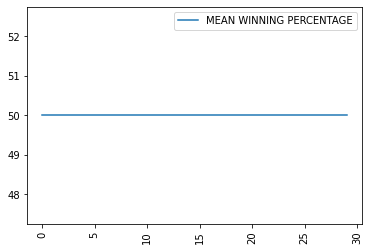

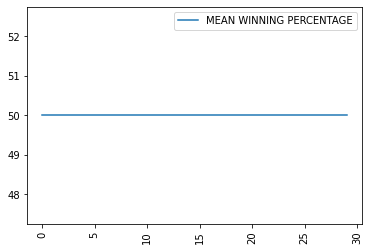

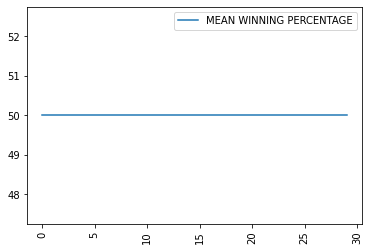

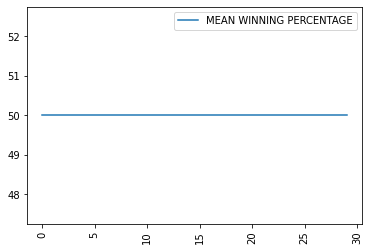

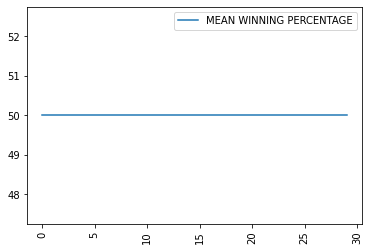

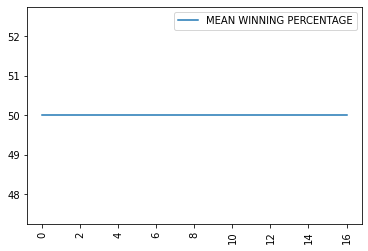

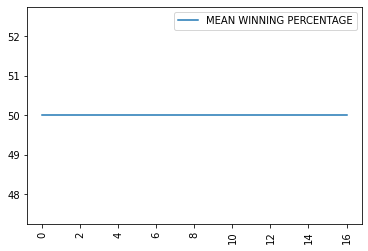

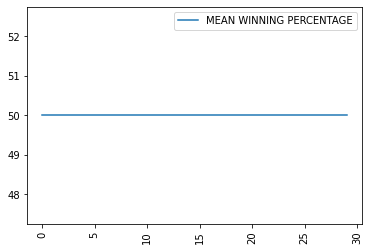

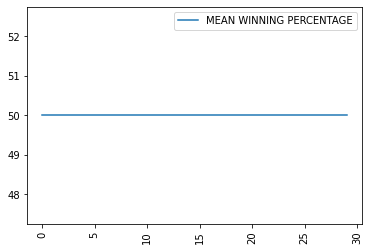

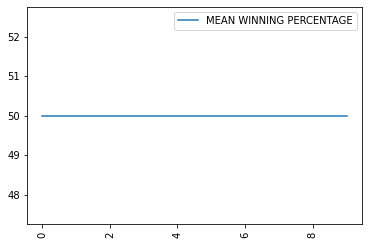

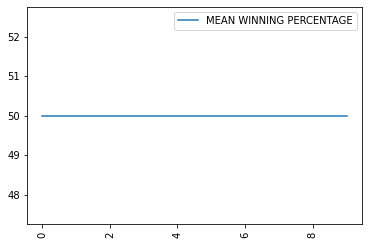

In [421]:

for r in some_results: 
    if not r.empty:
        u = pandas.cut(r['yearID'], bins=5)
        r['Time Periods'] = u
        a = r.groupby(['Time Periods'])[['AVERAGE PAYROLL','MEAN WINNING PERCENTAGE']]
  
        r.plot(y=['AVERAGE PAYROLL','MEAN WINNING PERCENTAGE'], rot=90 )
        

<AxesSubplot:xlabel='None,Time Periods'>

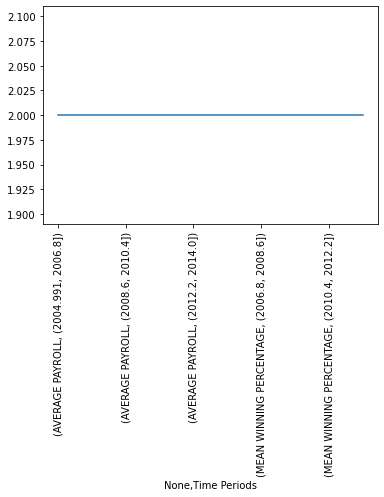

In [422]:
a.count().unstack().plot(x='Average Payroll', y='Time Periods', rot=90)

## Extra Credit

### Below we wll be creating a new sqlite database that has the newest available data (up to 2020)

#### Some imports we need

In [429]:
from os import path
import requests

We will try to re create the database with the most up to date files.
We will first download the zip file using python.
Then we will extract the zip file into a newly created folder.


The url containing the link to download the csv file can be seen beow

In [430]:
url_csv_zip = "https://github.com/chadwickbureau/baseballdatabank/archive/master.zip"

Now let us download the zip file

In [435]:

# download the file contents in binary format
r = requests.get(url_csv_zip)
zipfile_name = "uptodate_csv_files.zip"
# open method to open a file on your system and write the contents
with open(zipfile_name, "wb") as script:
    script.write(r.content)

We can see that a file called uptodate_csv_files.zip has just been created in the project folder(the same folder as this script rnning.)

In [436]:
zipfile_exists = False
if path.exists(zipfile_name):
    zipfile_exists = True
    print("Zip file was downloaded successfully")

Zip file was downloaded successfully


Now we create a new directory to extract the zip file in it.

In [437]:
new_directory = "uptodate_csv_files"
read_mode = 0o777 # mode for read write execute
path_to_extract = os.path.join(os.getcwd(), new_directory)

In [438]:
os.mkdir(path_to_extract, read_mode)

In [439]:
import zipfile
with zipfile.ZipFile(zipfile_name,"r") as zip_variable:
    zip_variable.extractall(path_to_extract)


The above code extracts the downloaded zip file.
There are two to three directories that are created during the extract. We will skip these directories and go to the files that are listed in the core directory.

In [440]:
root_dir = os.getcwd()
csv_locations = new_directory + "/baseballdatabank-master/core"
new_table_names_csv = os.listdir(csv_locations)

The list new_table_names_csv contains all the csv files in the core directory. Each csv file corresponds to one table in the new database. One of the files in the list is a txt file called readme2014.txt. We have to remove that from the list.

In [441]:
# sort the list of table names
new_table_names_csv.sort()

In [442]:
len(new_table_names_csv)

28

In [443]:
new_table_names_csv

['AllstarFull.csv',
 'Appearances.csv',
 'AwardsManagers.csv',
 'AwardsPlayers.csv',
 'AwardsShareManagers.csv',
 'AwardsSharePlayers.csv',
 'Batting.csv',
 'BattingPost.csv',
 'CollegePlaying.csv',
 'Fielding.csv',
 'FieldingOF.csv',
 'FieldingOFsplit.csv',
 'FieldingPost.csv',
 'HallOfFame.csv',
 'HomeGames.csv',
 'Managers.csv',
 'ManagersHalf.csv',
 'Parks.csv',
 'People.csv',
 'Pitching.csv',
 'PitchingPost.csv',
 'Salaries.csv',
 'Schools.csv',
 'SeriesPost.csv',
 'Teams.csv',
 'TeamsFranchises.csv',
 'TeamsHalf.csv',
 'readme2014.txt']

Removing readme2014.txt from the list

In [444]:
file_to_remove = 'readme2014.txt'
if file_to_remove in new_table_names_csv:
    new_table_names_csv.remove(file_to_remove)
new_table_names_csv

['AllstarFull.csv',
 'Appearances.csv',
 'AwardsManagers.csv',
 'AwardsPlayers.csv',
 'AwardsShareManagers.csv',
 'AwardsSharePlayers.csv',
 'Batting.csv',
 'BattingPost.csv',
 'CollegePlaying.csv',
 'Fielding.csv',
 'FieldingOF.csv',
 'FieldingOFsplit.csv',
 'FieldingPost.csv',
 'HallOfFame.csv',
 'HomeGames.csv',
 'Managers.csv',
 'ManagersHalf.csv',
 'Parks.csv',
 'People.csv',
 'Pitching.csv',
 'PitchingPost.csv',
 'Salaries.csv',
 'Schools.csv',
 'SeriesPost.csv',
 'Teams.csv',
 'TeamsFranchises.csv',
 'TeamsHalf.csv']

Now let's get the list of tables in the old database we started this script with, to make sure that we have the same table names, and table structure. If we have the same names of tables and table structure for each table, then we can use the create table statement of the old database to create a new database.

In [445]:
show_tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
old_db_tables_results = pandas.read_sql(show_tables_query, conn)
old_db_tables_results.sort_values(by=['name'])

,name
0,AllstarFull
1,Appearances
2,AwardsManagers
3,AwardsPlayers
4,AwardsShareManagers
5,AwardsSharePlayers
6,Batting
7,BattingPost
8,CollegePlaying
9,Fielding


The above shows 24 tables. So the old database has 24 tables

In [446]:
len(new_table_names_csv)

27

Remove the csv extensions on the list of tables to have exactly the table names

The new databse seems to have 3 more tables than the old one.
Now let's extact the table name, by removing the extension for each of the csv file names.

In [447]:
new_db_table_names = []
for f in new_table_names_csv:
    t = os.path.splitext(f)
    new_db_table_names.append(t[0])

So we need to compare the list of tables in the new database to create with the list of tables in the old database. For that we will use the difference function of a set. We start by transforming each list to a set and comparing both

In [448]:
old_db_table_names = old_db_tables_results['name'].tolist()

Now let's have a look at the content of the new database table not found in the old databse table.

In [449]:
set(new_db_table_names).difference(set(old_db_table_names))

{'FieldingOFsplit', 'HomeGames', 'Parks', 'People'}

Now let's have a look at the content of the old database table not found in the new databse table.

In [450]:
set(old_db_table_names).difference(set(new_db_table_names))

{'Master'}

Remove the Master table because it is not part of the new database

In [451]:
old_db_table_names.remove('Master')

We can see that the new databse is different than the old database. The old database has a Master table that the new databse doe not have. The new database has 4 tables that are not found in the old database. The easiest way to do it is to manually create tables for each csv file.

It will be tedious but we will get there. We will create the new database, and we will create each table in the new downloaded extracted unzipped csv files. 

In [452]:
new_2020_sqlite_file = 'lahman2020.sqlite'
new_db_conn = sqlite3.connect(new_2020_sqlite_file)

See the content of the old table names. It does not contain the Master table anymore.

Now for each of the old tables found in the new database, generate the schema and use that schema to create the table in the new database.

In [453]:
q = """
        SELECT sql
        FROM sqlite_master
            WHERE sql NOT NULL AND
            type == 'table'
    """
create_stmts = pandas.read_sql_query(q, conn) 

In [454]:
lst_queries = create_stmts['sql'].tolist()


In [455]:
l = []
for q in lst_queries:
    l.append(q.replace("\n",""))

In [456]:
cursor = new_db_conn.cursor()

for t in l:
    cursor.execute(t)


Check to see if the tables where created. If they were then basically the database will have tables sql schema in the sqlite master table. 

In [457]:
check_create = """
        SELECT sql
        FROM sqlite_master
            WHERE sql NOT NULL AND
            type == 'table'
    """
new_create_stmts = pandas.read_sql_query(check_create, new_db_conn) 

In [458]:
new_create_stmts['sql']

0     CREATE TABLE AllstarFull (playerID TEXT,yearID...
1     CREATE TABLE Appearances (yearID INTEGER,teamI...
2     CREATE TABLE AwardsManagers (playerID TEXT,awa...
3     CREATE TABLE AwardsPlayers (playerID TEXT,awar...
4     CREATE TABLE AwardsShareManagers (awardID TEXT...
5     CREATE TABLE AwardsSharePlayers (awardID TEXT,...
6     CREATE TABLE Batting (playerID TEXT,yearID INT...
7     CREATE TABLE BattingPost (yearID INTEGER,round...
8     CREATE TABLE CollegePlaying (playerID TEXT,sch...
9     CREATE TABLE Fielding (playerID TEXT,yearID IN...
10    CREATE TABLE FieldingOF (playerID TEXT,yearID ...
11    CREATE TABLE FieldingPost (playerID TEXT,yearI...
12    CREATE TABLE HallOfFame (playerID TEXT,yearid ...
13    CREATE TABLE Managers (playerID TEXT,yearID IN...
14    CREATE TABLE ManagersHalf (playerID TEXT,yearI...
15    CREATE TABLE Master (playerID TEXT,birthYear I...
16    CREATE TABLE Pitching (playerID TEXT,yearID IN...
17    CREATE TABLE PitchingPost (playerID TEXT,y

Now for the four new tables, let's add them to the new database. Here they are below :

In [459]:
set_difference = set(new_db_table_names).difference(set(old_db_table_names))

In [460]:
lst_difference = list(set_difference)
lst_difference

['People', 'FieldingOFsplit', 'Parks', 'HomeGames']

We will use the function found at 
### https://www.geeksforgeeks.org/get-column-names-from-csv-using-python/

In [461]:
def list_columns(file_path_name):
    import csv
  
    # opening the csv file by specifying
    # the location
    # with the variable name as csv_file
    with open(file_path_name) as csv_file:

        # creating an object of csv reader
        # with the delimiter as ,
        csv_reader = csv.reader(csv_file, delimiter = ',')

        # list to store the names of columns
        list_of_column_names = []

        # loop to iterate thorugh the rows of csv
        for row in csv_reader:

            # adding the first row
            list_of_column_names.append(row)

            # breaking the loop after the
            # first iteration itself
            break

        return list_of_column_names[0]

Now let's just create the 4 missing tables in the new databse. For that we need to open the file locations and list the columns for each file

In [462]:
# create a ew dictionary
d = dict()
extension = ".csv"
for file_name in lst_difference :
    file_path_name = csv_locations + "/" + file_name + extension
    list_of_column_names = list_columns(file_path_name)
    d[file_name + extension] = list_of_column_names

In [463]:
d.keys()

dict_keys(['People.csv', 'FieldingOFsplit.csv', 'Parks.csv', 'HomeGames.csv'])

From the above we can generate the create statements query

In [464]:
d['People.csv']

['playerID',
 'birthYear',
 'birthMonth',
 'birthDay',
 'birthCountry',
 'birthState',
 'birthCity',
 'deathYear',
 'deathMonth',
 'deathDay',
 'deathCountry',
 'deathState',
 'deathCity',
 'nameFirst',
 'nameLast',
 'nameGiven',
 'weight',
 'height',
 'bats',
 'throws',
 'debut',
 'finalGame',
 'retroID',
 'bbrefID']

Well just found out that the People table is basically the Master table in the old databse. Simply rename Master to People.

In [465]:
rename_master_query = "ALTER TABLE Master RENAME TO People;"
nb_executes = pandas.read_sql_query(rename_master_query, new_db_conn) 

In [466]:
nb_executes

,1


Operation was a success

Create table for FieldingOfSplit

dict_keys(['People.csv', 'FieldingOFsplit.csv', 'Parks.csv', 'HomeGames.csv'])

In [467]:
d['FieldingOFsplit.csv']


['playerID',
 'yearID',
 'stint',
 'teamID',
 'lgID',
 'POS',
 'G',
 'GS',
 'InnOuts',
 'PO',
 'A',
 'E',
 'DP',
 'PB',
 'WP',
 'SB',
 'CS',
 'ZR']

Based on the abpve, we can generate the following query.

In [468]:
drop_first = "DROP TABLE IF EXISTS FieldingOFsplit ;";
FieldingOFsplit_query = """
    CREATE TABLE IF NOT EXISTS FieldingOFsplit(
        playerID TEXT PRIMARY KEY,
        yearID INTEGER,
        stint INTEGER ,
        teamID TEXT ,
        lgID TEXT ,
        POS TEXT,
        G INTEGER,
        GS INTEGER,
        InnOuts INTEGER,
        PO INTEGER,
        A INTEGER,
        E INTEGER,
        DP INTEGER,
        PB TEXT,
        WP TEXT,
        SB TEXT,
        CS TEXT,
        ZR TEXT

    );

    """

Create the above query

In [469]:
success = cursor.execute(drop_first)
success

In [470]:
success = cursor.execute(FieldingOFsplit_query)
success

Check the creation by looking into the schema

In [471]:
check_create = """
        SELECT sql
        FROM sqlite_master
            WHERE sql NOT NULL AND
            type == 'table'
    """
new_create_stmts = pandas.read_sql_query(check_create, new_db_conn)
new_create_stmts['sql']

0     CREATE TABLE AllstarFull (playerID TEXT,yearID...
1     CREATE TABLE Appearances (yearID INTEGER,teamI...
2     CREATE TABLE AwardsManagers (playerID TEXT,awa...
3     CREATE TABLE AwardsPlayers (playerID TEXT,awar...
4     CREATE TABLE AwardsShareManagers (awardID TEXT...
5     CREATE TABLE AwardsSharePlayers (awardID TEXT,...
6     CREATE TABLE Batting (playerID TEXT,yearID INT...
7     CREATE TABLE BattingPost (yearID INTEGER,round...
8     CREATE TABLE CollegePlaying (playerID TEXT,sch...
9     CREATE TABLE Fielding (playerID TEXT,yearID IN...
10    CREATE TABLE FieldingOF (playerID TEXT,yearID ...
11    CREATE TABLE FieldingPost (playerID TEXT,yearI...
12    CREATE TABLE HallOfFame (playerID TEXT,yearid ...
13    CREATE TABLE Managers (playerID TEXT,yearID IN...
14    CREATE TABLE ManagersHalf (playerID TEXT,yearI...
15    CREATE TABLE "People" (playerID TEXT,birthYear...
16    CREATE TABLE Pitching (playerID TEXT,yearID IN...
17    CREATE TABLE PitchingPost (playerID TEXT,y

In [472]:
new_create_stmts['sql']

0     CREATE TABLE AllstarFull (playerID TEXT,yearID...
1     CREATE TABLE Appearances (yearID INTEGER,teamI...
2     CREATE TABLE AwardsManagers (playerID TEXT,awa...
3     CREATE TABLE AwardsPlayers (playerID TEXT,awar...
4     CREATE TABLE AwardsShareManagers (awardID TEXT...
5     CREATE TABLE AwardsSharePlayers (awardID TEXT,...
6     CREATE TABLE Batting (playerID TEXT,yearID INT...
7     CREATE TABLE BattingPost (yearID INTEGER,round...
8     CREATE TABLE CollegePlaying (playerID TEXT,sch...
9     CREATE TABLE Fielding (playerID TEXT,yearID IN...
10    CREATE TABLE FieldingOF (playerID TEXT,yearID ...
11    CREATE TABLE FieldingPost (playerID TEXT,yearI...
12    CREATE TABLE HallOfFame (playerID TEXT,yearid ...
13    CREATE TABLE Managers (playerID TEXT,yearID IN...
14    CREATE TABLE ManagersHalf (playerID TEXT,yearI...
15    CREATE TABLE "People" (playerID TEXT,birthYear...
16    CREATE TABLE Pitching (playerID TEXT,yearID IN...
17    CREATE TABLE PitchingPost (playerID TEXT,y

Creating Parks table

In [473]:
d['Parks.csv']

['park.key', 'park.name', 'park.alias', 'city', 'state', 'country']

In [474]:
drop_first = "DROP TABLE IF EXISTS Parks ;";
Parks_query = """
    CREATE TABLE IF NOT EXISTS Parks(
        id TEXT PRIMARY KEY,
        name TEXT,
        alias TEXT,
        city TEXT,
        state TEXT,
        country TEXT
    );

    """

In [475]:
success = cursor.execute(drop_first)
success

In [476]:
success = cursor.execute(Parks_query)
success

Now the whole new database has been created. Now we can insert the values into the tables

Open each csv file and insert their values in the table

In [477]:
import csv

In [478]:
# Batting generates an error. so remove it and deal with it seperately
new_table_names_csv.remove("Batting.csv")
for file_name in new_table_names_csv:
    file_path_name = csv_locations + "/" + file_name
    table_name = os.path.splitext(file_name)[0]
    with open(file_path_name, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        k = len(data)
        if k > 1:
            for i in range(1,len(data)):
                words = data[i]
                values =','.join(f'\'{w}\'' for w in words)
                if values:
                    delete_query = " DELETE FROM " + table_name + " WHERE TRUE "
                    #','.join(f'"{w}"' for w in words)
                    query = "INSERT INTO "+ table_name  + \
                    " VALUES (" + values + " ) ; " 
                    c = cursor.execute(delete_query)
                    c = cursor.execute(query)

OperationalError: no such table: HomeGames

In [479]:
check_create = """
        SELECT sql
        FROM sqlite_master
            WHERE sql NOT NULL AND
            type == 'table'
    """
new_create_stmts = pandas.read_sql_query(check_create, new_db_conn)
new_create_stmts

,sql
0,"CREATE TABLE AllstarFull (playerID TEXT,yearID..."
1,"CREATE TABLE Appearances (yearID INTEGER,teamI..."
2,"CREATE TABLE AwardsManagers (playerID TEXT,awa..."
3,"CREATE TABLE AwardsPlayers (playerID TEXT,awar..."
4,CREATE TABLE AwardsShareManagers (awardID TEXT...
5,"CREATE TABLE AwardsSharePlayers (awardID TEXT,..."
6,"CREATE TABLE Batting (playerID TEXT,yearID INT..."
7,"CREATE TABLE BattingPost (yearID INTEGER,round..."
8,"CREATE TABLE CollegePlaying (playerID TEXT,sch..."
9,"CREATE TABLE Fielding (playerID TEXT,yearID IN..."
